<h1 style='text-align:center;font-weight:bold;color:orange'>Customer Churn Prediction</h1>

**Meeting Logs** (To Delete Later, Documentation Only)
- <span style='border:2px solid blue'>2024-07-23</span>: Saran dari Mas Nabil: (1) Tambahkan uji statistik di categorical variable (Phi-k atau chi-square) buat uji independensi antara fitur dan target. (2) 
- <span style='border:2px solid blue'>2024-07-23</span>: **Experiment flow**: Manakah eksperiment flow yang benar? (1) Compare baseline model $\Rightarrow$ hyperparameter tuning $\Rightarrow$ Compare models lagi dengan penambahan treatment dan hyperparameter tuning, atau (2) Compare baseline model $\Rightarrow$ hyperparameter tuning $\Rightarrow$ pilih beberapa model performa terbaik di baseline dan tambah treatment plus hyperparameter tuning?
    - **Saran**: Compare model di setiap experiment $\Rightarrow$ ambil terbaik satu lalu tuning
- <span style='border: 2px solid blue'>2024-07-23</span>: **Yeo-Johnson transformation**: Jika sudah menggunakan robust scaling, apakah Yeo-Johnson transformation masih diperlukan?
    - **Saran**: Tidak perlu karena hasilnya mirip dan model berbasis tree tidak terpengaruh oleh skew
- <span style='border:2px solid blue'>2024-07-19</span>: **Prescriptive approach**: Bagaimana cara menggunakan pendekatan preskriptif untuk decision-making terkait churn?
    - **Saran**: Kaitkan analisis dengan feature atau permutation importance untuk mencari feature mana yang paling penting terhadap prediksi model. Selanjutnya, gunakan counterfactual explanation untuk rinciannya. Counterfactual explanation bisa disetting untuk fitur tertentu.
- <span style='border:2px solid blue'>2024-07-19</span>: **Target audience presentasi**: Seberapa technical kita bisa membuat presentation deck? Stakeholder kami Customer Experience Manager tetapi panelis punya latar belakang teknis. 
    - **Saran**: Kasih disclaimer di awal presentasi untuk explicit positioning sehingga panelis bisa memposisikan diri juga di bisnis.
- <span style='border:2px solid blue'>2024-07-19</span>: **Definisi churn**: Tidak ada definisi jelas terkait churn. Ada customer yang pembelian terakhir 0 tapi disebut churn. Sepertinya ada kesalahan di labeling terget variable.
    - **Saran**: Lakukan EDA lagi untuk cari tau kapan customer itu melakukan churn dari variabel lain yang bisa kasih jawaban lebih definitif.
- <span style='border:2px solid blue'>2024-07-19</span>: **Contradictory findings**: Terdapat hasil yang bertolak belakang antara CSAT score dan complaint rate. 
    - **Saran**: Lakukan eksplorasi lagi di customer yang kasih bintang 5. Cari tau polanya seperti apa.
- <span style='border:2px solid blue'>2024-07-16</span>: **Definisi churn**: Apakah data churn di sini per bulan? Tidak ada unit waktu pada dataset.
    - **Saran**: Coba cek dari min day since last order. Coba groupby preferredordercat & churn: describe daysincelastorder
    - **Keputusan**: Data tidak mungkin diambil per bulan karena nilai maksimal berada di angka 46.
- <span style='border:2px solid blue'>2024-07-16</span>: **Outlier**: Apakah bisa abaikan outlier di semua variabel untuk keperluan data analysis? **Latar belakang**: Ada beberapa kolom berisi missing values, seperti `Tenure` (0.07%), `WarehouseToHome` (0.04%), `HourSpendOnApp` (0.11), `OrderAmountHikeFromlastYear` (0.59%), `CouponUsed` (12.43%), `OrderCount` (13.41%), `DaySinceLastOrder` (1.10%). Jika melakukan teknik winsorization (percentile 10% dan 90%), semua kolom, kecuali `CouponUsed` dan `OrderCount`, masih berisi outlier: Jumlah outlier tidak berubah sama sekali ketika dilakukan pengecekan menggunakan IQR. Dugaan sementara, outlier berada di luar jangkauan limit winsorization sehingga IQR tetap mendeteksi outlier (periksa Section 2.3).
    - **Saran**: Bisa diabaikan.
    - **Keputusan**: Abaikan karena oulier bukan hasil dari human error.
- <span style='border:2px solid blue'>2024-07-16</span>: **Metrik evaluasi**: Jika kerugian akibat type II error secara signifikan jauh lebih besar daripada type I error (16.4 kali lipat), apakah pemilihan recall tepat? Atau perlukah menggunakan F2 supaya bisa meminimalkan type I dan type II error dengan type II error sebagai fokus (bobot 2x)?
    - **Saran**: Gunakan F2 karena menggabungkan precision dan recall, dengan bobot recall 2x lebih besar daripada precision.

Customer churn, a condition when a customer stops purchasing a product or service, is a central issue in every industry, including e-commerce and online retail. If not properly addressed, customer churn will not only affect brand perception but also reduce the company's revenue. A significant loss of customers can create the impression of declining quality of products or services provided by the company. In addition to the perception of quality, customers who churn, especially due to dissatisfaction, are likely to share their negative experiences on social media, making it more challenging for the brand to attract new customers. Although the effect might not be immediately visible, brand perception caused by customer churn will eventually influence the company's revenue in the long run.

Financially, customer churn affects the company in several ways. When a customer stops purchasing a product, the company directly loses revenue. To illustrate, consider the following hypothetical scenario: if the company has a 0% churn rate and an average customer acquisition cost (CAC) of USD 50, acquiring 10K customers costs USD 500K. However, if the churn rate is 10%, the company needs to spend an additional USD 50K to acquire 1K new customers just to maintain the same number of customers. This increased expenditure worsens if the churn rate is higher.

Furthermore, the company will need to increase the customer acquisition budget to, at the very least, balance the direct financial consequences of churn. Marketing will not be the only department requiring extra expenses; various sections within the company must work to win back customers and enhance the customer experience. This includes R&D costs for experimenting with the user interface and customer service efforts to handle customer complaints.

## **1 Introduction**
### **1.1 Context**
Customer churn, **a condition when a customer stops purchasing a product or service**, is a central issue in every industry, including e-commerce or online retail. Customer churn if not addressed properly will not only affect the brand perception but also reduce the company's revenue. A significant loss of customers, for example, can create the impression of declining quality of products or services provided by the company. In addition to perception of quality, customers who churn, especially due to their unsatisfaction, are likely to share their negative experience on social media, and hence, it will be more challenging for the brand to attract new customers to purchase their products. Despite unable to see the effect in an short term, brand perception caused by customer churn will eventually influence the company's revenue in the long run.

Financially, customer churn will affect the company in different ways. When a customer stop purchasing a product, the company will directly lose revenue. To make it more explicit, let us consider the following hypothetical scenario. When the company has 0% churn rate and average revenue per user (ARPU) is USD 100 per month, the annual revenue is USD 1M for 10K customers. Nevertheless, the revenue will decrease into 900K for 10% churn rate (1K customers stopped buying from the company). This decrease in revenue will be getting worse if the churn rate is larger.

Second, the company will also need to increase the customer acquisition budget to, at the very least, balance the direct financial consequence due to the churn but the marketing will not only one who needs extraexpenses. Customer churn will demand different sections in the company to win back the customers and improve the customer experience, including R&D cost to experiment with user interface and customer service efforts to handle customer complaints.

### **1.2 Problem Statement**
Given the importance of this issue, our main business concern is **how the company can decrease the customer churn issue to <span style='color:red'>10%</span>** by both exploring the company's historical data and predicting the possibility of customers to churn. Analyzing historical data can provide an understanding of why customers churned in the past and can use the insights for data-driven decision making by the respective teams (e.g, Customer Success, Marketing, Product, Sales, and Finance) but the Customer Success team will be the most directly responsible team in the company for handling the churn as customer experience and churn reduction are their concerns. And for this reason, **the main stakeholder of the current project will be the Customer Success or Customer Experience team, especially the manager**. 

In addition, making a prediction on whether a customer will churn or not equips the Customer Success Manager to anticipate or develop strategies to improve the customer retention.

### **1.3 Objctives**
The main objectives of our project are twofold. 
- First, we aim to investigate the possible reasons for the churn, and the outcome of this objective is an analysis on Section 3 and a Tableau dashboard for the Customer Experience Manager to explore the causes on their own. From this analysis, the stakeholder can understand the possible reasons for past customers to churn and take necessary actions to mitigate the risk. While we can associate the churn with different factors in the data, the direct contributing factors of the churn remains an open question due to inavailability of data concerning customer's reason for leaving (e.g., via an open-ended survey). 
- Second, our objective is to build a classification model to predict whether a current customer will stop buying the company's products (churn) or not (not churn). After getting the prediction, we proceed identifying what factors contribute to the churn by investigating the predictitions. The model therefore can be used to flag customers with high probability of churn, and enables the stakeholders to proactively mitigate the possibility of churn by identifying at-risk customers. Besides, as the model can identify at-risk customers, the stakeholder can also prioritize outreach according to predicted churn risk so they can be more efficient in allocating resources.

### **1.4 Analytical Approach**
- **Step-1**: Perform a diagnostic analysis to understand the possible reasons for churns in historical data. 
- **Step-2**: Build a classifier to predict customer churn (`1` for "Churn" and `0` for "Not Churn").
- **Step-3**: Identify most influential factors contributing to the churn predictions.

### **1.5 Metrics**
As we have two goals i.e. Data Analysis and Machine Learning Model, our project will involve different metrics for different purposes. For the data analysis, our main metric will be churn rate. In short, customer churn rate is the percentage of customers who stop making purchases from an online store within a specific period. And for the Machine Learning Model to predicting whether customer will churn, let us consider the following two possible misclassifications made by the classification model. The business impacts of each misclassification will guide us to determine which metric(s) is more suitable for the company's business case.

- **Type I Error (False Positive)**: This error happens when the model predicts a customer to churn when they actually don't. This misclassification leads to unnecessary retention actions, especially providing discounts for next purchase. In e-commerce industry, the customer retention cost is 5 times cheaper than the customer acquisition cost, that is USD86 per customer ([FirstPageSage, 2024](https://firstpagesage.com/reports/average-customer-acquisition-cost-cac-by-industry-b2b-edition-fc/)), meaning the retention cost per customer will be around USD17.2. With these values, the company spends USD17,200 per 1000 misclassifications per month.
- **Type II Error (False Negative)** A model predicts a customer to not churn when actually they do. Making a type II error leads to the company to spend money on acquiring a new customer. According to [FirstPageSage, 2024](https://firstpagesage.com/reports/average-customer-acquisition-cost-cac-by-industry-b2b-edition-fc/), the customer acquisition cost (CAC) for e-commerce is USD86 per customer. As a consequence, for every 1000 mistakes, the model will cost USD86,000 per month. This significant revenue loss underscores the criticality of the prevention.

As the financial cost of a type II error (false negative) is significantly higher than that of a type I error (false positive), but without neglacting type I error, we decide to utilize the F2 score as the evaluation metric for our classification model. The F2 score balances recall and precision, placing more emphasis on recall. It measures the proportion of actual positive cases (customers who churn) correctly identified by the model, giving greater weight to correctly identifying churners while still considering the precision of those predictions. In other words, it answers, "From all customers who actually churned, how well did the model predict these cases while considering the precision of those predictions?" A high F2 score indicates that the model is effective at capturing a large number of positive cases (churners) and reduces the possibility of significant financial costs due to undetected churns by focusing on minimizing type II errors.

### **1.6 Dataset**
The dataset used here belongs to an online e-commerce company on customer churn. The dataset which was in an Excel file format was obtained from [Kaggle](https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction/data). This file consists of two sheets, `Data Dict` (information about each column in the dataset) and `E Comm` (the dataset). At glance, we can see that the dataset contains customer demographics and behaviors.
- `CustomerID`: Unique customer ID
- `Churn`: Churn status
- `Tenure`: Tenure of customer in organization
- `PreferredLoginDevie`: Preferred login device of customer
- `CityTier`: City tier
- `WarehouseToHome`: Distance between warehouse to home of customer
- `PreferredPaymentMode`: Preferred payment method of customer
- `Gender`: Gender of customer
- `HourSpendOnApp`: Number of hours spent on mobile app or website
- `NumberOfDeviceRegistered`: Total number of devices registered by a customer
- `PreferedOrderCat`: Preferred order category of customer in last month
- `SatisfactionScore`: Satisfaction score of customer on service
- `MaritalStatus`: Marital status of customer
- `NumberOfAddress`: Total number of address of customer
- `Complain`: Complaint raised in last month
- `OrderAmountHikeFromlastYear`: Percentage of increases in order from last year
- `CouponUsed`: Total number of coupon has been used in last month
- `DaySinceLastOrder`: Day since last order by customer
- `CashbackAmount`: Average cashback in last month

Kindly note whether or not all variables will be used for a data analysis and data modeling will be determined based on the findings during the data exploration. Variables with moderate to high correlations, for example, will be excluded for the next stages to avoid problems in the modeling phase, especially when using logistic regression. Multicollinearity can pose a challenge when interpreting the contribution of each predictor to the prediction.

In [220]:
# ---DATA PREPROCESSING AND EXPLORATION---
import pandas as pd                                                 
import numpy as np                                                  
from scipy.stats import skew, kurtosis, kstest, shapiro             
from pyampute.exploration.mcar_statistical_tests import MCARTest    
from scipy.stats.mstats import winsorize                           
from sklearn.experimental import enable_iterative_imputer          
from sklearn.impute import IterativeImputer                         
from pyampute.exploration.mcar_statistical_tests import MCARTest    
from scipy import stats                                             
import phik                                                        
from scipy.stats import chi2_contingency                            
from scipy.stats import mannwhitneyu                                
import matplotlib as mpl                                           
import matplotlib.pyplot as plt                                     
plt.style.use('seaborn')                                            
import seaborn as sns                                               

# ---WARNING HANDLING---
import warnings                                                     
warnings.filterwarnings("ignore", category=UserWarning)             
warnings.filterwarnings("ignore", 
                        category=mpl.MatplotlibDeprecationWarning)  

# ---MACHINE LEARNING---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.calibration import CalibratedClassifierCV
import joblib

# ---MODEL EVALUATION---
from sklearn.metrics import make_scorer, fbeta_score                
from sklearn.metrics import recall_score, precision_score           
from sklearn.metrics import accuracy_score                          
from sklearn.metrics import f1_score, roc_auc_score                 
import time                                                         
from sklearn.metrics import classification_report                   
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import shap
import dice_ml
from dice_ml import Dice

## **2 Data Preparation**
### **2.1 Initial Inspection**

In [2]:
# import dataset
data = pd.read_excel('../data/E Commerce Dataset.xlsx', sheet_name=1)

As we will inspect our dataframe multiple times for evaluating the quality of data preprocessing outputs, we build a function to perform basic sanity check which will include column names, number of rows, data types, missing value rates, duplicate rates, unique values, and samples.

In [3]:
# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
    print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [4]:
pd.options.display.max_colwidth = 50

# perform inspection
inspect_dataframe(data)

The dataframe contains 5630 rows and 20 cols.
- 15 are numeric cols
- 5 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  \
0                    CustomerID  5630    int64   0.00           0.0   
1                         Churn  5630    int64   0.00           0.0   
2                        Tenure  5630  float64   4.69           0.0   
3          PreferredLoginDevice  5630   object   0.00           0.0   
4                      CityTier  5630    int64   0.00           0.0   
5               WarehouseToHome  5630  float64   4.46           0.0   
6          PreferredPaymentMode  5630   object   0.00           0.0   
7                        Gender  5630   object   0.00           0.0   
8                HourSpendOnApp  5630  float64   4.53           0.0   
9      NumberOfDeviceRegistered  5630    int64   0.00           0.0   
10             PreferedOrderCat  5630   object   0.00           0.0   
11            SatisfactionScore  5630    int64   0.00           0.0   
12                MaritalStatus  5630   object   0.00           0.0   
13              NumberOfAddress  5630    int64   0.00           0.0   
14                     Complain  5630    int64   0.00           0.0   
15  OrderAmountHikeFromlastYear  5630  float64   4.71           0.0   
16                   CouponUsed  5630  float64   4.55           0.0   
17                   OrderCount  5630  float64   4.58           0.0   
18            DaySinceLastOrder  5630  float64   5.45           0.0   
19               CashbackAmount  5630  float64   0.00           0.0   

    UniqueValue                                             Sample  
0          5630  [50001, 50002, 50003, 50004, 50005, 50006, 500...  
1             2                                             [1, 0]  
2            36  [4.0, nan, 0.0, 13.0, 11.0, 9.0, 19.0, 20.0, 1...  
3             3                    [Mobile Phone, Phone, Computer]  
4             3                                          [3, 1, 2]  
5            34  [6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, ...  
6             7  [Debit Card, UPI, CC, Cash on Delivery, E wall...  
7             2                                     [Female, Male]  
8             6                [3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]  
9             6                                 [3, 4, 5, 2, 1, 6]  
10            6  [Laptop & Accessory, Mobile, Mobile Phone, Oth...  
11            5                                    [2, 3, 5, 4, 1]  
12            3                        [Single, Divorced, Married]  
13           15  [9, 7, 6, 8, 3, 2, 4, 10, 1, 5, 19, 21, 11, 20...  
14            2                                             [1, 0]  
15           16  [11.0, 15.0, 14.0, 23.0, 22.0, 16.0, 12.0, nan...  
16           17  [1.0, 0.0, 4.0, 2.0, 9.0, 6.0, 11.0, nan, 7.0,...  
17           16  [1.0, 6.0, 2.0, 15.0, 4.0, 7.0, 3.0, 9.0, nan,...  
18           22  [5.0, 0.0, 3.0, 7.0, 2.0, 1.0, 8.0, 6.0, 4.0, ...  
19         2586  [159.93, 120.9, 120.28, 134.07, 129.6, 139.19,...

**Note**
- The dataset contains 5630 rows and 20 columns, consisting 5 object columns and 15 numerical columns. The 5 object cols will later need to be represented in the form of numerical format so they can be modeled together with the rest columns.
- No duplicates were found in the dataset so no treatments are needed.
- But missing values were found in 7 columns, namely `Tenure` (4.69%), `WarehouseToHome` (4.46%), `HourSpendOnApp` (4.53%), `OrderAmountHikeFromlastYear` (4.71%), `CouponUsed` (4.55%), `OrderCount` (4.58%), and `DaySinceLastOrder` (5.45%). These columns should be investigated further to understand the mechanisms of the missingness and what treatment is appropriate each condition.

In [5]:
# get statistical summary for numerical var
data.describe().round(2).transpose()

count      mean      std      min       25%  \
CustomerID                   5630.0  52815.50  1625.39  50001.0  51408.25   
Churn                        5630.0      0.17     0.37      0.0      0.00   
Tenure                       5366.0     10.19     8.56      0.0      2.00   
CityTier                     5630.0      1.65     0.92      1.0      1.00   
WarehouseToHome              5379.0     15.64     8.53      5.0      9.00   
HourSpendOnApp               5375.0      2.93     0.72      0.0      2.00   
NumberOfDeviceRegistered     5630.0      3.69     1.02      1.0      3.00   
SatisfactionScore            5630.0      3.07     1.38      1.0      2.00   
NumberOfAddress              5630.0      4.21     2.58      1.0      2.00   
Complain                     5630.0      0.28     0.45      0.0      0.00   
OrderAmountHikeFromlastYear  5365.0     15.71     3.68     11.0     13.00   
CouponUsed                   5374.0      1.75     1.89      0.0      1.00   
OrderCount                   5372.0      3.01     2.94      1.0      1.00   
DaySinceLastOrder            5323.0      4.54     3.65      0.0      2.00   
CashbackAmount               5630.0    177.22    49.21      0.0    145.77   

                                  50%       75%       max  
CustomerID                   52815.50  54222.75  55630.00  
Churn                            0.00      0.00      1.00  
Tenure                           9.00     16.00     61.00  
CityTier                         1.00      3.00      3.00  
WarehouseToHome                 14.00     20.00    127.00  
HourSpendOnApp                   3.00      3.00      5.00  
NumberOfDeviceRegistered         4.00      4.00      6.00  
SatisfactionScore                3.00      4.00      5.00  
NumberOfAddress                  3.00      6.00     22.00  
Complain                         0.00      1.00      1.00  
OrderAmountHikeFromlastYear     15.00     18.00     26.00  
CouponUsed                       1.00      2.00     16.00  
OrderCount                       2.00      3.00     16.00  
DaySinceLastOrder                3.00      7.00     46.00  
CashbackAmount                 163.28    196.39    324.99

**Note**
- What is apparent is column `Tenure`, `WarehouseToHome`, `DaySinceLastOrder`, and `CasbackAmount` contain outliers as the max value far greater than the 75% values. For instance, the Q3 (75% percentile) variable `WarehouseToHome` (the distance between the company's warehouse to the customer's house) is 20 unit and the max value is more than 6x of the Q3. The big difference indicates the presence of outliers.
- Moreover, there seem to be no weird values in the dataset. For instance, there are no values lower than zeros. All values seem to be possible to happen in real-life. 
- However, it is important to remember this is just an initial inspection. We will conduct more tests to verify if they are outliers, and whether they are normal in the business context.

### **2.2 Check Distribution of Data**
Data distribution check should be firstly done as investigating the mechanisms of missing data will require a statistical test. The outcome of the distribution check is therefore to inform what statistical test should be chosen based on the characteristics of the data.

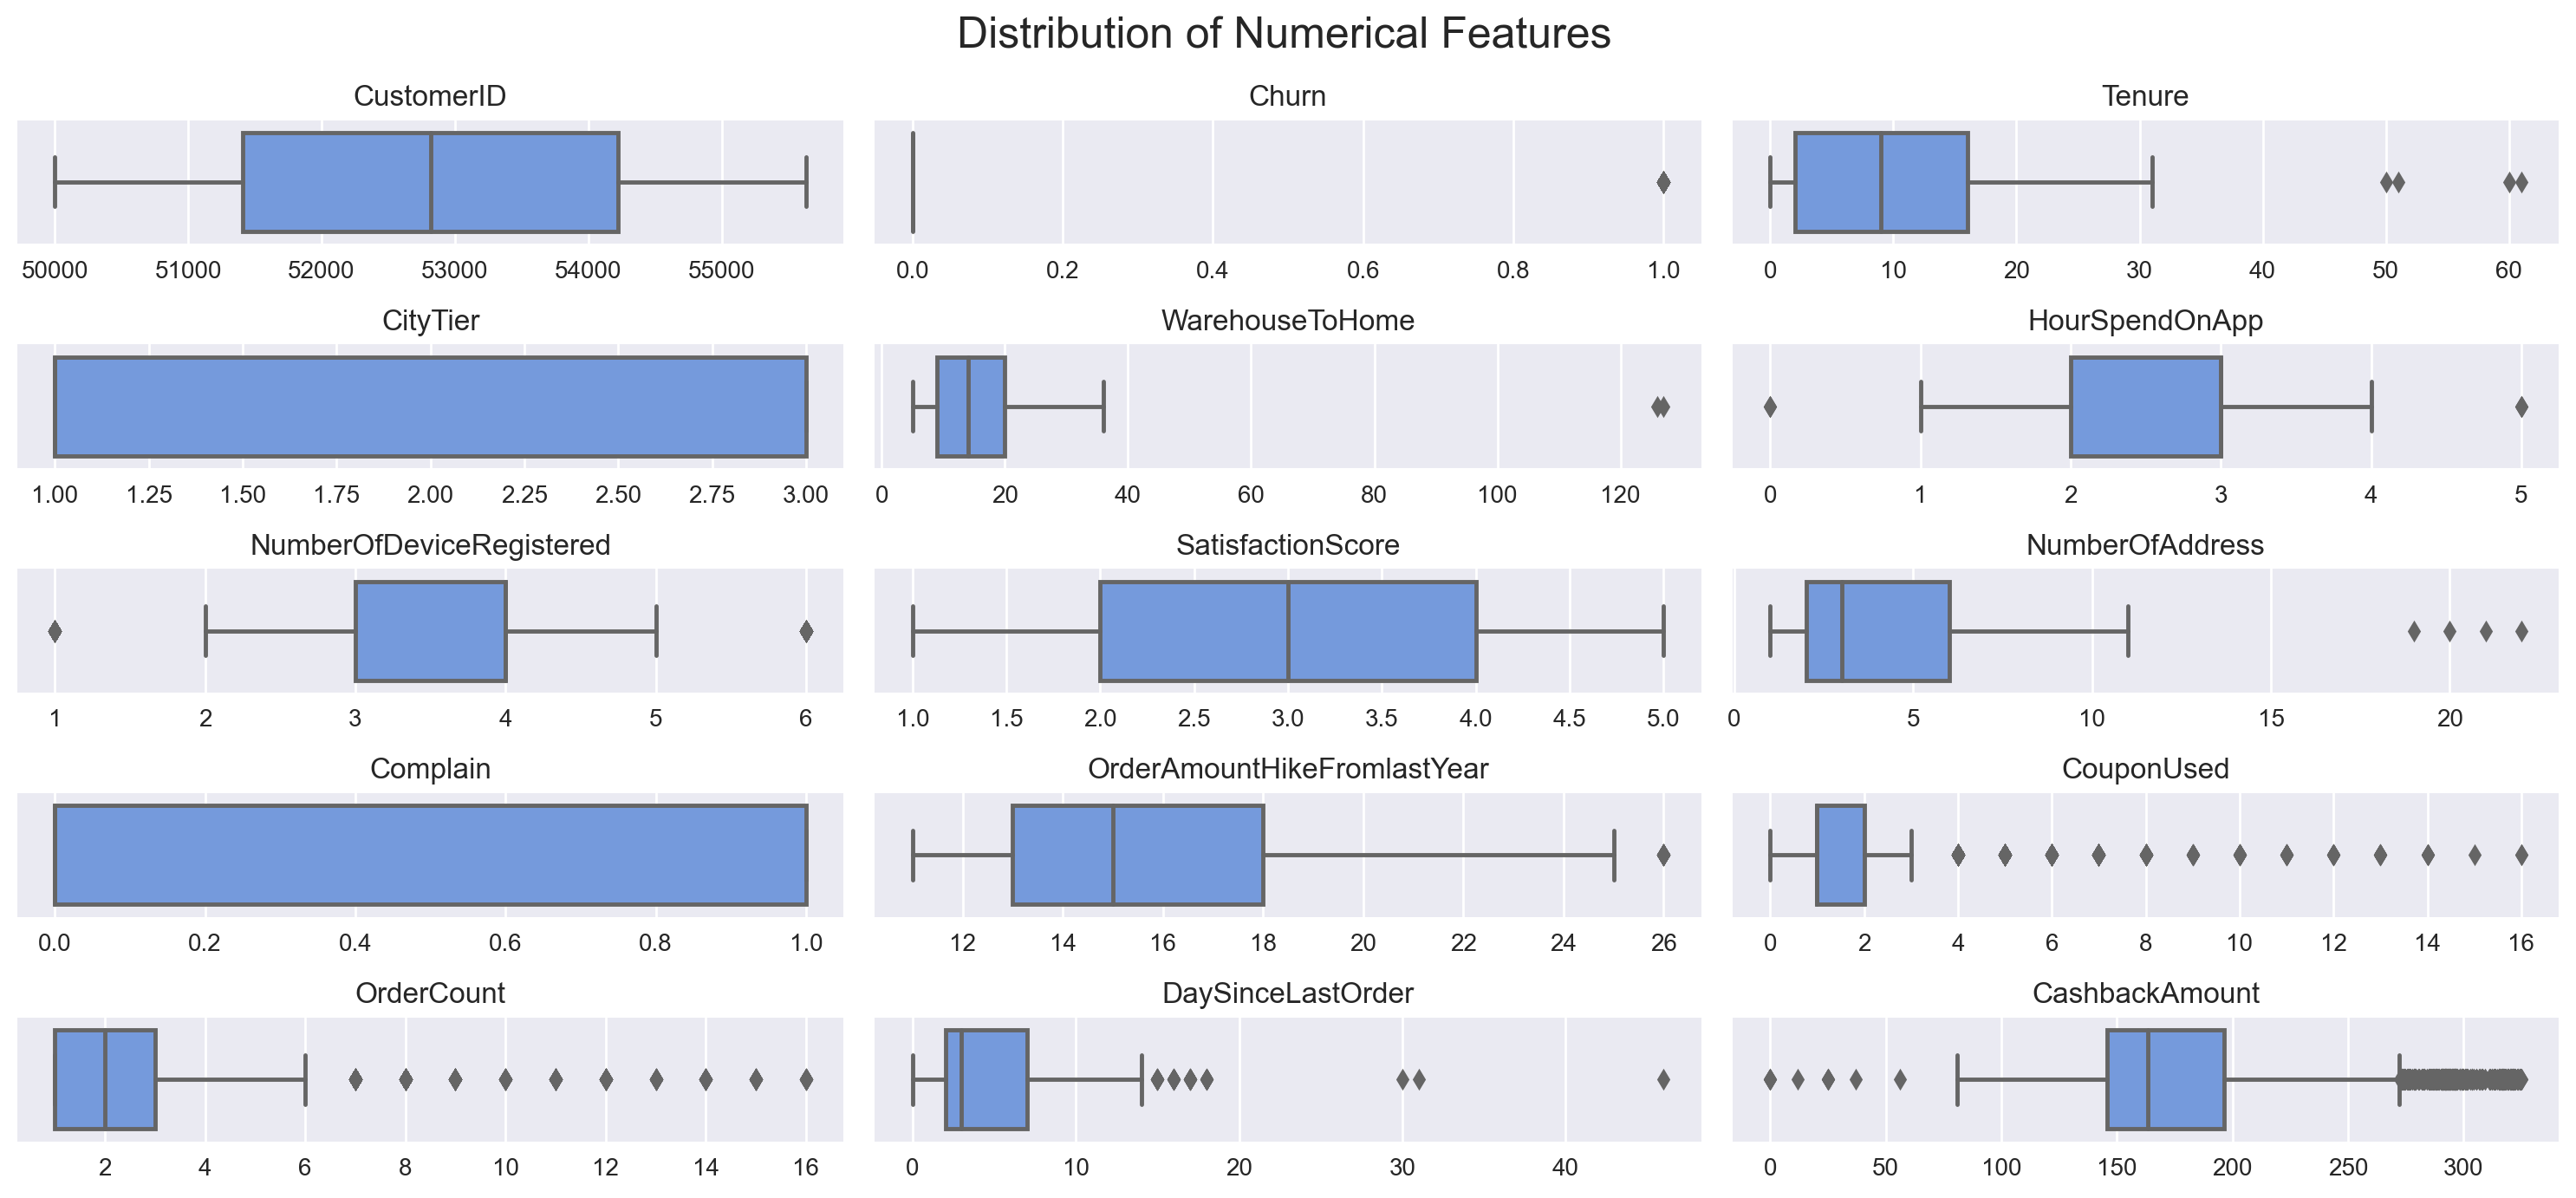

In [6]:
# define num cols
numerical_columns = data.select_dtypes(include='number')

# setup up figure size
plt.figure(figsize=(15, 7), dpi=200)
plt.suptitle('Distribution of Numerical Features', fontsize=18)

# check outliers using boxplots
for i, col in enumerate(numerical_columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=data[col], color='cornflowerblue', orient='v')
    plt.title(f'{col}')
    plt.xlabel(None)

plt.tight_layout()
plt.show()

**Note** 
- In general, the data in the majority of columns, except for `SatisfactionScore` and `CustomerID`, are not normally distributed. In addition to this general insight, most variables are also positively skewed as they have longer tails on the right side of the distributions.
    - In more specific, the positive skewness in `Tenure` indicates that customers tend to have relatively short tenure but there are some with long one. This can be seen by the position of the boxplot tending on the left side.
    - As seen on `HourSpendOnApp`, customers have varying levels of engagement due to the wide spread of the data. Here, outliers are present in both below the 25% percentile and above the 75% percentile, meaning that while there are some customers use the app for long time period, some others open the app in a very short time.
    - Data in `CashbackAmount` is slightly more skewed to the right despite the presence of outliers in in both sides (left and right). But it remains unclear how many outliers this variable. Furthermore, it seems the high amount of cashback some customers got is due to their purchasing behavior, especially their frequent orders (see code below).
    - Similar to `HourSpendOnApp`, the number of orders (`OrderCount`) also varies widely, meaning some customers (12%) appear to have more orders than the rest.
    - Next, it appears that some customers recently made purchases (`DaySinceLastOrder`) but some others are quite infrequent buyers.

In [7]:
# get records with max cashback amount
print(f"Max cashback amount: ${data['CashbackAmount'].max()}")
data[data['CashbackAmount'] == 324.99]

Max cashback amount: $324.99


CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
2880       52881      0    26.0         Mobile Phone         1   
4350       54351      0    26.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode Gender  HourSpendOnApp  \
2880              7.0           Debit Card   Male             4.0   
4350              7.0           Debit Card   Male             4.0   

      NumberOfDeviceRegistered PreferedOrderCat  SatisfactionScore  \
2880                         5           Others                  3   
4350                         5           Others                  3   

     MaritalStatus  NumberOfAddress  Complain  OrderAmountHikeFromlastYear  \
2880      Divorced                2         0                         15.0   
4350       Married                2         0                         15.0   

      CouponUsed  OrderCount  DaySinceLastOrder  CashbackAmount  
2880         2.0        12.0               10.0          324.99  
4350         8.0        12.0               10.0          324.99

### **2.2 Check Missing Values**

This subsection explores which mechanism of missingness best characterizes the missingness in our dataset so we can decide which treatment is suitable. Theoretically speaking, mechanisms or patterns of missing data can be broadly classified into 3 labels, namely missing at random, missing completely at random, and missing not at random ([Newman, 2014](https://journals.sagepub.com/doi/abs/10.1177/1094428114548590)). Different mechanisms will demand different treatment on missing values.
- **Missing completely at random** (MCAR): Missing data does not have any relation to other variables in the dataset (missing or observed) so the missingness is entirely by chance (no specific reason for missingness). For example, a customer misses filling in the gender section on their profile so column `Gender` is empty for that customer.
    - Because of its randomness, deletion or simple (univariate) imputation is usually enough to handle the missing values.
- **Missing at random** (MAR): The missingness in a column is caused by some known factor. For example, some rows in column `LastProductReview` are missing because the values in column `NumberOfReviews` are zeros. Since the missingness in column `LastProductReview` can be explained by `NumberOfReviews` (known factor), this situation is considered MAR.
    - If the missingness is MAR, multivariate imputation (e.g., MICE) or model-based imputation can be some options. But specific characteristics of the missingness should also be considered. For instance, it does not make sense to impute missing values in `LastProductReview` with MICE since the missing values are expected when no reviews were provided by the customers.
- **Missing not at random** (MNAR): Missing data is associated with the missing values themselves. For example, people with very high or low incomes might be less likely to report their income in a survey due to privacy concerns. As a consequence, the record will be empty, and the missing value is usually informative (hence 'related') on its own.
    - This mechanism of missingness can be handled by using data augmentation. Data augmentation involves generating synthetic data mimicking the observed distribution. For, missing data in income can be inputed by generating synthetic data that fits the patterns of reported income.

Now, let us recap which columns contain missing values and check the mechanism of missingness in the dataset by firstly investigating if there are any explicit patterns of missingness.

In [8]:
# check missing values
missing_values = data.isna().sum()
missing_values_percentage = data.isna().mean() * 100

missing_values_df = pd.DataFrame({
    'Count': missing_values,
    'Percentage': missing_values_percentage.round(3)
})
missing_values_df.index.name = 'Column'

# display in descending order
missing_values_df.sort_values(by='Count', ascending=False).reset_index()

Column  Count  Percentage
0             DaySinceLastOrder    307       5.453
1   OrderAmountHikeFromlastYear    265       4.707
2                        Tenure    264       4.689
3                    OrderCount    258       4.583
4                    CouponUsed    256       4.547
5                HourSpendOnApp    255       4.529
6               WarehouseToHome    251       4.458
7                    CustomerID      0       0.000
8                 MaritalStatus      0       0.000
9                      Complain      0       0.000
10              NumberOfAddress      0       0.000
11             PreferedOrderCat      0       0.000
12            SatisfactionScore      0       0.000
13                        Churn      0       0.000
14     NumberOfDeviceRegistered      0       0.000
15                       Gender      0       0.000
16         PreferredPaymentMode      0       0.000
17                     CityTier      0       0.000
18         PreferredLoginDevice      0       0.000
19               CashbackAmount      0       0.000

**Note**: As previously noted, columns `Tenure`, `WarehouseToHome`, `HourSpendOnApp`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, `DaySinceLastOrder`, column `DaySinceLastOrder` contain missing values. The missing value rates are between 4.4 and 5.4. 

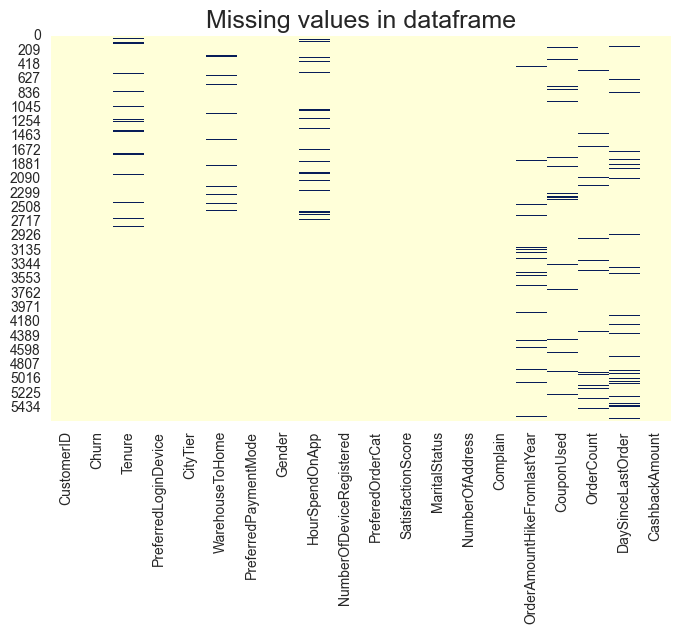

In [9]:
# check columns with missing values
plt.figure(figsize=(8,5))
sns.heatmap(data.isna(), cmap='YlGnBu', cbar=False)
plt.title('Missing values in dataframe', fontsize=18)
plt.show()

**Note**
- At glance, it seems that the missing values in column `Tenure`, `WarehouseToHome`, and `HourSpendOnApp` only appear in the beginning of the dataset but the missingness between columns doesn't look to correspond to each other. For example, if row ID 977 (see dataframe below) in column `WarehouseToHome` is missing, values in other columns are not.
- The other four variables, moreover, look random as each missing values appear in different rows. If a missing value in one variable is missing and that in another variable is also missing or have monotonous value (e.g., 0), we can tell that the missingness is systematic as they depend on another variables.
- Based on initial observations, the missingness mechanism in the dataset is suspected to be either MCAR or MAR. Further investigation is required to confirm this and to differentiate between the two.

In [10]:
# display three vars of interests
data.loc[:, ['Tenure', 'WarehouseToHome', 'HourSpendOnApp']].sample(n=10, random_state=42)

Tenure  WarehouseToHome  HourSpendOnApp
4331     1.0              7.0             4.0
1988    15.0              9.0             3.0
3443    13.0             29.0             3.0
4559     5.0              7.0             4.0
4898    13.0              7.0             4.0
4641     8.0              7.0             3.0
2117    29.0             15.0             NaN
3268    12.0              9.0             4.0
977      9.0              NaN             3.0
1115    12.0              6.0             3.0

In [11]:
# show all cols with missing values
data[data.columns[data.isna().any()]].sample(10, random_state=42)

Tenure  WarehouseToHome  HourSpendOnApp  OrderAmountHikeFromlastYear  \
4331     1.0              7.0             4.0                         22.0   
1988    15.0              9.0             3.0                         13.0   
3443    13.0             29.0             3.0                         14.0   
4559     5.0              7.0             4.0                         13.0   
4898    13.0              7.0             4.0                         17.0   
4641     8.0              7.0             3.0                         14.0   
2117    29.0             15.0             NaN                         19.0   
3268    12.0              9.0             4.0                         13.0   
977      9.0              NaN             3.0                         21.0   
1115    12.0              6.0             3.0                         15.0   

      CouponUsed  OrderCount  DaySinceLastOrder  
4331         2.0         2.0                1.0  
1988         1.0         1.0                3.0  
3443         2.0         NaN                9.0  
4559         4.0         4.0                3.0  
4898        10.0         NaN                9.0  
4641         2.0         2.0                4.0  
2117         1.0         1.0                3.0  
3268         5.0         5.0               13.0  
977          0.0         1.0                2.0  
1115         3.0         5.0                8.0

**Note**
- When checking all columns containing missing values, there also seem to be no apparent or explicit patterns in the missing values between variables. What is meant by "explicit" is when a value in one variable is empty (`NaN`), a missing value in another variable will be empty too or have monotonous values. Or else, the patterns of missingness are not in the surface level so a deeper check should be done.
- Moreover, as can be seen only numerical features contain missing values. Categorical columns and target variables all contain complete cases.
- For testing whether the mechanism of missingness is MCAR or not, we use Little's MCAR test ([Little, 1988](https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722)). In Little's MCAR test, the $H_0$ is missing data is completely at random, and if the *p*-value is lower than the alpha at 0.05, we can reject the null hypothesis ($H_0$).

In [12]:
from pyampute.exploration.mcar_statistical_tests import MCARTest

# perform Little's MCAR test
mt = MCARTest(method='little')
lm_result = mt.little_mcar_test(data[data.columns[data.isna().any()]])

# perform hypothesis testing
if lm_result > 0.05:
    print(f'The p-value is {lm_result:.4f}')
    print('We cannot reject Missing Completely at Random (MCAR).')
    print('However, this does not confirm MCAR. Further exploration is needed.')
else:
    print(f'The p-value is {lm_result:.4f}')
    print('Missing data is likely not Missing Completely at Random (MCAR)')

The p-value is 0.0000
Missing data is likely not Missing Completely at Random (MCAR)


**Note**
- As the *p*-value is lower than the alpha at 0.05, then we reject the null hypothesis for MCAR (Missing Completely At Random). 
- The mechanism is more likely to be Missing At Random (MAR) in which missingness can be explained by variables observed in dataset. 
- And as we already identified the mechanism of missingness is MAR, we can consider Multiple Imputation with Chained Equation (MICE).
- Furthermore, to addresss the missingness with such characteristic, Multiple Imputation with Chained Equation (MICE, [van Buuren & Groothuis-Oudshoorn, 2011](https://doi.org/10.18637/jss.v045.i03)) can be an option. 
    - This method is more considered than, for example, using constant value imputation or univariate imputation (mean or median imputation) as the missing values not random. 
- In simple language, MICE predicts missing values by considering the relationship between the variable, where the missing values are in, and other variables. Afterwards, MICE will impute the predicted values iteratively to the missing values.

In [13]:
# copy dataset
df = data.copy()

# select cols with missing values
numeric_cols = data.columns[data.isna().any()]
df_numeric = df[numeric_cols]

# apply MICE imputation to the numeric columns
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), 
                                  columns=df_numeric.columns)

# add the imputed values back into the original df
df[numeric_cols] = df_imputed_numeric

In [14]:
# check missing values
df.isna().sum().reset_index(name='count')

index  count
0                    CustomerID      0
1                         Churn      0
2                        Tenure      0
3          PreferredLoginDevice      0
4                      CityTier      0
5               WarehouseToHome      0
6          PreferredPaymentMode      0
7                        Gender      0
8                HourSpendOnApp      0
9      NumberOfDeviceRegistered      0
10             PreferedOrderCat      0
11            SatisfactionScore      0
12                MaritalStatus      0
13              NumberOfAddress      0
14                     Complain      0
15  OrderAmountHikeFromlastYear      0
16                   CouponUsed      0
17                   OrderCount      0
18            DaySinceLastOrder      0
19               CashbackAmount      0

**Note**
- MICE has been applied to the missing data imputation, and as can be seen, no variables contain missing values anymore. 
- However, one task left: We need to evaluate to what extent the data imputation affects the data. Below, we conduct a descriptive statistical test to evaluate if there is any substantial difference between before and after the imputation.

In [15]:
# evaluate quality of imputation technique
cols = data.columns[data.isna().any()]
original_summary = data[cols].describe()
imputed_summary = df[cols].describe()

# display result
print(f'Cols containing missing values: \n{cols}\n')
print("Original Data Summary:")
display(original_summary.round(3))
print("\nImputed Data Summary:")
display(imputed_summary.round(3))

Cols containing missing values: 
Index(['Tenure', 'WarehouseToHome', 'HourSpendOnApp',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder'],
      dtype='object')

Original Data Summary:


Tenure  WarehouseToHome  HourSpendOnApp  OrderAmountHikeFromlastYear  \
count  5366.000         5379.000        5375.000                     5365.000   
mean     10.190           15.640           2.932                       15.708   
std       8.557            8.531           0.722                        3.675   
min       0.000            5.000           0.000                       11.000   
25%       2.000            9.000           2.000                       13.000   
50%       9.000           14.000           3.000                       15.000   
75%      16.000           20.000           3.000                       18.000   
max      61.000          127.000           5.000                       26.000   

       CouponUsed  OrderCount  DaySinceLastOrder  
count    5374.000    5372.000           5323.000  
mean        1.751       3.008              4.543  
std         1.895       2.940              3.654  
min         0.000       1.000              0.000  
25%         1.000       1.000              2.000  
50%         1.000       2.000              3.000  
75%         2.000       3.000              7.000  
max        16.000      16.000             46.000


Imputed Data Summary:


Tenure  WarehouseToHome  HourSpendOnApp  OrderAmountHikeFromlastYear  \
count  5630.000         5630.000        5630.000                     5630.000   
mean     10.133           15.631           2.929                       15.713   
std       8.361            8.340           0.706                        3.589   
min       0.000            5.000           0.000                       11.000   
25%       3.000            9.000           2.000                       13.000   
50%       9.000           14.000           3.000                       15.000   
75%      15.000           20.000           3.000                       18.000   
max      61.000          127.000           5.000                       26.000   

       CouponUsed  OrderCount  DaySinceLastOrder  
count    5630.000    5630.000           5630.000  
mean        1.790       3.065              4.605  
std         1.922       2.952              3.612  
min         0.000       0.253              0.000  
25%         1.000       1.000              2.000  
50%         1.000       2.000              3.221  
75%         2.000       3.000              7.000  
max        16.000      17.166             46.000

**Note**
- The two dataframes display the outputs of before and after data imputation using descriptive statistics.
- In general, after the applying MICE to the dataset, the characteristics of each variable do not change much. This is expected as the data imputation must not substantially change the distribution of the data. 
- The most apparent changes are in the mean of `Tenure` and min values of `OrderCount` which slightly changed for both variables.
- Additionally, as the missing values have been addressed, the clean version of dataframes, i.e., `df` will be used onwards.

### **2.3 Check Outliers**

During checking data distribution using histograms, it was shown that some outliers are present in some variables. This section is a follow-up on this issue. The outlier identification is done by exploiting interquartile range (IQR). This statistical test is considered as it is less sensitive to extreme values. Its robustness to outliers lies on the fact that it uses quartiles (Q3-Q1), instead of mean and standard deviation in z-score test for outlier detection. This IQR-based outlier detection also does not assume a normal distribution for the data, making it more flexible.

While for the data analysis (Section 3) we do not carry out outlier treatment, this checking will be pivotal for our predictive modeling to avoid inaccurate predictions, i.e., model's bias towards the extreme values. For Section 3, as the outliers represent genuine, extreme cases in the business, handling them, e.g., using winsorization, removal, or transformation, will be unrealistic. A treatment to such cases will provide a misleading result as our analysis is concerned with a volatile customer behavior in the e-commerce platform, potentially leading to churns.

In [16]:
# create function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{column}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

In [17]:
# specify cols for outlier check
numerical_columns = ['Tenure', 'CityTier', 'WarehouseToHome',
                     'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',               
                     'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
                     'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# perform outlier check
for col in df[numerical_columns]:
    detect_outliers(df, col)

The number of outliers in 'Tenure' is 4 or 0.07% of the total data (5630 rows).
The number of outliers in 'CityTier' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'WarehouseToHome' is 2 or 0.04% of the total data (5630 rows).
The number of outliers in 'HourSpendOnApp' is 6 or 0.11% of the total data (5630 rows).
The number of outliers in 'NumberOfDeviceRegistered' is 397 or 7.05% of the total data (5630 rows).
The number of outliers in 'SatisfactionScore' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'NumberOfAddress' is 4 or 0.07% of the total data (5630 rows).
The number of outliers in 'Complain' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'OrderAmountHikeFromlastYear' is 33 or 0.59% of the total data (5630 rows).
The number of outliers in 'CouponUsed' is 700 or 12.43% of the total data (5630 rows).
The number of outliers in 'OrderCount' is 755 or 13.41% of the total data (5630 rows).
The number of outliers 

**Note**
- There are 10 variables containing missing values, namely `Tenure`, `WarehouseToHome`, `HourSpendOnApp`, `NumberOfDeviceRegistered`, `NumberOfAddress`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, `DaySinceLastOrder`, and `CashbackAmount`.
- Those variables have varying rates of outliers, ranging between 0.07% and 13.48%. 
- Variables such as `NumberOfDeviceRegistered` (7.05%), `CouponUsed` (11.17%), `OrderCount` (13.48%), and `CashbackAmount` (7.78%) have considerable numbers of outliers.
- To deal with these outliers, for our analysis, we will use statistical tests which are less sensitive to outliers. For example, to compare a specific difference between churned and non-churned customers, we can use Mann-Whitney *U* test. And Spearman's $\rho$ can also be exploited to check the direction and strength of a correlation between two numerical variable of interest. As we will argue later, these non-parametric tests are more robust to outliers since they focus on ranks or positions of values, not values themselves as used in parametric tests. 
- For out predictive modeling, different options are available but judging from some variables with small outlier rates, winsorization will be a viable option since this method can reduce the impact of outliers on the dataset without losing the size of data considering the dataset only contains 5630 rows. 
- Outlier removal in this situation is not an ideal option as it will decrease the size of data which potentially influences the statistical power or model's performance. 
- Now let us demonstrate how winsorization will affect the outliers. And as a disclaimer, this is only for a demonstration purpose to justify our selection of winsorization in the predictive modeling section. We store the output of the winsorization to another dataframe so that the technique will not influence our dataframe for the analysis.

In [18]:
from scipy.stats.mstats import winsorize

# specify cols to winsorize
col_to_winsorize = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                    'NumberOfDeviceRegistered', 'NumberOfAddress', 
                    'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 
                    'OrderCount', 'CouponUsed',
                    'CashbackAmount']  

# create function to winsorize extreme values
def apply_winsorization(df, columns, lower_limit=0.5, upper_limit=0.95):
    df_winsorized = df.copy()  
    
    for col in columns:
        # apply winsorization to each column
        df_winsorized[col] = winsorize(df[col], limits=[lower_limit, upper_limit])
    
    return df_winsorized

# perform winsorization
winsorided_data = apply_winsorization(df.copy(), col_to_winsorize)

# evaluate winsorization result
for col in df[col_to_winsorize]:
    detect_outliers(winsorided_data, col)

The number of outliers in 'Tenure' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'WarehouseToHome' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'HourSpendOnApp' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'NumberOfDeviceRegistered' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'NumberOfAddress' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'OrderAmountHikeFromlastYear' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'DaySinceLastOrder' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'OrderCount' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'CouponUsed' is 0 or 0.00% of the total data (5630 rows).
The number of outliers in 'CashbackAmount' is 0 or 0.00% of the total data (5630 rows).


**Note**: 
- A winsorization technique has been carried out on the dataset. 
- We used 5% as the lower and 95% as the upper limit of the winsorization. These thresholds seem to be able to handle outliers properly so we will proceed with winsorization for our predictive modeling.

### **2.4 Check Inconsistent Values**

As the dataset has categorical columns, it is essential to find out whether there are inconsistent values in the categorical columns. For example, value `NY`, `New York`, `ny`, and `new york` in column `State` refer to the same geopolitical entity. For this reason, they should have been represented by the same label to denote to the same referent. To deal with such problem, we can check the number of unique values in each categorical column to identify the potential inconsistent values, and change them into one label afterwards.

In [19]:
# check cardinality
(df.select_dtypes(include=['object'])
 .nunique()
 .reset_index()
 .rename(columns={0:'count'}))

index  count
0  PreferredLoginDevice      3
1  PreferredPaymentMode      7
2                Gender      2
3      PreferedOrderCat      6
4         MaritalStatus      3

In [20]:
# check cols with high nunique
print(df['PreferredLoginDevice'].unique())
print(df['PreferedOrderCat'].unique())
print(df['PreferredPaymentMode'].unique())

['Mobile Phone' 'Phone' 'Computer']
['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']


**Note**
- Prior to checking inconsistent formatting, we conducted cardinality check because variables with higher unique values are more likely to contain inconsistent labels.
- As shown above, for column `PreferredOrderCat`, there are 6 categories, and `PreferredPaymentMode` has 7. 
    - `PreferredOrderCat`: Label `Mobile` and `Mobile Phone` seem to referring to the same entities so we regularize the labels into `Mobile Phone` for maintaining consistency.
    - `PreferredPaymentMode`: Two pairs of ambiguities are found: `COD` vs `Cash on Delivery` and `CC` vs `Credit Card`. For maintaining consistency and clarity, the ambiguities will be resolved by changing `COD` to `Cash on Delivery` and `CC` to `Credit Card`. <span style='color:red'>GANTI</span>

In [21]:
# replace values
df['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'}, inplace=True)
df['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'}, inplace=True)
df['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'}, inplace=True)

In [22]:
# double check outputs
print(df['PreferredLoginDevice'].unique())
print(df['PreferedOrderCat'].unique())
print(df['PreferredPaymentMode'].unique())

['Mobile Phone' 'Computer']
['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']


### **2.5 Check Cardinality**
A high number of unique values in a catagorical feature will pose a challenge to a machine learning model, particularly causing difficulty in handling rare cases (small unique values). For this reason, we check potential high cardinalty in our dataset.

In [23]:
pd.DataFrame({
    'ColumnName': df.select_dtypes(include='O').columns.values.tolist(),
    'Nrow': df.select_dtypes(include='O').shape[0],
    'UniqueValue': df.select_dtypes(include='O').nunique().tolist(),
})

ColumnName  Nrow  UniqueValue
0  PreferredLoginDevice  5630            2
1  PreferredPaymentMode  5630            5
2                Gender  5630            2
3      PreferedOrderCat  5630            5
4         MaritalStatus  5630            3

In [24]:
# check rare labels using threshold at 1%
rare_labels = {column: (df[column].value_counts() < (0.01 * len(df))).sum() 
               for column in df.select_dtypes(include=['object']).columns}
rare_labels

{'PreferredLoginDevice': 0,
 'PreferredPaymentMode': 0,
 'Gender': 0,
 'PreferedOrderCat': 0,
 'MaritalStatus': 0}

**Note**
- No columns with high cardinality were found. All categorical columns contain less than 10 unique values (see dataframe above).
- In addition, using threshold at 0.01 (or 1%, arbitrary value) for identifying rare labels, we did not find any rare labels.
- For this reason, no treatment is required. However, even if there are rare labels in the categorical features, one possible way to address this rarity issue is by changing labels with the occurrence rate below the threshold into 'Others'.

### **2.5 Export Clean Dataset**

In [25]:
# export dataframe for external uses
df.to_csv('../data/clean_data_with_updated_values.csv', index=False)

In [26]:
# exported dataset
print('Exported data:')
display(df.describe().round(2).transpose())

# imported dataset
print('\nImported data:')
test = pd.read_csv('../data/clean_data_with_updated_values.csv')
display(test.describe().round(2).transpose())

Exported data:


count      mean      std       min       25%  \
CustomerID                   5630.0  52815.50  1625.39  50001.00  51408.25   
Churn                        5630.0      0.17     0.37      0.00      0.00   
Tenure                       5630.0     10.13     8.36      0.00      3.00   
CityTier                     5630.0      1.65     0.92      1.00      1.00   
WarehouseToHome              5630.0     15.63     8.34      5.00      9.00   
HourSpendOnApp               5630.0      2.93     0.71      0.00      2.00   
NumberOfDeviceRegistered     5630.0      3.69     1.02      1.00      3.00   
SatisfactionScore            5630.0      3.07     1.38      1.00      2.00   
NumberOfAddress              5630.0      4.21     2.58      1.00      2.00   
Complain                     5630.0      0.28     0.45      0.00      0.00   
OrderAmountHikeFromlastYear  5630.0     15.71     3.59     11.00     13.00   
CouponUsed                   5630.0      1.79     1.92      0.00      1.00   
OrderCount                   5630.0      3.06     2.95      0.25      1.00   
DaySinceLastOrder            5630.0      4.61     3.61      0.00      2.00   
CashbackAmount               5630.0    177.22    49.21      0.00    145.77   

                                  50%       75%       max  
CustomerID                   52815.50  54222.75  55630.00  
Churn                            0.00      0.00      1.00  
Tenure                           9.00     15.00     61.00  
CityTier                         1.00      3.00      3.00  
WarehouseToHome                 14.00     20.00    127.00  
HourSpendOnApp                   3.00      3.00      5.00  
NumberOfDeviceRegistered         4.00      4.00      6.00  
SatisfactionScore                3.00      4.00      5.00  
NumberOfAddress                  3.00      6.00     22.00  
Complain                         0.00      1.00      1.00  
OrderAmountHikeFromlastYear     15.00     18.00     26.00  
CouponUsed                       1.00      2.00     16.00  
OrderCount                       2.00      3.00     17.17  
DaySinceLastOrder                3.22      7.00     46.00  
CashbackAmount                 163.28    196.39    324.99


Imported data:


count      mean      std       min       25%  \
CustomerID                   5630.0  52815.50  1625.39  50001.00  51408.25   
Churn                        5630.0      0.17     0.37      0.00      0.00   
Tenure                       5630.0     10.13     8.36      0.00      3.00   
CityTier                     5630.0      1.65     0.92      1.00      1.00   
WarehouseToHome              5630.0     15.63     8.34      5.00      9.00   
HourSpendOnApp               5630.0      2.93     0.71      0.00      2.00   
NumberOfDeviceRegistered     5630.0      3.69     1.02      1.00      3.00   
SatisfactionScore            5630.0      3.07     1.38      1.00      2.00   
NumberOfAddress              5630.0      4.21     2.58      1.00      2.00   
Complain                     5630.0      0.28     0.45      0.00      0.00   
OrderAmountHikeFromlastYear  5630.0     15.71     3.59     11.00     13.00   
CouponUsed                   5630.0      1.79     1.92      0.00      1.00   
OrderCount                   5630.0      3.06     2.95      0.25      1.00   
DaySinceLastOrder            5630.0      4.61     3.61      0.00      2.00   
CashbackAmount               5630.0    177.22    49.21      0.00    145.77   

                                  50%       75%       max  
CustomerID                   52815.50  54222.75  55630.00  
Churn                            0.00      0.00      1.00  
Tenure                           9.00     15.00     61.00  
CityTier                         1.00      3.00      3.00  
WarehouseToHome                 14.00     20.00    127.00  
HourSpendOnApp                   3.00      3.00      5.00  
NumberOfDeviceRegistered         4.00      4.00      6.00  
SatisfactionScore                3.00      4.00      5.00  
NumberOfAddress                  3.00      6.00     22.00  
Complain                         0.00      1.00      1.00  
OrderAmountHikeFromlastYear     15.00     18.00     26.00  
CouponUsed                       1.00      2.00     16.00  
OrderCount                       2.00      3.00     17.17  
DaySinceLastOrder                3.22      7.00     46.00  
CashbackAmount                 163.28    196.39    324.99

### **2.6 Conclusions**
In short, in this section, we already performed a series of data cleaning techniques, especially for missing values treatment and outlier deetection. The data cleaning here is primarily aimed for preparing data for an analysis on churns. Nonetheless, it is noteworthy that as the general purposes of data analysis and modeling are different, only basic data preprocessing was done. No pipelines or feature engineering techniques for numerical rescaling, imbalance treatment on the target feature, or encoding were applied.


## **3 Exploratory Data Analysis**

As discussed earlier in the Section 1, the ultimate goal is to decrease customer churn, and to this end, we firstly need to identify the characteristics of customers who churned. This identification will shed light on the possible contributing factors of the churn, and enable the Customer Success Manager as the key stakeholder of this project to take necessary action to mitigate the business impacts of the customer churn. This section explores the dataset by relating every feature (both categorical and numerical) to the target variable, i.e., `Churn`. By associating the features to `Churn` and comparing each feature based on the customer churn status (churn vs non-churn), it is expected to gain an understanding of the customers' characteristics who no longer make any purchases in the e-commerce platform.

To make this section more structured, we mainly divide Section 3 into two groups based on the broad data types: categorical and numerical features. The division will be further detailed by using questions to guide the analysis. However, before moving on to the first subsection, we will check out the overall churn rate in the e-commerce company as this will be the starting point for our analysis and data modeling, i.e., the overall churn rate in the e-commerce company.
- **Categorical features**
    - Q1: Which login device do churners generally prefer?
    - Q2: Are there any preferred payment mode the churners have?
    - Q3: What gender category are the churners?
    - Q4: Are those churners mostly single?
    - Q5: Do churners have any preference in terms of order category?
- **Numerical features**
    - Q1: Are there any features highly correlated with churns?
    - Q2: To what extent churning customers and loyal customers are different in terms of their purchasing behaviors?

In [27]:
# get churn rate
target_col = pd.DataFrame({'count':df['Churn'].value_counts(),
                           'proportion':round(df['Churn'].value_counts(normalize=True) *100, 2)})
display(target_col)

count  proportion
0   4682       83.16
1    948       16.84

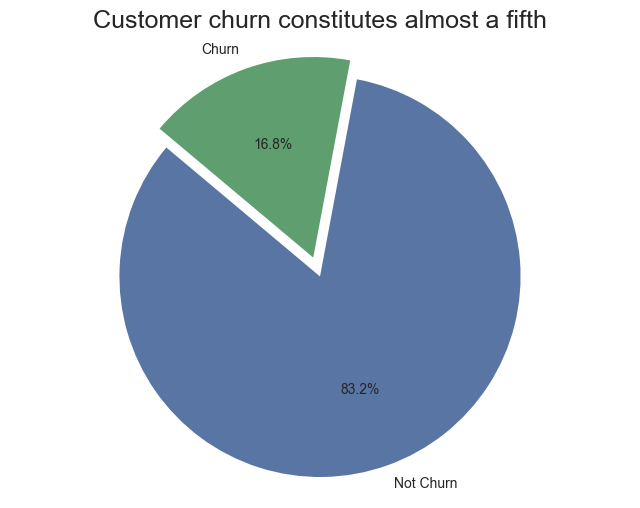

In [28]:
# display pie chart
labels = ['Not Churn', 'Churn']
sizes = target_col['count']
color = ['#5975a4', '#5f9e6e']
explode = (0, 0.1) 

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=color, autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')  
plt.title('Customer churn constitutes almost a fifth', loc='center', fontsize=18)
plt.show()

**Note**
- In general, the number of customers who no longer make purchase is almost a fifth (16.84%) of the total customers in the e-commerce company. 
- For a comparison, the average customer churn rate in online retails or e-commerce in the US is 22% ([Statista, 2022](https://www.statista.com/statistics/816735/customer-churn-rate-by-industry-us/)). Despite lower than that in the US, this number is alarming as it is closer to the average. To mitigate the negative impacts of the customer churn, the company should take an action to lower the churn rate. Losing 16.8% of customers, greater than the churn rate in our simulation in the Section 1.1, can significantly affect the revenue of the company if the company does not address the underlying issue. 
- One reasonable question to explore more is whether the churn has something to do with customer satisfaction (`SatisfactionScore`) and complaints (`Complain`) as more satisied users and fewer complaints are generally expected to have lower churns.
- This exploration will be carried out in section 3.2 since both variables are numerical by default.

### **3.1 Categorical Features**
This section is concerned about how customer churn is related to different categorical variables in dataset. This section is structured in this way: We firstly show the count of each categories by churn status to get the overview of the feature, specifically about how customer churn varies across categories. Nonetheless, since simple count into only provides us with an incomplete story, we incorporate churn rate per category in a feature to give us a better understanding the churn risk. Afterwards, we conduct a chi-square test to determine if there is a significant statistical relationship between the churn status and the categorical variables. If the statistical test shows a significant association, it means there is a notable relationship between customer churn and the category in question. This insight helps us identify which categories are more prone to churn, allowing us to implement targeted strategies to address these specific areas and potentially reduce overall churn rates.

#### **Q1. Which login device do churners generally prefer?**
To answer this question, we will begin by examining the simple count of preferred login devices among churners and non-churners. Additionally, we will also calculate the churn rate for each preferred login device. Following this descriptive analysis, we will perform a chi-square ($\chi^2$) test of independence to determine if there is a statistically significant relationship between `PreferredLoginDevice` and `Churn`. This test will help us understand whether these two variables are related.

In [29]:
churn_device_df = (df.groupby(['Churn', 'PreferredLoginDevice'])
                   .agg(func={'PreferredLoginDevice':'count'})
                   .rename(columns={'PreferredLoginDevice':'Count'})
                   .reset_index()
                   .sort_values(by='Count', ascending=False))

churn_device_df

Churn PreferredLoginDevice  Count
1      0         Mobile Phone   3372
0      0             Computer   1310
3      1         Mobile Phone    624
2      1             Computer    324

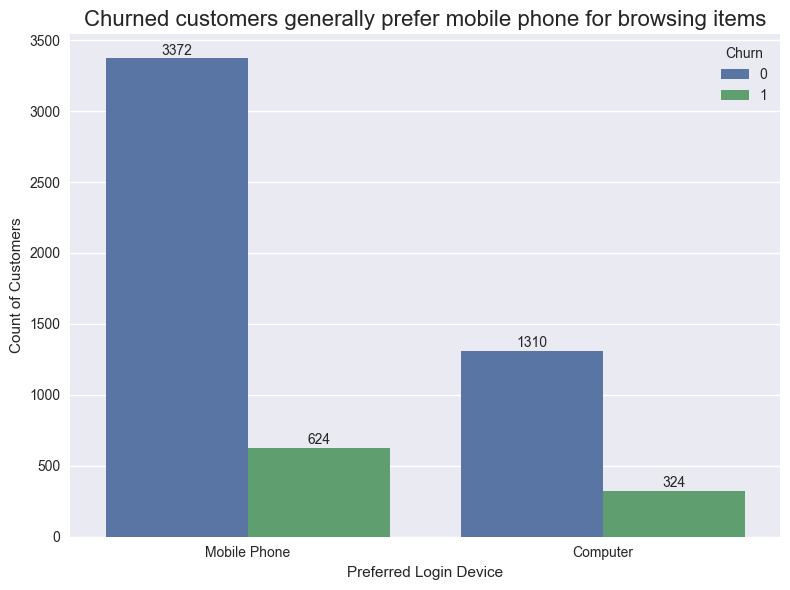

In [30]:
plt.figure(figsize=(8, 6))
plot1 = sns.barplot(x='PreferredLoginDevice', y='Count', hue='Churn', data=churn_device_df)

# add labels
for bar in plot1.patches:
  height = bar.get_height()
  label_text = int(height)                      # extract count value from bar height
  x_pos = bar.get_x() + bar.get_width() / 2     # center label horizontally
  y_pos = height + 5                            # adjust vertical position slightly above bar
  plot1.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=10)

plt.xlabel('Preferred Login Device')
plt.ylabel('Count of Customers')
plt.title('Churned customers generally prefer mobile phone for browsing items', fontsize=16)
plt.xticks(rotation=0, ha='center')  
plt.tight_layout()
plt.show()

In [31]:
# calculate total customers per login device (churned + non-churned)
total_customers = churn_device_df.groupby('PreferredLoginDevice')['Count'].sum()

# calculate churned customers per login
churned_customers = churn_device_df[churn_device_df['Churn'] == 1.0].set_index('PreferredLoginDevice')['Count']

# calculate rate
churn_rate = (churned_customers / total_customers * 100).reset_index(name='rate').round(2)

print('Churn rate by preferred login device:')
display(churn_rate.sort_values(by='rate', ascending=False))

Churn rate by preferred login device:


PreferredLoginDevice   rate
0             Computer  19.83
1         Mobile Phone  15.62

**Note**
- Churners generally prefer using `Mobile Phone` over `Computer` (624 vs 324) for browsing on the e-commerce platform. With these simple counts, it means approximately 65% of churners use `Mobile Phone` as their preferred login device whereas about 34% of churners use `Computer`. 
- While this insight has answered our question directly, we also need take into account the churn rate based on the preferred login device. Higher preference on a specific device does not always indicate higher churn risk. As a consequence, we need to compute the churn rate based on the login device too.
- As seen on the dataframe above, while mobile phones are the most preferred devices, computer users are more likely to churn (churn rate: 19.83) in comparison to the mobile phone users with churn rate of 15.62.
- To understand the computer behaviors who churned further, we can utilize platform related variables, namely `NumberOfDeviceRegistered` and `HourSpendOnApp`.

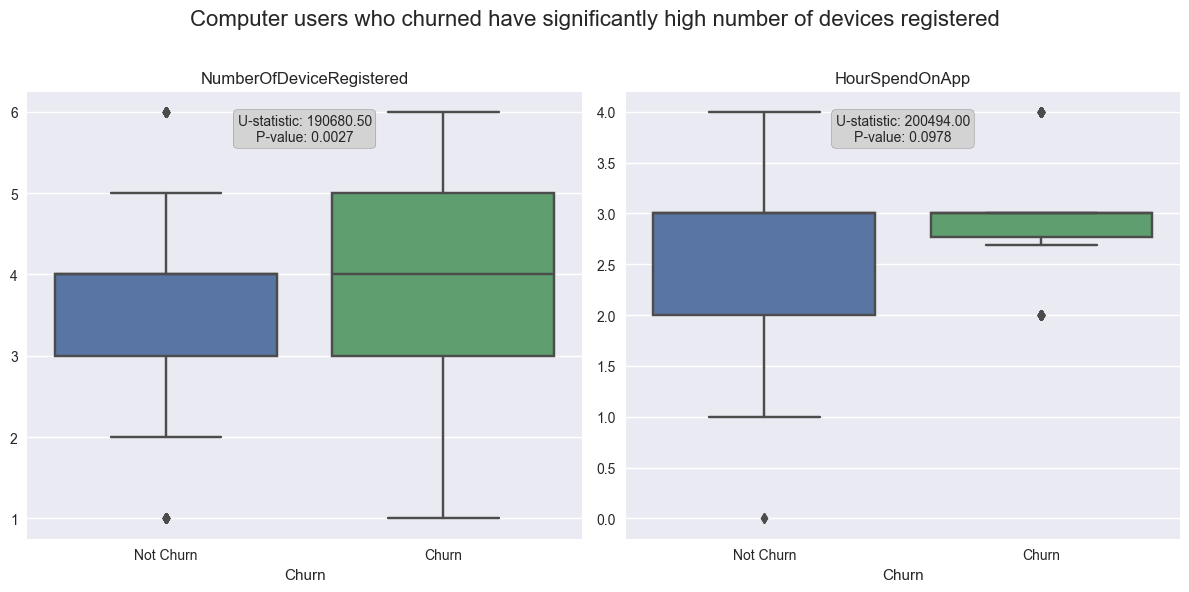

In [32]:
# Filter data for computer users
computer_users = df[df['PreferredLoginDevice'] == 'Computer']

# Define factors to visualize
factors = ['NumberOfDeviceRegistered', 'HourSpendOnApp']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
fig.suptitle('Computer users who churned have significantly high number of devices registered', fontsize=16)

# Plot each factor with Mann-Whitney U test
for i, factor in enumerate(factors):
    ax = axes[i]
    sns.boxplot(x='Churn', y=factor, data=computer_users, ax=ax)
    ax.set_xticklabels(['Not Churn', 'Churn'])
    ax.set_ylabel(None)
    ax.set_title(factor)
    
    # Perform Mann-Whitney U test
    churned = computer_users[computer_users['Churn'] == 1][factor]
    not_churned = computer_users[computer_users['Churn'] == 0][factor]
    stat, p_value = mannwhitneyu(not_churned, churned)
    
    # Annotate the plot with the test results
    ax.text(0.5, 0.95, f'U-statistic: {stat:.2f}\nP-value: {p_value:.4f}',
            transform=ax.transAxes, ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='lightgray'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Note**: Computer users who churn tend to register more devices, with a mean of 3.86 compared to 3.69 for non-churning users. However, the hours spent on the app do not show a significant difference between churning and non-churning users, indicating that the number of devices registered is a more distinguishing factor for churn among computer users.

In [33]:
# get desc stats for comp users 
(df[df['PreferredLoginDevice'] == 'Computer']
 .groupby('Churn')
 .agg(func={'NumberOfDeviceRegistered':'describe', 'HourSpendOnApp':'describe'})
 .round(2))

NumberOfDeviceRegistered                                       \
                         count  mean   std  min  25%  50%  75%  max   
Churn                                                                 
0                       1310.0  3.69  1.00  1.0  3.0  4.0  4.0  6.0   
1                        324.0  3.86  1.12  1.0  3.0  4.0  5.0  6.0   

      HourSpendOnApp                                        
               count  mean   std  min   25%  50%  75%  max  
Churn                                                       
0             1310.0  2.89  0.73  0.0  2.00  3.0  3.0  4.0  
1              324.0  2.98  0.68  2.0  2.77  3.0  3.0  4.0

In short, we found that even though computer is less preferred login devices by churners, those who use computers for logging in to their account and browse items on the platform have higher churn risk. After checking their app usage behavior, it was identified that computer users substantially have more registered devices. 

While this information is useful on its own, we can also supplement the finding with an independence test. This statistical test helps us examine whether or not `PreferredLoginDevice` is significantly associated with `Churn`. 

In [34]:
# crosstab Churn and PreferredLoginDevice
contingency_table = pd.crosstab(df['Churn'], df['PreferredLoginDevice'])

# perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof:.4f}")

Chi-Square Statistic: 14.4013
P-Value: 0.0001
Degrees of Freedom: 1.0000


**Note**
- Chi-Square test indicates that there is a statistically significant association between the `Churn` and the `PreferredLoginDevice` ($\chi^2$(1, *N* = 5630) = 14.40, *p* < 0.05.). 
- The significant association suggests that the device customers use to log in might be related to their likelihood of churning. For example, if more churned customers prefer a specific login device, this could indicate usability issues, security concerns, or other factors related to that device influencing customer retention.



#### **Q2. Are there any preferred payment mode the churners have?**

In [35]:
# calculate payment mode by churn
payment_df = (df.groupby(['Churn', 'PreferredPaymentMode'])
              .agg(func={'PreferredPaymentMode':'count'})
              .rename(columns={'PreferredPaymentMode':'Count'})
              .reset_index()
              .sort_values(by='Count', ascending=False))

payment_df

Churn PreferredPaymentMode  Count
2      0           Debit Card   1958
1      0          Credit Card   1522
3      0             E wallet    474
0      0     Cash on Delivery    386
7      1           Debit Card    356
4      0                  UPI    342
6      1          Credit Card    252
8      1             E wallet    140
5      1     Cash on Delivery    128
9      1                  UPI     72

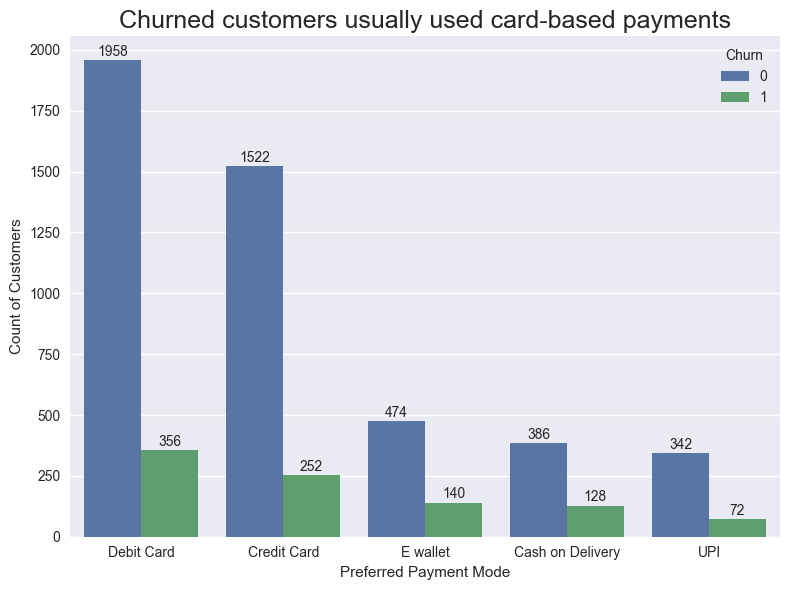

In [36]:
plt.figure(figsize=(8, 6))
plot2 = sns.barplot(x='PreferredPaymentMode', y='Count', hue='Churn', data=payment_df)

# add labels
for bar in plot2.patches:
  height = bar.get_height()
  label_text = int(height)                      # extract count value from bar height
  x_pos = bar.get_x() + bar.get_width() / 2     # center label horizontally
  y_pos = height + 5                            # adjust vertical position slightly above bar
  plot2.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=10)

plt.xlabel('Preferred Payment Mode')
plt.ylabel('Count of Customers')
plt.title('Churned customers usually used card-based payments', fontsize=18)
plt.xticks(rotation=0, ha='center')  
plt.tight_layout()
plt.show()

In [37]:
# calculate total customers per payment mode (churned + non-churned)
total_customers = payment_df.groupby('PreferredPaymentMode')['Count'].sum()

# calculate churned customers per payment mode
churned_customers = payment_df[payment_df['Churn'] == 1.0].set_index('PreferredPaymentMode')['Count']

# calculate churn rate per payment mode
churn_rate = (churned_customers / total_customers * 100).reset_index(name='rate').round(2)

# display churn rate
display(churn_rate.sort_values(by='rate', ascending=False))

PreferredPaymentMode   rate
0     Cash on Delivery  24.90
3             E wallet  22.80
4                  UPI  17.39
2           Debit Card  15.38
1          Credit Card  14.21

**Note**
- Irrespective of the churn status, card-based modes (debit and credit cards) remain the most preferred payment methods in the e-commerce company, and UPI ([Unified Payment Interface](https://en.wikipedia.org/wiki/Unified_Payments_Interface)) is the least preferred one with count of 414.
- Similar to Question 1 (Q1), we also need to take the churn rate of each payment mode into account to get a more comprehensive understanding of the churn.
- As shown on the calculation of simple count and churn rate, while card-based payment modes are most preferred, customers using these modes are less likely to cause churn. 
- Cash on Delivery (COD) and e-wallet with low counts have higher churn risk since the churn rate in these payment modes constitute greater than the overall churn rate at 16.8.
- Putting the findings in business context, the varying payment modes might influence customer churn, with COD users showing the highest and churn rate and card-based payment users indicate lowest rates.

In addition to examining which payment mode is most preferred and indicates highest churn risk, we will also supplement the analysis with investigating association between `Churn` and `PreferredPaymentMode` with chi-squared test.

In [38]:
# crosstab churn and preferredpaymentmode
contingency_table = pd.crosstab(df['Churn'], df['PreferredPaymentMode'])

# perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof:.4f}")

Chi-Square Statistic: 51.8290
P-Value: 0.0000
Degrees of Freedom: 4.0000


**Note**: The chi-square ($\chi^2$) test of independence revealed a significant association between customer churn and preferred payment methods, with a $\chi^2$ statistic of 51.8290 and a p-value of 0.0000, indicating a strong relationship between the variables. This result suggests that the payment method a customer chooses is significantly related to their likelihood of churning. Therefore, it would be beneficial to investigate how different payment methods impact churn rates.

#### **Q3. What gender category are the churners?**

In [39]:
gender_df = (df.groupby(['Churn', 'Gender'])
             .agg(func={'Gender':'count'})
             .rename(columns={'Gender':'Count'})
             .reset_index()
             .sort_values(by='Count', ascending=False))
gender_df

Churn  Gender  Count
1      0    Male   2784
0      0  Female   1898
3      1    Male    600
2      1  Female    348

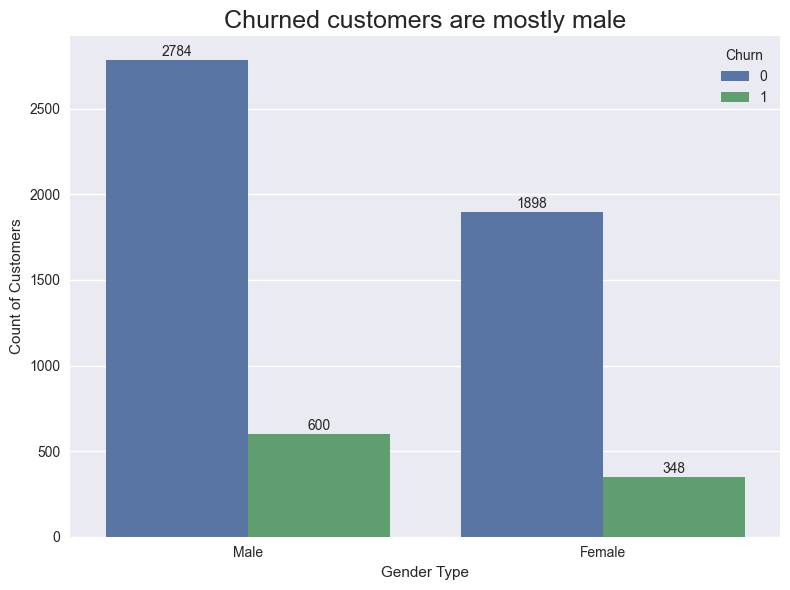

In [40]:
plt.figure(figsize=(8, 6))
plot3 = sns.barplot(x='Gender', y='Count', hue='Churn', data=gender_df)

# add labels
for bar in plot3.patches:
  height = bar.get_height()
  label_text = int(height)                      # extract count value from bar height
  x_pos = bar.get_x() + bar.get_width() / 2     # center label horizontally
  y_pos = height + 5                            # adjust vertical position slightly above bar
  plot3.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=10)

plt.xlabel('Gender Type')
plt.ylabel('Count of Customers')
plt.title('Churned customers are mostly male', fontsize=18)
plt.xticks(rotation=0, ha='center')  
plt.tight_layout()
plt.show()

In [41]:
# compute churn rate by gender
total_customers = gender_df.groupby('Gender')['Count'].sum()
churned_customers = gender_df[gender_df['Churn'] == 1.0].set_index('Gender')['Count']
churn_rate = (churned_customers / total_customers * 100).reset_index(name='rate').round(2)
display(churn_rate.sort_values(by='rate', ascending=False))

Gender   rate
1    Male  17.73
0  Female  15.49

**Note**
- The e-commerce customers in general are predominated by men (*N* = 3384) with the churn rate of 17.73%. The number of female customers consitutes only 2246 and churn rate of 15.49%.
- With this finding, we can say that male customers are more likely to churn than females although the rate difference is small.
- Due to this small difference, it is unlikely that the churn is a gender-related issue.

In [42]:
contingency_table = pd.crosstab(df['Churn'], df['Gender'])
display(contingency_table)
# perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof:.4f}")

Gender  Female  Male
Churn               
0         1898  2784
1          348   600

Chi-Square Statistic: 4.6629
P-Value: 0.0308
Degrees of Freedom: 1.0000


**Note**: 
- The test result indicates a statistically significant association between gender and the likelihood of churning, as the *p*-value is below the common threshold of 0.05, suggesting a meaningful relationship between a customer's gender and their probability of churning. 
- While the Chi-Square test of independence indicates a significant association between gender and churn status, with a p-value of 0.0308, the actual churn rates by gender show only a small difference (17.73 (Male) vs 15.49 (Female)). This suggests that while there is a statistically significant relationship, the practical impact may be limited. 
- The small difference in churn rates implies that gender alone might not be a major driver of churn, and other factors might be influencing churn rates more significantly. Therefore, while gender should be considered in the broader context of customer retention strategies, it might not be the most critical factor to address on its own. 

#### **Q4. Are those churners mostly single?**

In [43]:
marital_df = (df.groupby(['Churn', 'MaritalStatus'])
             .agg(func={'MaritalStatus':'count'})
             .rename(columns={'MaritalStatus':'Count'})
             .reset_index()
             .sort_values(by='Count', ascending=False))
marital_df

Churn MaritalStatus  Count
1      0       Married   2642
2      0        Single   1316
0      0      Divorced    724
5      1        Single    480
4      1       Married    344
3      1      Divorced    124

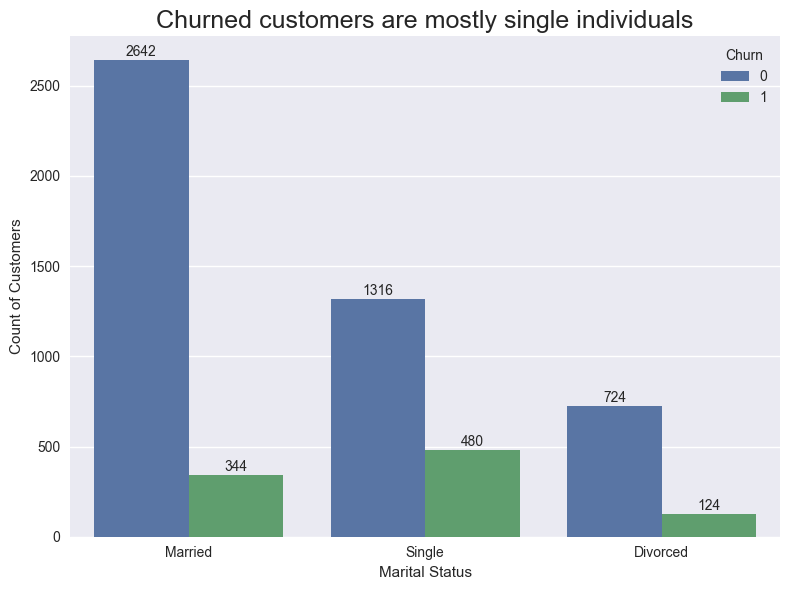

In [44]:
plt.figure(figsize=(8, 6))
plot4 = sns.barplot(x='MaritalStatus', y='Count', hue='Churn', data=marital_df)

# add labels
for bar in plot4.patches:
  height = bar.get_height()
  label_text = int(height)                      # extract count value from bar height
  x_pos = bar.get_x() + bar.get_width() / 2     # center label horizontally
  y_pos = height + 5                            # adjust vertical position slightly above bar
  plot4.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=10)

plt.xlabel('Marital Status')
plt.ylabel('Count of Customers')
plt.title('Churned customers are mostly single individuals', fontsize=18)
plt.xticks(rotation=0, ha='center')  
plt.tight_layout()
plt.show()

In [45]:
#  Calculate the total count by MaritalStatus
total_counts = marital_df.groupby('MaritalStatus')['Count'].sum().reset_index()
total_counts.columns = ['MaritalStatus', 'TotalCount']

# Calculate the churn count by MaritalStatus
churn_counts = marital_df[marital_df['Churn'] == 1.0].groupby('MaritalStatus')['Count'].sum().reset_index()
churn_counts.columns = ['MaritalStatus', 'ChurnCount']

# Merge the total counts and churn counts
merged_df = pd.merge(total_counts, churn_counts, on='MaritalStatus', how='left')

# Fill NaN values with 0 for MaritalStatus that have no churn
merged_df['ChurnCount'] = merged_df['ChurnCount'].fillna(0)

# Calculate the churn rate
merged_df['ChurnRate'] = (merged_df['ChurnCount'] / merged_df['TotalCount']*100).round(2)

display(merged_df.sort_values(by='ChurnRate', ascending=False))

MaritalStatus  TotalCount  ChurnCount  ChurnRate
2        Single        1796         480      26.73
0      Divorced         848         124      14.62
1       Married        2986         344      11.52

**Note**
- Even though the majority of customer marital statuses are married, single customers have the highest contribution to the churn. Out of 1316, there are 480 customers who churned (churn rate: 26.73%).
- Married couples might buy a wider range of products (e.g., household goods or children's products) regularly from the same e-commerce platform, leading to higher retention. Single individuals, on the contrary, might have more specific and less frequent needs, leading to higher churn as they shop around.
- And now, the question is whether churn is associated with gender category. If so, this will mean that marital status is related to churn.

In [46]:
contingency_table = pd.crosstab(df['Churn'], df['MaritalStatus'])
display(contingency_table)

# perform the chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof:.4f}")

MaritalStatus  Divorced  Married  Single
Churn                                   
0                   724     2642    1316
1                   124      344     480

Chi-Square Statistic: 188.6710
P-Value: 0.0000
Degrees of Freedom: 2.0000


**Note**
- The chi-square test of independence between `Churn` and `MaritalStatus` shows a statistic of 188.6710 with a *p*-value of 0.0000, indicating a highly significant association between these variables. This means that a customer's marital status is closely related to their likelihood of churning. 
- Specifically, the churn rates show that single customers have the highest churn rate at 26.73%, followed by divorced customers at 14.62%, and married customers with the lowest churn rate of 11.52%. This suggests that single customers are more likely to leave compared to those who are married or divorced. 
- As a result, developing targeted strategies to decrease churn, particularly focusing on single customers who exhibit higher churn rates can be an option.

#### **Q5. Do churners have any preference in terms of order category?**

In [47]:
order_df = (df.groupby(['Churn', 'PreferedOrderCat'])
             .agg(func={'PreferedOrderCat':'count'})
             .rename(columns={'PreferedOrderCat':'Count'})
             .reset_index()
             .sort_values(by='Count', ascending=False))
order_df

Churn    PreferedOrderCat  Count
2      0  Laptop & Accessory   1840
3      0        Mobile Phone   1510
0      0             Fashion    698
8      1        Mobile Phone    570
1      0             Grocery    390
4      0              Others    244
7      1  Laptop & Accessory    210
5      1             Fashion    128
6      1             Grocery     20
9      1              Others     20

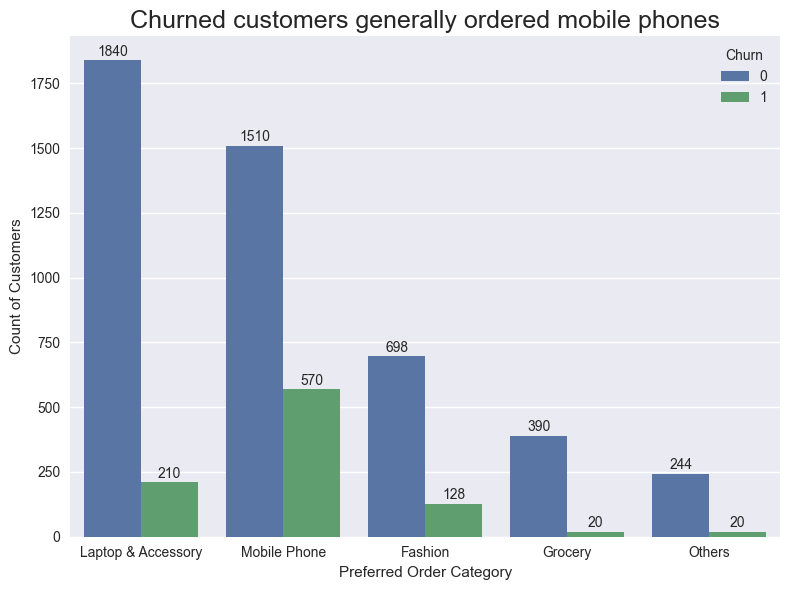

In [48]:
plt.figure(figsize=(8, 6))
plot5 = sns.barplot(x='PreferedOrderCat', y='Count', hue='Churn', data=order_df)

# add labels
for bar in plot5.patches:
  height = bar.get_height()
  label_text = int(height)                      # extract count value from bar height
  x_pos = bar.get_x() + bar.get_width() / 2     # center label horizontally
  y_pos = height + 5                            # adjust vertical position slightly above bar
  plot5.text(x_pos, y_pos, label_text, ha='center', va='bottom', fontsize=10)

plt.xlabel('Preferred Order Category')
plt.ylabel('Count of Customers')
plt.title('Churned customers generally ordered mobile phones', fontsize=18)
plt.xticks(rotation=0, ha='center')  
plt.tight_layout()
plt.show()

In [49]:
# calculate the total count 
total_counts = order_df.groupby('PreferedOrderCat')['Count'].sum().reset_index()
total_counts = total_counts.rename(columns={'Count': 'TotalCount'})

# calculate the count of churned customers
churned_counts = order_df[order_df['Churn'] == 1.0][['PreferedOrderCat', 'Count']]
churned_counts = churned_counts.rename(columns={'Count': 'ChurnedCount'})

# combine total counts with the churned counts
churn_rate_df = pd.merge(total_counts, churned_counts, on='PreferedOrderCat', how='left')
churn_rate_df['ChurnedCount'] = churn_rate_df['ChurnedCount'].fillna(0)

# get the churn rate
churn_rate_df['ChurnRate'] = (churn_rate_df['ChurnedCount'] / churn_rate_df['TotalCount']*100).round(2)

churn_rate_df.sort_values(by='ChurnRate', ascending=False)

PreferedOrderCat  TotalCount  ChurnedCount  ChurnRate
3        Mobile Phone        2080           570      27.40
0             Fashion         826           128      15.50
2  Laptop & Accessory        2050           210      10.24
4              Others         264            20       7.58
1             Grocery         410            20       4.88

**Note**
- As can be seen on the bar chart and the table, customers who bought electronic devices, particularly `Mobile Phone`, are more likely to churn.
- The churn rates for customers who prefer to order `Mobile Phones` (27.40%) are significantly higher than other categories, indicating customers interested in "Mobile Phone" items are more likely to leave the service compared to other categories.
- These rates are almost double in comparison to `Fashion` category (15.50%) and several times higher than categories like `Laptop & Accessory` (10.24%), `Others` (7.58%), and `Grocery` (4.88%).
- The high churn rate in mobile phones may be best attributed to the product lifecyle. They are typically bought once and used for an extended period before being replaced. This leads to lower repeat purchase rates within a short time frame, and as a result leading to a natural churn as the customers are not making frequent purchases.

In [50]:
contingency_table = pd.crosstab(df['Churn'], df['PreferedOrderCat'])
display(contingency_table)

# perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof:.4f}")

PreferedOrderCat  Fashion  Grocery  Laptop & Accessory  Mobile Phone  Others
Churn                                                                       
0                     698      390                1840          1510     244
1                     128       20                 210           570      20

Chi-Square Statistic: 288.5978
P-Value: 0.0000
Degrees of Freedom: 4.0000


**Note**
- The chi-square test of independence between churn status and preferred order category yielded a Chi-Square statistic of 288.6394 with a *p*-value of 0.0000, indicating a very significant relationship between these two variables. 
- This result tells us that a customer's preferred order category is strongly associated with their likelihood of churning.

### **3.2 Numerical Features**

#### **Q1. Are there any features highly correlated with churns?**
This question is concerned with correlation test on different numerical features and churn. This test provides insights into the relationship between different variables and how they might influence churn. In other words, it serves as an initial screening on how individual metrics, e.g., tenure, usage patterns relate to churn behavior. And as informed by our distribution test in Section 2.2, we found out that the majority of numerical features have skewed distribution, except the `SatisfactionScore`. For this reason, we will utilize Spearman's correlation test ($\rho$) to explore relationship between numerical features and the churn. Unlike Pearson's correlation coefficient (r), Spearman's rho (ρ) does not assume any specific distribution. This nonparametric test is also less sensitive to outliers because it uses the ranks of the data, instead of the values themselves.

Furthermore, since Spearman's correlation test is limited to numerical input, another correlation test is needed for the categorical features. Here, we will use $\phi k$ ([Baak et al, 2020](https://doi.org/10.1016/j.csda.2020.107043)). Similar to Spearman's $\rho$, $\phi k$ does not have specific assumption about the data distribution and uses rank of values, instead of the values themselves.

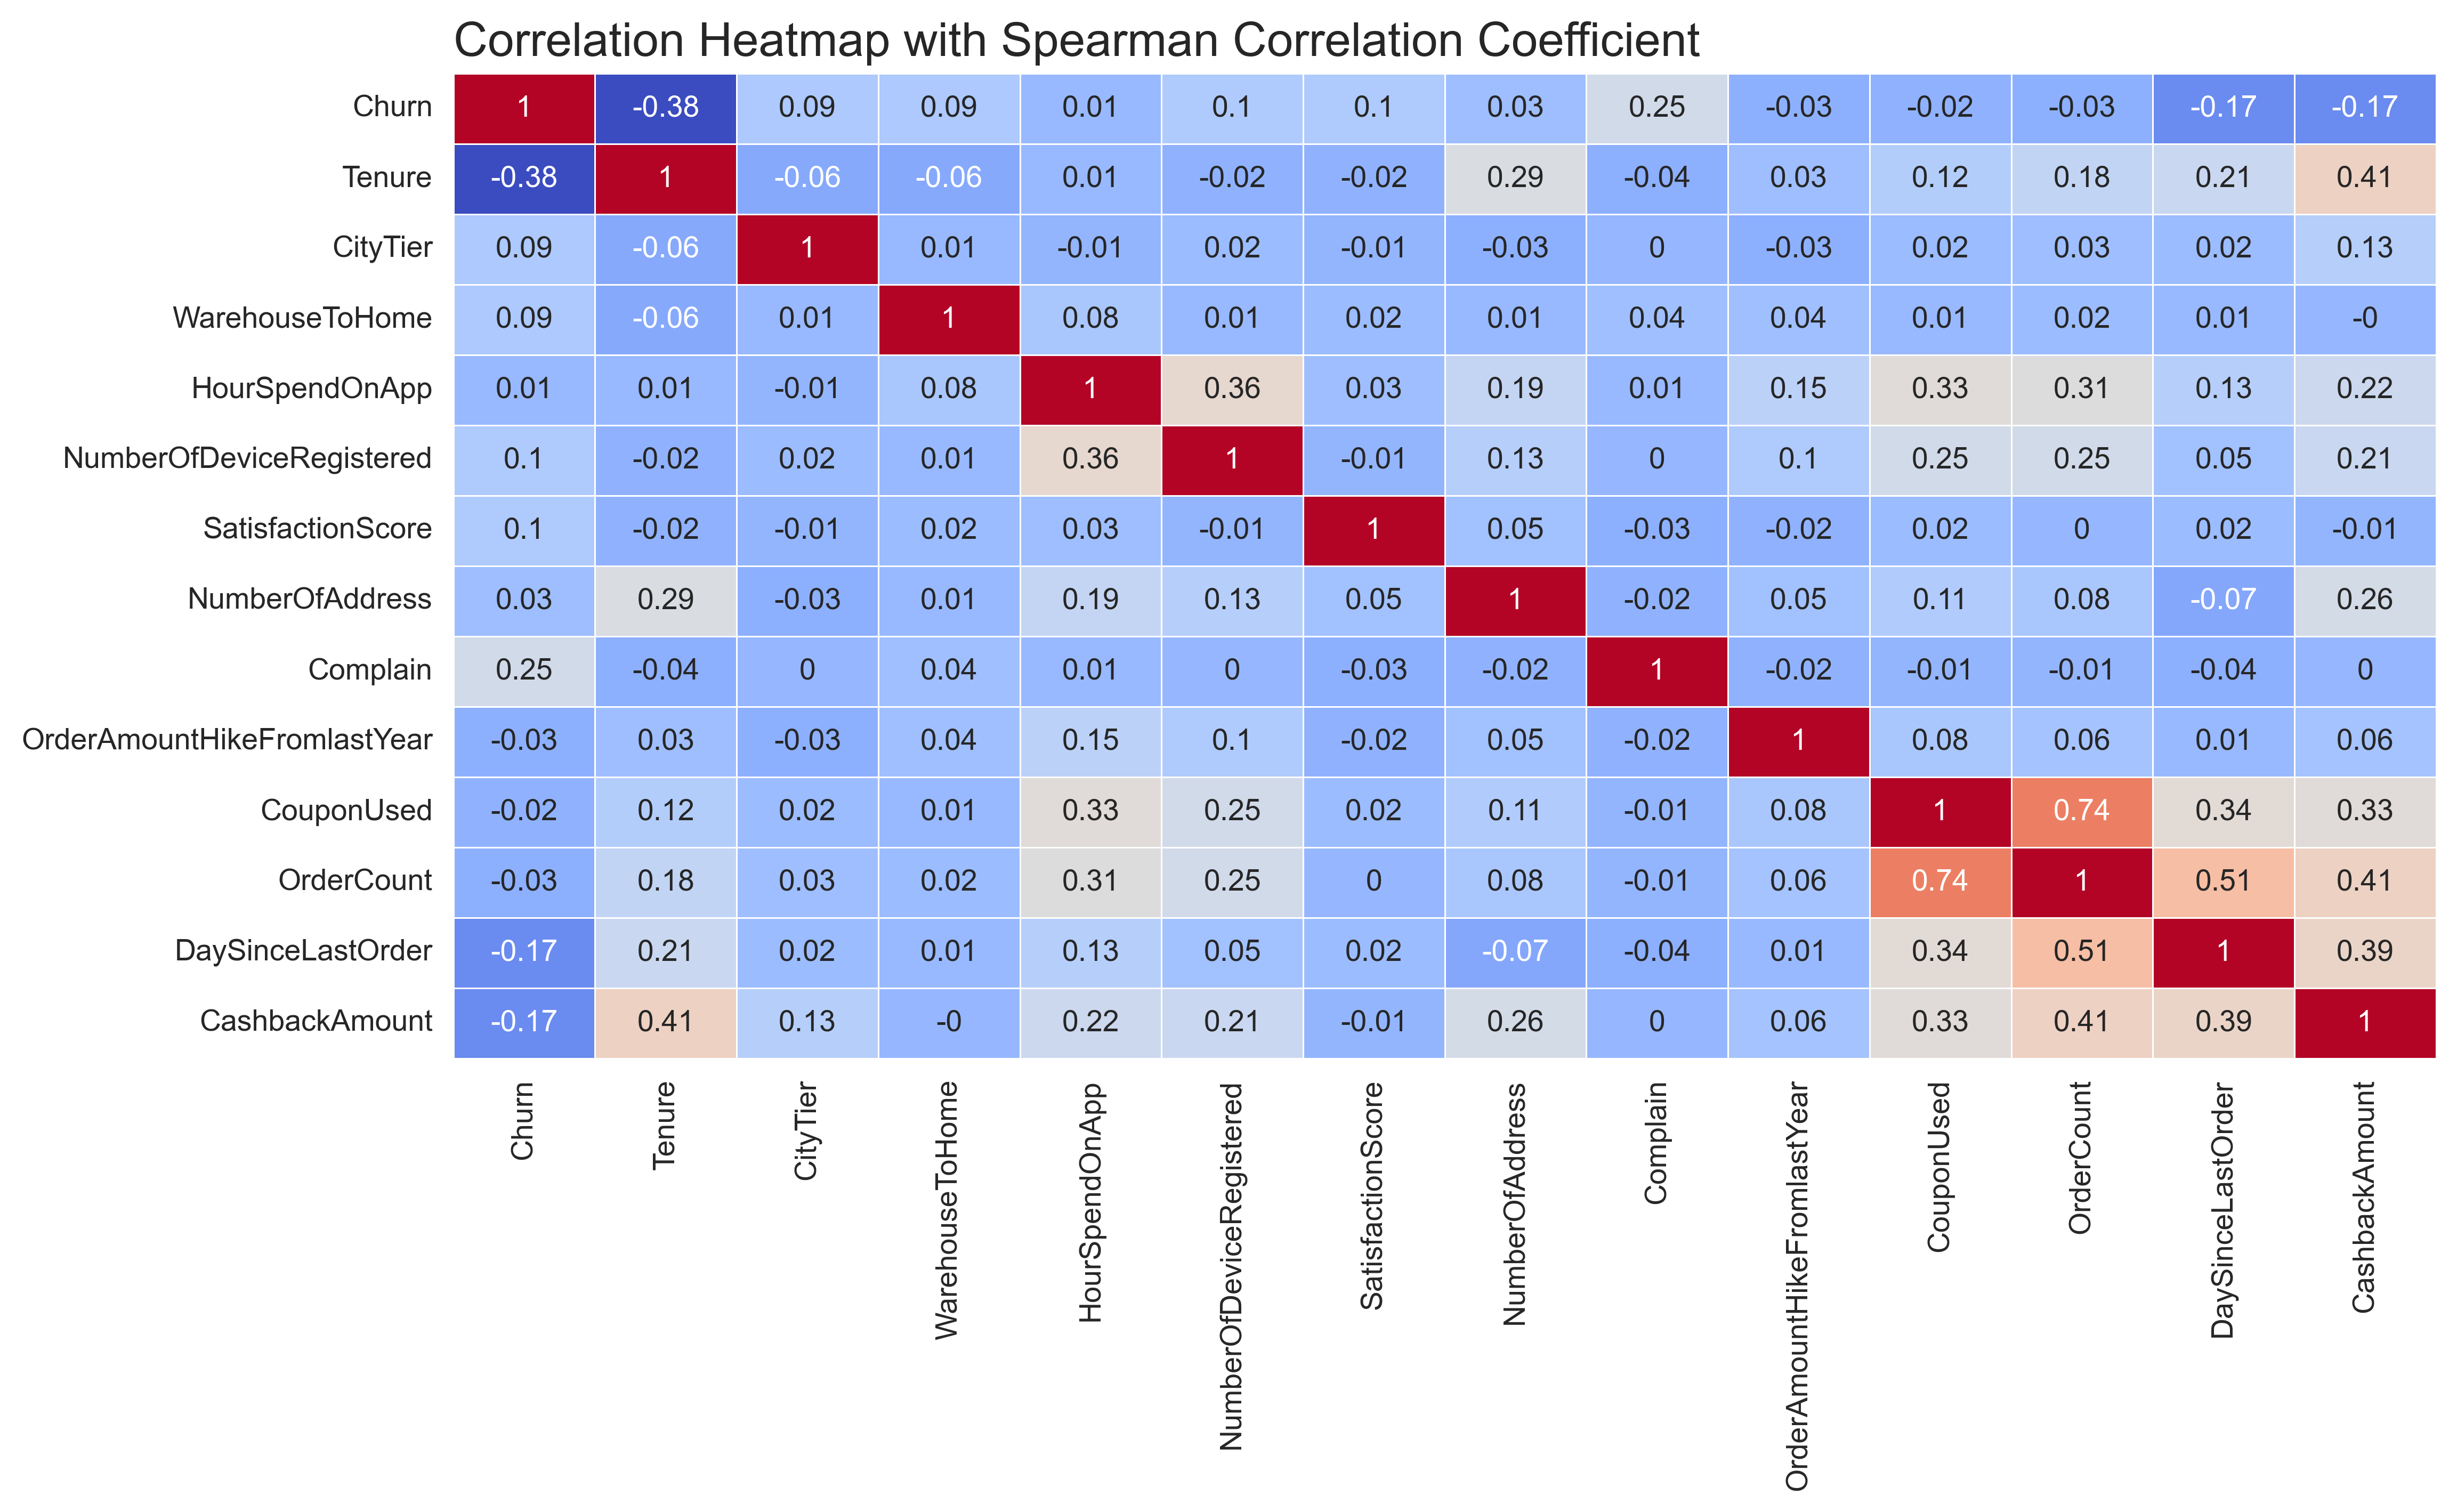

In [51]:
plt.figure(figsize=(12, 6), dpi=400)
cols_to_plot = ['Churn', 'Tenure', 'CityTier',
                'WarehouseToHome','HourSpendOnApp', 
                'NumberOfDeviceRegistered', 'SatisfactionScore',
                'NumberOfAddress', 'Complain', 
                'OrderAmountHikeFromlastYear',
                'CouponUsed', 'OrderCount',
                'DaySinceLastOrder', 'CashbackAmount']

correlation_matrix = df[cols_to_plot].corr(numeric_only=True, method='spearman').round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.title('Correlation Heatmap with Spearman Correlation Coefficient', loc='left', fontsize=16)
plt.show()

In [52]:
# check correlation: categorical variables + churn
(df.loc[:, ['Churn', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']]
 .phik_matrix(interval_cols=['Churn'])
 .style.background_gradient(cmap='YlOrRd')
 .format('{:.2f}'))

**Note**
- In our analysis, no features showed a strong correlation ($\rho \ge 0.6$) with churn, suggesting that churn might not be driven by any single feature in a straightforward linear way. 
- As shown on the correlation matrix with Spearman's $\rho$ and $\phi k$, regardless of their negative or positive directions, the highest correlation coefficient score is no more than 0.4. This outcome might highlight the complexity of customer behavior where churn could be influenced by a combination of factors rather than individual features alone. 
- To further understand churn, we should explore potential non-linear relationships between features and churn.
- Next, as we saw small correlation coefficients between churn and other variables, we can test whether their relationships are not linear by using a data visualization technique, namely pairplot, a combination between a histogram and a scatter plot. In general, if the scatter plot between variables indicate *U* or *S* shaped patterns, instead of a straight diagonal line. This pattern is an indicator of non-linearity. Another possible pattern indicating nonlinearity which a scatter plot can show is the presence of clusters. 

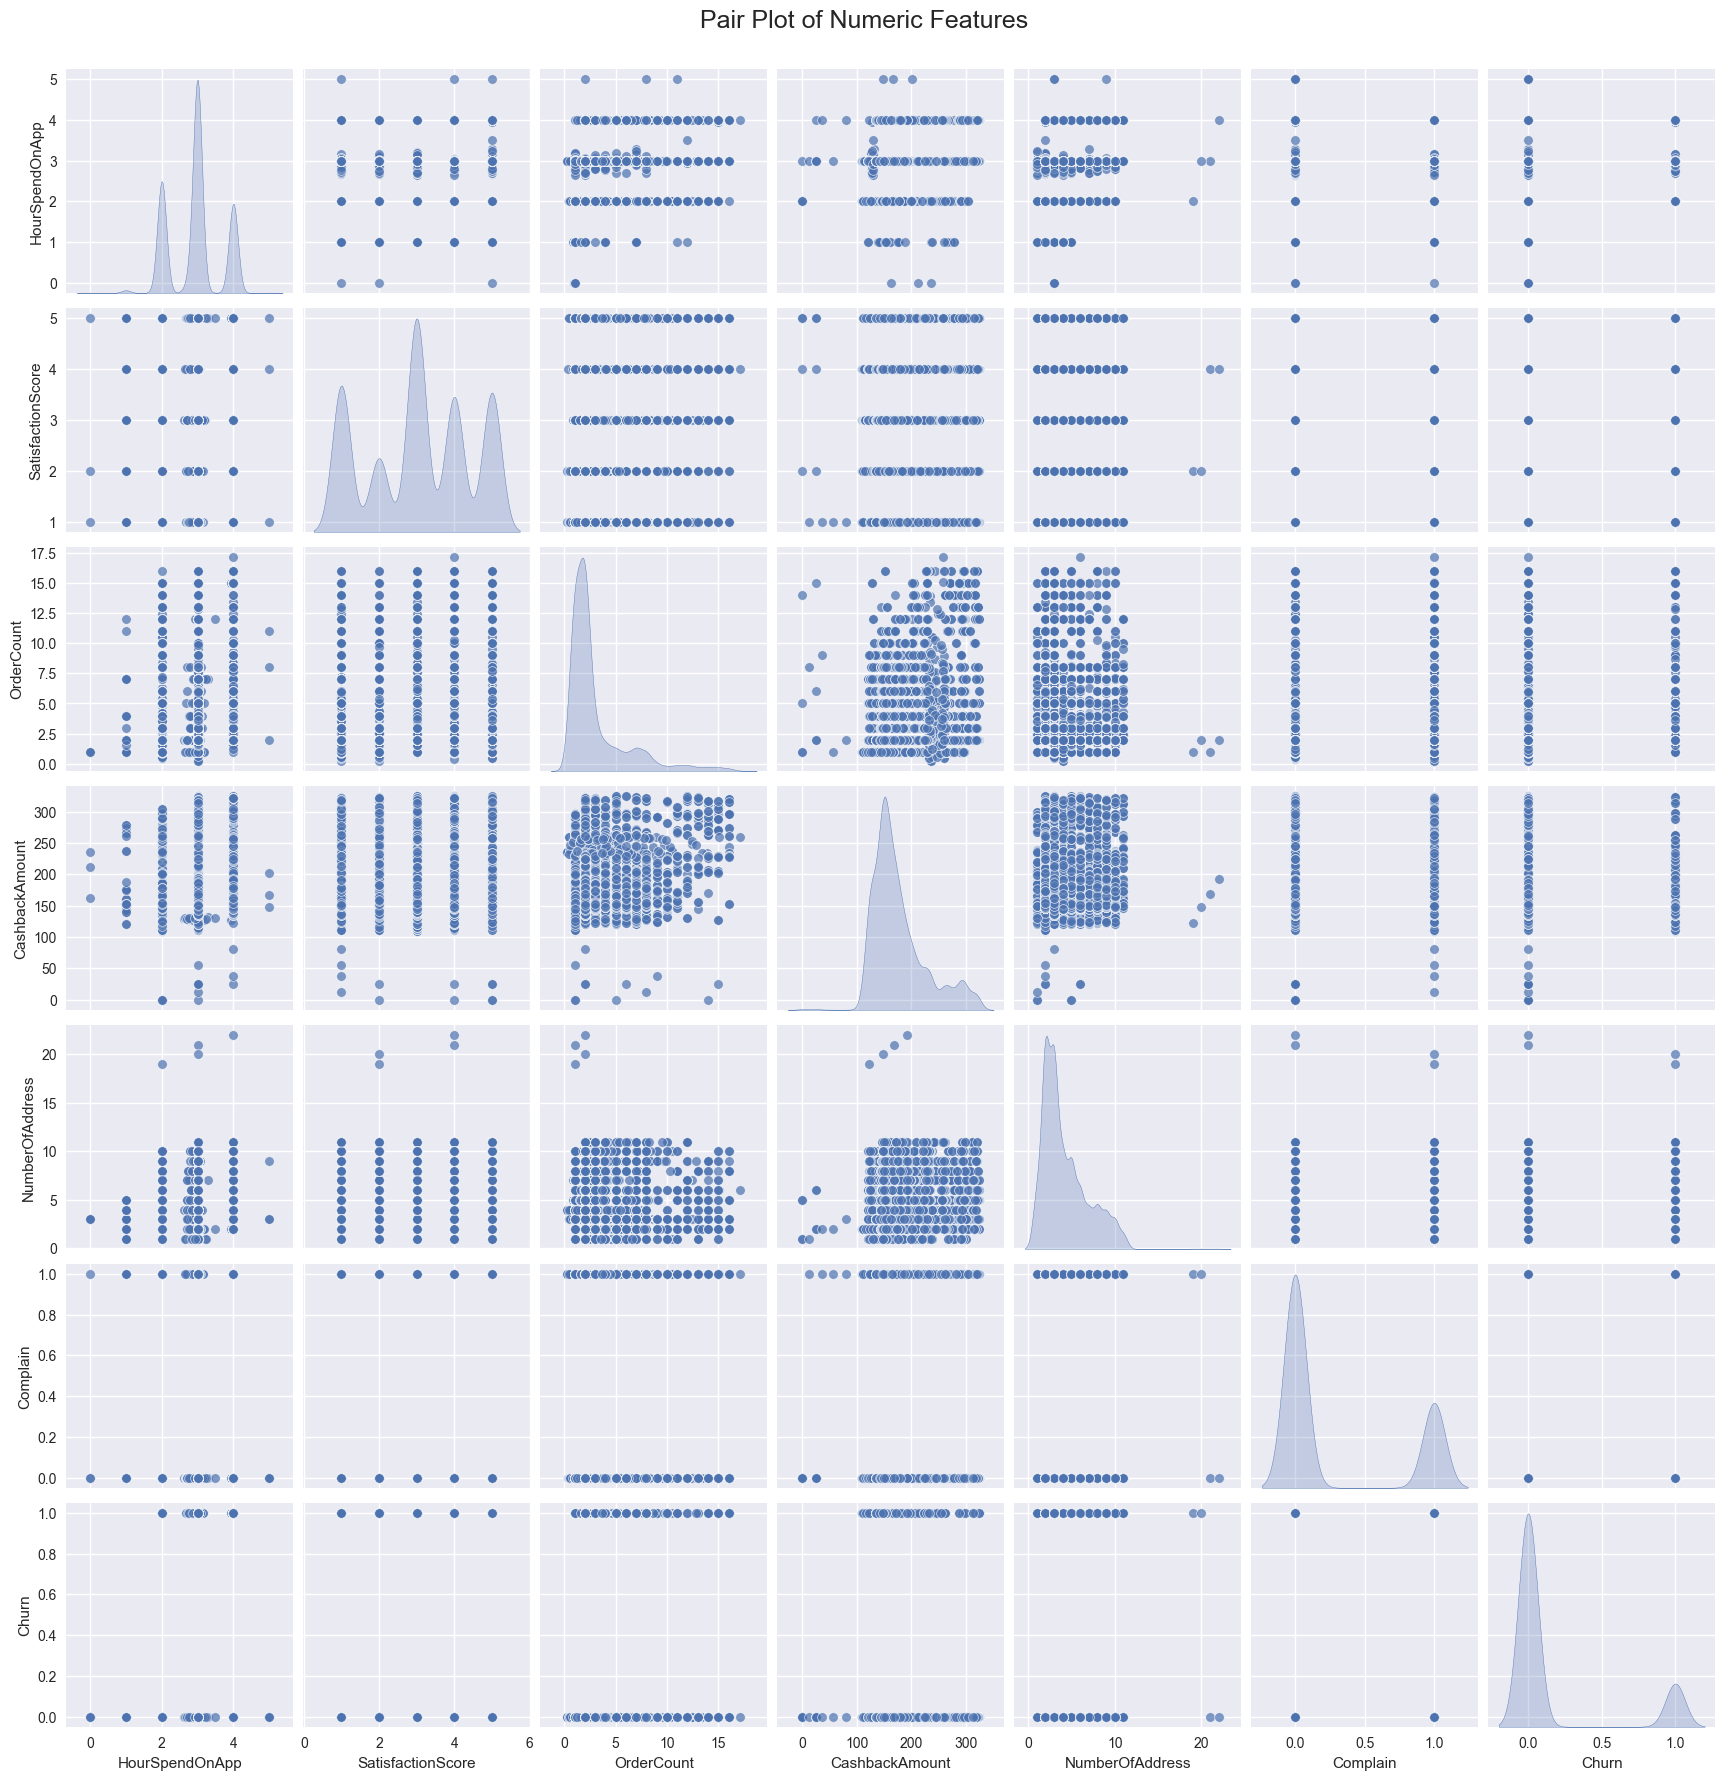

In [53]:
# select cols
selected_cols = ['HourSpendOnApp', 'SatisfactionScore', 'OrderCount', 'CashbackAmount', 'NumberOfAddress', 'Complain', 'Churn']
pair_plot_data = df[selected_cols]  

# Plot
sns.pairplot(pair_plot_data, plot_kws={'alpha':0.7}, diag_kind='kde', palette='viridis')
plt.suptitle('Pair Plot of Numeric Features', y=1.02, fontsize=18) 
plt.show()

**Note**
- The visual test using pairplots helps explain why there are no high Spearman correlation coefficients between churn and other variables. In scatter plots, a linear relationship typically appears as a cloud of points forming a straight line, either sloping upwards or downwards (diagonal line). However, in the case of churn, the data points are clustered into distinct bands corresponding to its binary values (0 or 1), showing no clear correlation with other variables and hence small correlation coefficient. 
- While this insight does not directly translate into actionable business strategies, it highlights the limitation of linear correlation tests in this context. Therefore, it suggests that we should consider models that do not rely on linear assumptions, such as XGBoost, decision trees, or random forests, to better capture complex relationships and improve predictive performance.

#### **Q2. To what extent churned customers and loyal customers are different in terms of their purchasing behaviors?**
In this question, we examine the extent to which churned and non-churned customers are different. The investigation will be done by mainly using Mann-Whitney *U* test. And based on this test, we can further narrow down the analysis

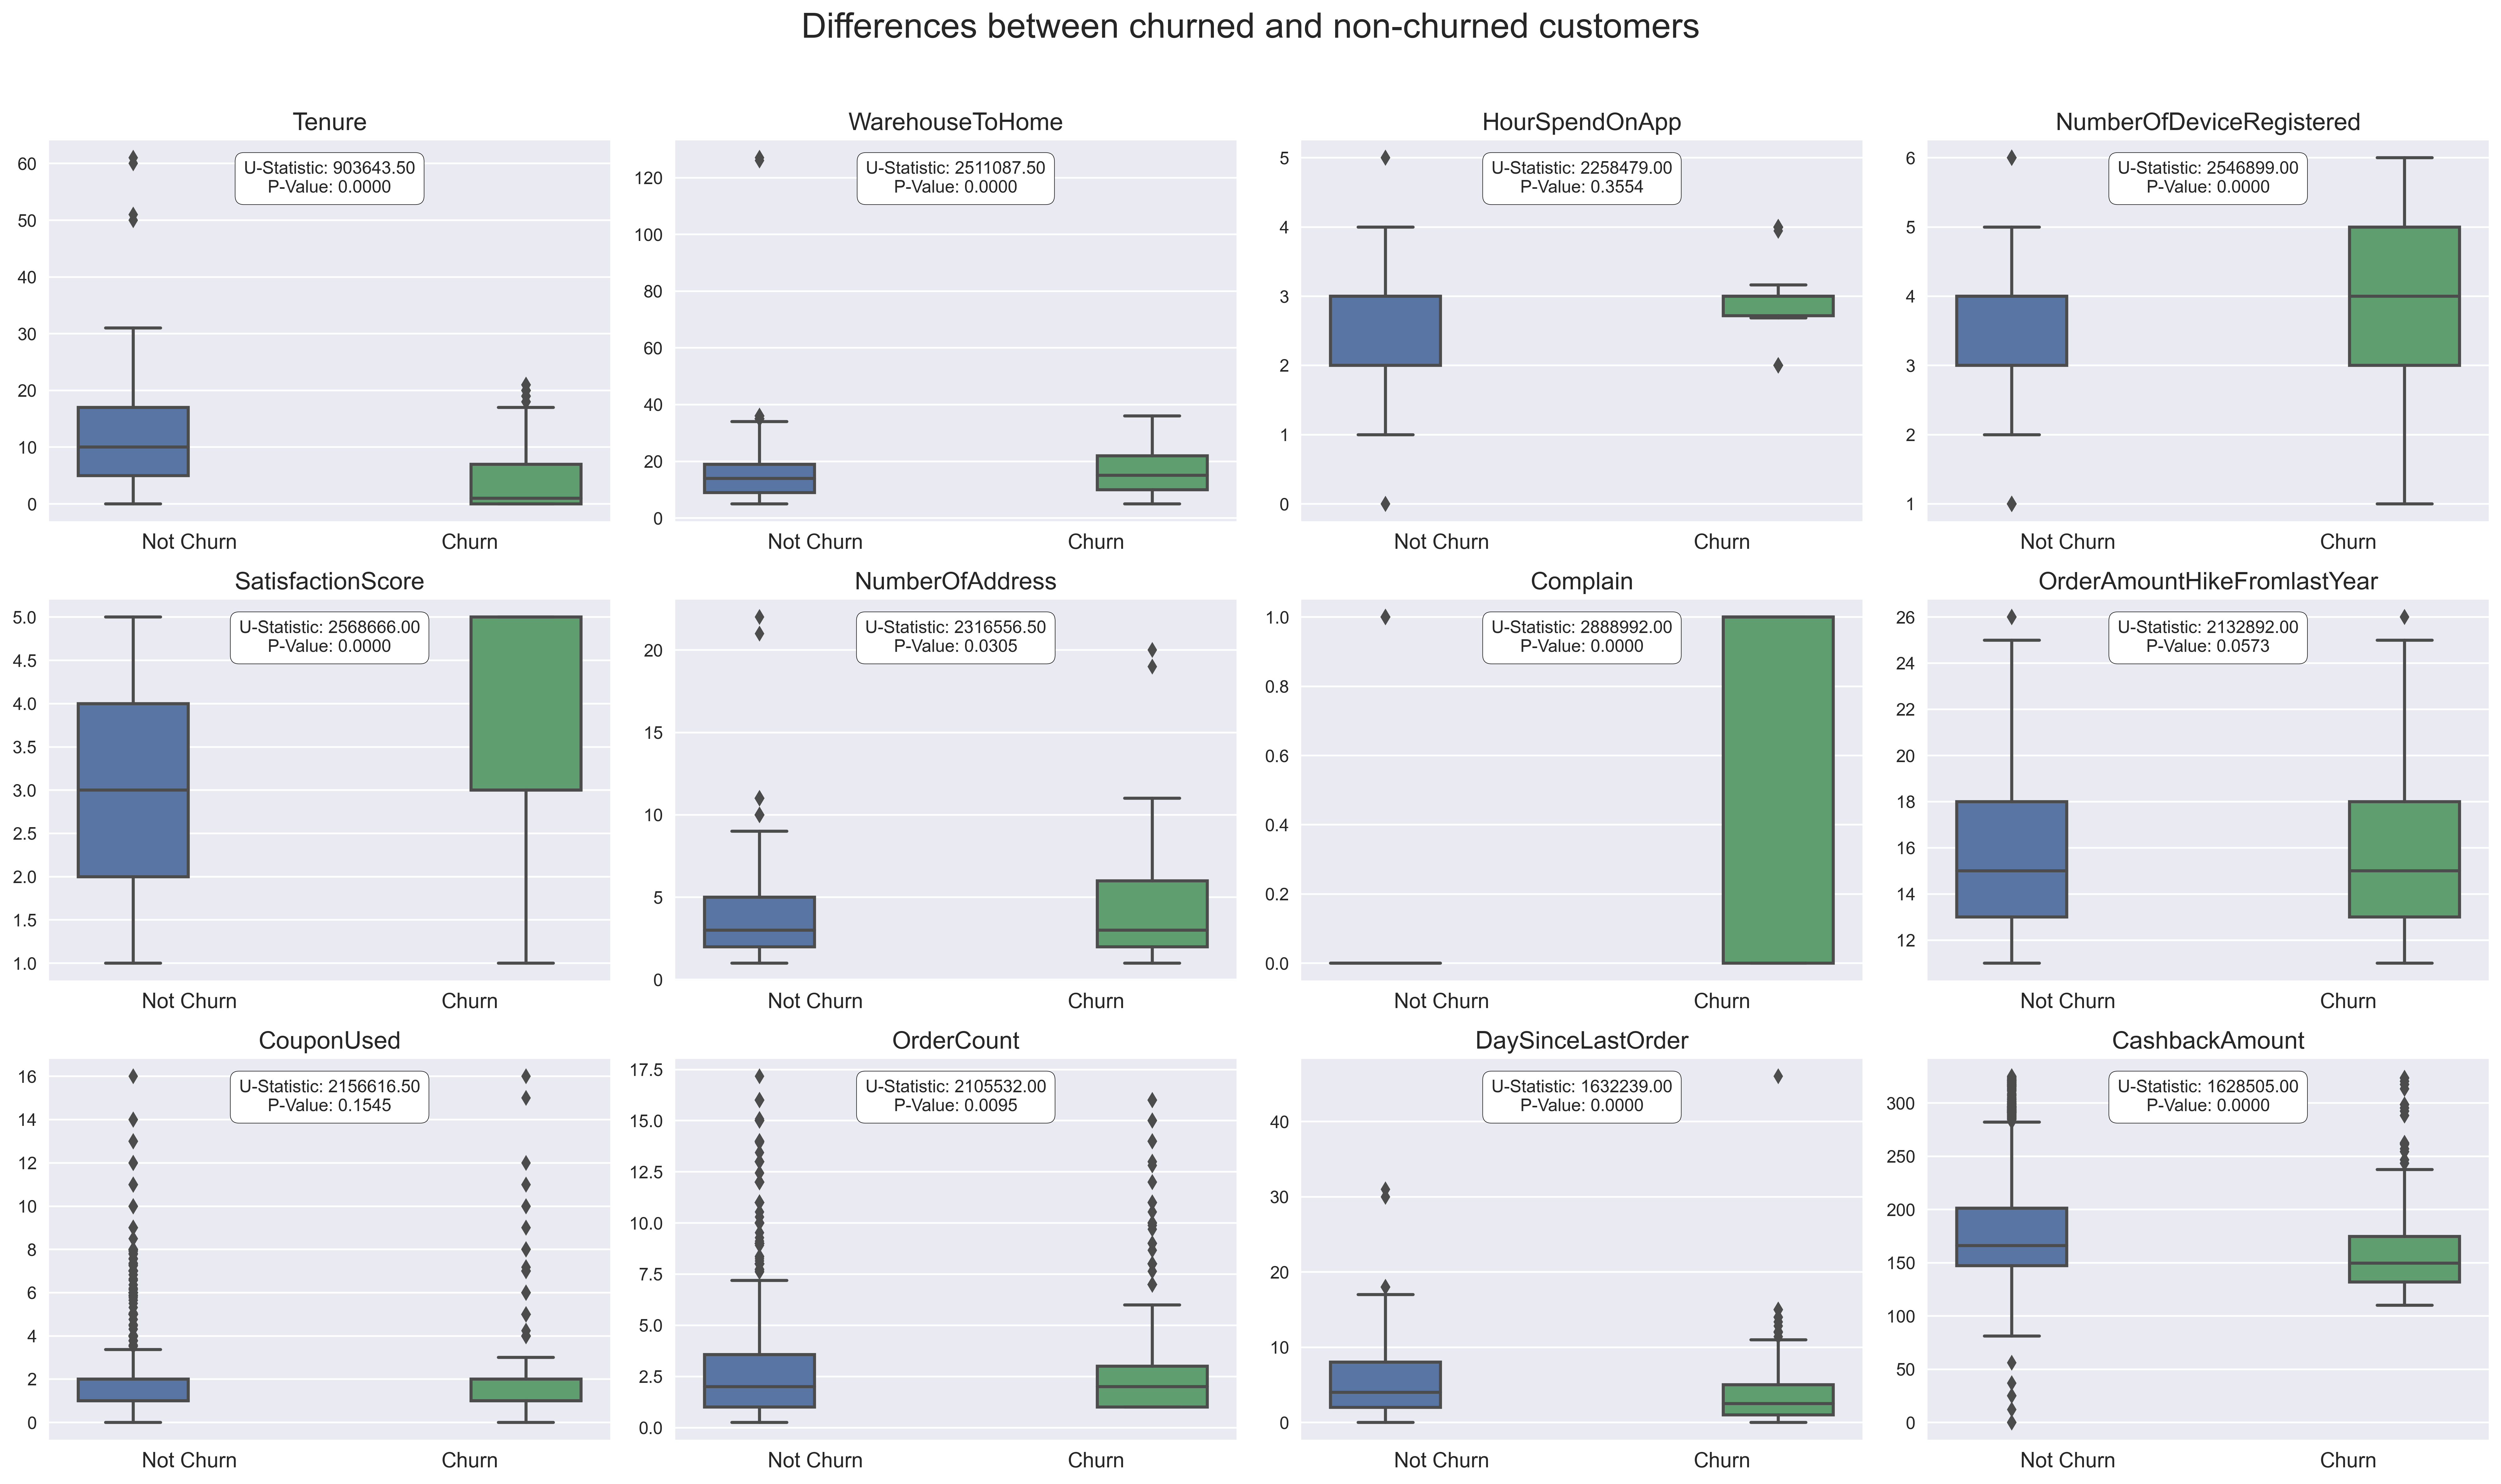

In [54]:
# List of columns to plot
columns_to_plot = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                   'NumberOfDeviceRegistered', 'SatisfactionScore', 
                   'NumberOfAddress', 'Complain', 
                   'OrderAmountHikeFromlastYear', 
                   'CouponUsed', 'OrderCount', 
                   'DaySinceLastOrder',
                   'CashbackAmount']

# create the figure
plt.figure(figsize=(20, 12), dpi=400)
plt.suptitle('Differences between churned and non-churned customers', fontsize=20)

# iterate over each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 4, i)
    ax = sns.boxplot(x='Churn', y=column, data=df, hue='Churn')
    
    # perform Mann-Whitney U test
    churn_data = df[df['Churn'] == 1][column]
    not_churn_data = df[df['Churn'] == 0][column]
    u_stat, p_value = mannwhitneyu(churn_data, not_churn_data)
    
    # annotate the plot with the Mann-Whitney U test results
    y_max = df[column].max()  # get the maximum y value for positioning
    y_min = df[column].min()  # get the minimum y value for positioning
    ax.text(0.5, 0.9, f'U-Statistic: {u_stat:.2f}\nP-Value: {p_value:.4f}', 
            ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
            transform=ax.transAxes)  # use relative coordinates
    
    ax.set_xticklabels(['Not Churn', 'Churn'], fontsize=12)
    plt.title(f'{column}', fontsize=14)
    plt.xlabel(None)
    plt.ylabel(None)
    if ax.legend_:
        ax.legend_.remove()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Note**
- In general, churn customers tend to have shorter tenure, higher satisfaction score, more number devices registered, receive lower cashback amount, and more complaints.
- In terms of coupon used, order amount hike, and hour spent on app, churned and non-churned customers are relatively similar.
- To examine whether the differences between churn and non-churn customers are statistically considerable, Mann-Whitney *U* tests are used. This non-parametric statistical test is chosen as some variables contain outliers and their distributions are not normal. And Mann-Whitney *U* is known to be more robust to the presence of outliers ([Dehaene, De Neve, & Rosseel, 2021](https://doi.org/10.3389/fpsyg.2021.754898)). The robustness stems from how it works. Mann-Whitney *U* does not use raw values similar to its parametric counterpart (*t*-test) but it utilizes ranks.

In [55]:
# compute mann-whitney U
results = []
for column in columns_to_plot:
    churned = df[df['Churn'] == 1][column]
    loyal = df[df['Churn'] == 0][column]
    stat, p_value = mannwhitneyu(churned, loyal)
    results.append({'Feature': column, 'Statistic': stat, 'p-value': p_value})

mann_result = pd.DataFrame(results).round(3)
mann_result['significant'] = mann_result['p-value'].map(lambda x: 'Significant' if x < 0.05 else 'NotSignificant' )
mann_result.sort_values(by='p-value')

Feature  Statistic  p-value     significant
0                        Tenure   903643.5    0.000     Significant
1               WarehouseToHome  2511087.5    0.000     Significant
3      NumberOfDeviceRegistered  2546899.0    0.000     Significant
4             SatisfactionScore  2568666.0    0.000     Significant
6                      Complain  2888992.0    0.000     Significant
10            DaySinceLastOrder  1632239.0    0.000     Significant
11               CashbackAmount  1628505.0    0.000     Significant
9                    OrderCount  2105532.0    0.009     Significant
5               NumberOfAddress  2316556.5    0.030     Significant
7   OrderAmountHikeFromlastYear  2132892.0    0.057  NotSignificant
8                    CouponUsed  2156616.5    0.154  NotSignificant
2                HourSpendOnApp  2258479.0    0.355  NotSignificant

**Note**
- The table complements the findings. In general, churn and non-churn customers are significantly different in terms of `Tenure`, `SatisfactionScore`, `NumberOfDeviceRegistered`, `CashbackAmount`, and `Complain`.
- While it remains an open question why churn customers gave higher satisfaction scores (see 25% and 75% percentiles in table above) due to the absence of supporting data, e.g., customer review, it is possible that there are some measurement issues in CSAT, especially measurement timing. For example, when the survey is done before the churn, the customer sentiment at the point of churn is not represented in the survey. Evidence we have is that churn customers reported more complaints than the non-churn counterparts (*p* < 0.05, see box plot below).
    - Kindly note that `SatisfactionScore` does not contain any missing values and outliers. Data in this variable is therefore original and it does not suffer from data imputation or outlier handling bias.

##### **Q2.1 Are there any possible reasons why customers who churned provided high satisfaction score?**

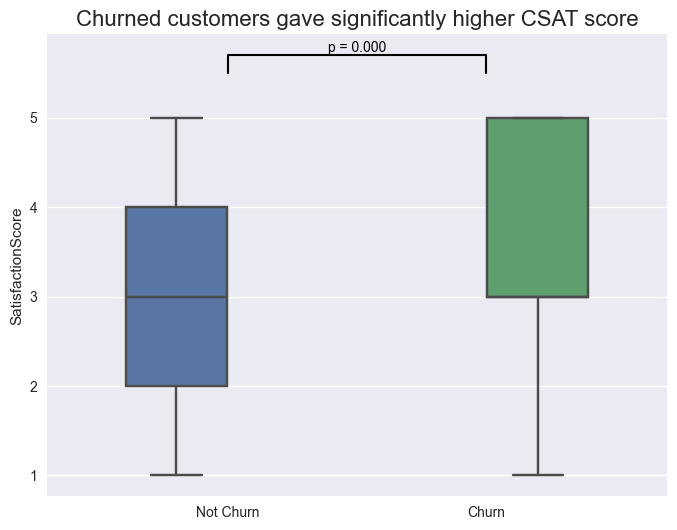

In [56]:
# calculate Mann-Whitney U test
churned = df[df['Churn'] == 1]['SatisfactionScore']
loyal = df[df['Churn'] == 0]['SatisfactionScore']
stat, p_value = mannwhitneyu(churned, loyal)

# make box plt
plt.figure(figsize=(8, 6))
# ax = sns.violinplot(x='Churn', y='SatisfactionScore', data=df, palette='muted')
ax = sns.boxplot(x='Churn', y='SatisfactionScore', data=df, hue='Churn')
ax.set_xticklabels(['Not Churn', 'Churn'])
plt.title('Churned customers gave significantly higher CSAT score', fontsize=16)
plt.xlabel(None)
ax.legend_.remove()

# add p-value
x1, x2 = 0, 1
y, h, col = df['SatisfactionScore'].max() + 0.5, 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col)

plt.show()

**Note**: To recap, the Mann-Whitney *U* test indicates that churned and non-churned customers are significantly different in terms of satisfaction score. Churned customers appear to provide higher scores in comparison to the non-churned counterparts. And to gain a better understanding on this peculiar finding, we will check the distribution of the satisfaction score, and identify which one is the riskiest than others

In [57]:
satisfaction_df = (df.groupby(['Churn', 'SatisfactionScore'])
                   .agg(func={'SatisfactionScore':'count'})
                   .rename(columns={'SatisfactionScore':'Count'})
                   .reset_index())

# Calculate total churned customers
churn_by_satisfaction = satisfaction_df.groupby('SatisfactionScore').agg({'Count': 'sum'})
churn_by_satisfaction['ChurnCount'] = satisfaction_df[satisfaction_df['Churn'] == 1].groupby('SatisfactionScore')['Count'].sum()
churn_by_satisfaction['ChurnRate'] = ((churn_by_satisfaction['ChurnCount'] / churn_by_satisfaction['Count']) * 100).round(2)

display(churn_by_satisfaction.reset_index())

SatisfactionScore  Count  ChurnCount  ChurnRate
0                  1   1164         134      11.51
1                  2    586          74      12.63
2                  3   1698         292      17.20
3                  4   1074         184      17.13
4                  5   1108         264      23.83

**Note**: Although in terms of counts those who gave three stars are the highest (*n* = 292), those who churned and gave five score indicate greatest churn rate (23.83). As `SatisfactionScore` is closely related to `Complain`, it is important to explore them altogether, especially for those churners who provided 5 CSAT score. 

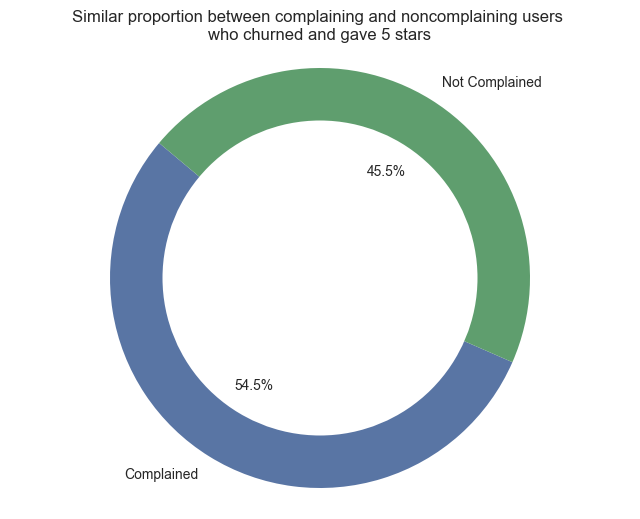

In [58]:
# Calculate proportions of complaints vs. non-complaints
complaint_counts = df[(df['Churn'] == 1) & (df['SatisfactionScore'] == 5)].loc[:, 'Complain'].value_counts()
complaint_labels = ['Complained', 'Not Complained']
complaint_sizes = complaint_counts.values

# create the donut chart
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.pie(complaint_sizes, labels=complaint_labels, autopct='%1.1f%%', startangle=140, colors=['#5975a4', '#5f9e6e'])
centre_circle = plt.Circle((0,0),0.75, fc='white')
fig.gca().add_artist(centre_circle)
ax.axis('equal')

plt.title('Similar proportion between complaining and noncomplaining users \nwho churned and gave 5 stars')
plt.show()

**Note**: The donut chart suggests 54.5% made complaints while 45.5% did not. This indicates that despite expressing high satisfaction through their scores, the presence or absence of complaints did not drastically differ among these customers. This paradox suggests that factors other than immediate service dissatisfaction, e.g., better offers from competitors or painpoints not captured by satisfaction survey, might be driving their decision to churn.

Since it is not possible to investigate customers' pain points and competitor analysis due to the absence of data, we can at least check the demography of the customers who churned and gave 5 satisfaction score. This demography potentially gives us information about the personal backgrounds of the customers. 

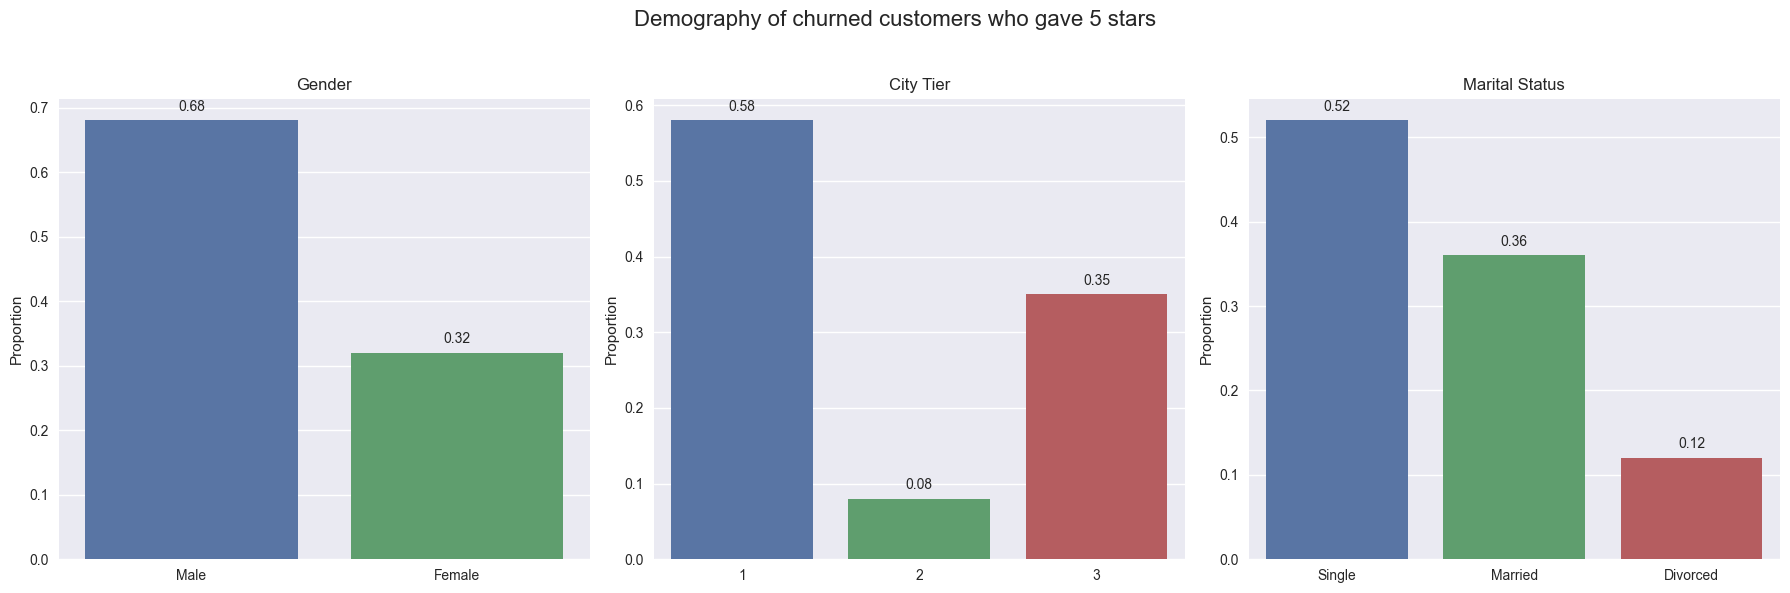

In [59]:
# Subset data
csat_churn_df = df[(df['Churn'] == 1) & (df['SatisfactionScore'] == 5)]

# Calculate proportions
gender_prop = csat_churn_df['Gender'].value_counts(normalize=True).round(2).reset_index()
city_tier_prop = csat_churn_df['CityTier'].value_counts(normalize=True).round(2).reset_index()
marital_status_prop = csat_churn_df['MaritalStatus'].value_counts(normalize=True).round(2).reset_index()

# Rename columns for clarity
gender_prop.columns = ['Gender', 'Proportion']
city_tier_prop.columns = ['CityTier', 'Proportion']
marital_status_prop.columns = ['MaritalStatus', 'Proportion']

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Demography of churned customers who gave 5 stars', fontsize=16)

# Define a helper function to plot bar plots with labels
def plot_bar(data, x, y, ax, title):
    sns.barplot(x=x, y=y, data=data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    # Add labels to each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot each feature's proportions
plot_bar(gender_prop, 'Gender', 'Proportion', axes[0], 'Gender')
plot_bar(city_tier_prop, 'CityTier', 'Proportion', axes[1], 'City Tier')
plot_bar(marital_status_prop, 'MaritalStatus', 'Proportion', axes[2], 'Marital Status')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Note**
- Regardless the demographical data, when we only consider the fact that there are a number of customer who gave high satisfaction score but left, we can say that high satisfaction doesn't guarantee retention. Despite high satisfaction score, these customers after all still decided to leave. 
- Based on the demographic data, we can see that customers who gave a 5-star rating but then left are mostly single men from the top city tier. 
- These specific customers might have specific needs ot expectations are not being met. But this is certainly beyond the current data to explain why customers who gave 5 scores still decided to leave.

### **3.3 Conclusions** <span style='color:red'>TO REVISE</span> summary aja
In this section, our objective is to discover the characteristics of the churned customers, including their demographics and purchasing behaviors, by contrasting them with the loyal ones. In general, customer churn analysis reveals distinct characteristics of customers who no longer make any purchases in the e-commerce platform. We found that churned customers are **predominantly male, single, cellphone users who prefer cash on delivery and frequently purchase phones**. It was also demonstrated that churned and non-churned customers exhibit significant differences: Churned customers usually show shorter tenure, higher satisfaction scores, more device registered, lower cashback amounts, and increased complaints. 

<span style='color:red'>Because it is quite surprising customers who churned left high satisfaction scores, a further examination on the satisfaction score, it was revealed that these customers were sensitive to prormotions. Their high satisfaction was influenced by cashback amount. The recent changes in promotional offers potentially contribute to their decition to leave despite their initial high satisfaction.</span>

- Targeted retention strategies
    - Implement a tiered loyalty program based on customer tenure and purchasing behavior.
    - Reason: The analysis showed that shorter tenure as a factor in churn. A loyalty program can incentivize longer-term customer relationship by offering more interesting rewards. 
- Improve complaint resolution
    - Prioritize investment in a customer support system with a focus on more effective and efficient issue resolution.
    - Reason: The higher complaint among churned customers highlight the importance of excellent customer service. By improving quality of problem solving, the company can enhance customer retention.
- Incorporate ML to flag at-risk customers
    - Devlop a classification model to identify customers at risk of churning and implement proactive retention strategies to mitigate the possibility of churn.
    - Reason: It was found that some customers are more likely to leave (greater churn rate) than others. Finding which customers are more susceptible to churn and providing them with special offers may prevent the churn to really occur.

## **4 Predictive Modeling**

### **4.1 Introduction**
As mentioned earlier in Section 1, one of our primary goals is to build a classification model to help Customer Experience Manager to flag at-risk customers and take data-driven decisitions to prevent customer churn to happen. Unlike the Section 2 in which we used manual data preprocessing, this section will require us to put those preprocessing steps in a pipeline, and thus, reimporting the original dataset is needed. However, before moving forward to the predictive modeling, let us recapitulate what we previously found in Section 2 and Section 3 related to missing values, duplicates, erroneous values, inconsistent values, outliers, cardinality, and distribution of categories in the target variable so we could better decide which data preparation techniques, including cleaning and feature engineering, should be chosen. 
- **Missing values**: All features, namely `Tenure`, `WarehouseToHome`, `HourSpendOnApp`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, and `DaySinceLastOrder`, will missing values are numerical. The missing value rates range between 4.46 and 5.45. In the Section 2, we used Multivariate Iterative Chained Equation (MICE) for inputing the missing values, and the data distributions before and after applying imputation did not change much. For this reason, we would apply the same method for the data imputation. The core difference is in this section, it will be put in a pipeline along with other preprocessing techniques. This pipeline enables us to chain and run multiple ML steps sequentially. 
- **Duplicates**: Duplicates were not found during our initial data inspection but we will confirm this absence as we also need to remove the unique record identifier (`CustomerID`) as it does not mean anything in the modeling process.
- **Erroneous values**: We did not find any erroneous values, e.g., values lower than zeros in `Tenure`, in the dataset so no further check is needed.
- **Inconsistent values**: `PreferredPaymentMode` contains inconsistent values such as `Credit Card` vs `CC` and `Cash on Delivery` vs `COD` in our ealier check. 
- **Outliers**: There are X features, i.e., `Tenure` (0.07%), `WarehouseToHome` (0.04%), `HourSpendOnApp` (0.11%), `NumberOfDeviceRegistered` (7.05%), `NumberOfAddress` (0.07%), `OrderAmountHikeFromlastYear` (0.59%), `CouponUsed` (12.43%), `OrderCount` (13.41%), `DaySinceLastOrder` (1.10%), `CashbackAmount` (7.78%), containing outliers. 
- **Cardinality**: All categorical features indicate low cardinality as the number of unique values is less than 10 and no rare labels at 1% threshold (arbitrary value) were found so no treatment in this section will be necessary.
- **Imbalance target**: As the comparison between churn and non-churned customers in target variable `Churn` is 16.8 and 83.2, the distribution is imbalanced. While it is normal in real life, this moderately imbalanced distribution (see [Google for Developers, 2023](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) for degrees of imbalance) issue will pose a bias challenge to the model, especially to the minority class. 

In addition to recapitulating data sanity issues in the dataset, in this section, we conduct a series of experiments with machine learning algorithms to get the best performing model based on F2 (see the formula below). In short, this metric takes both precision and recall into account yet giving weight twice on recall as the business cost of the type II error is multiple times greater than the type I (Brownlee, 2020, p.66).

$$F_2= \frac{(1+2^2) \times \text{Precision} \times \text{Recall}}{2^2 \times \text{Precision} \times \text{Recall}}$$
- Precision: proportion of customers identified as likely to churn (positive prediction) actually churned (true positive). To get better precision score, then we need to increase the True Positive relative to False Positive. $$\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} +\text{False Positive}}$$
- Recall: proportion of customers who actually churned (positive instance) correectly identified by the model (true positive) so in order to get a better score, TP should be increased and FN should be minimized. $$\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

<span style='color:red'>Explain the general flow of the experiments here</span>
<center>
<img src="../img/evaluationflow.png" alt="Centered Image" style="max-width: 100%; height: auto;">
</center>

### **4.2 Data Preparation**

In [60]:
# import dataset
ml_df = pd.read_excel('../data/E Commerce Dataset.xlsx', sheet_name=1)

ml_df.head()

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1              Mobile                  3        Single                7   
2              Mobile                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4              Mobile                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

**Note**
- As mentioned earlier, a treatment to inconsistent labels, especially in column `PreferredPaymentMode`, must be carried out.
- In machine learning, inconsistent labeling can cause confusion in the model as the model can struggle to learn the correct patterns if different labels for the same entities are treated as distinct.
- The first step to do before the modeling is to normalize the inconsistent labels by changing `CC` and `COD`.

In [61]:
# regularize labels
print('Before regularize labels')
print(ml_df['PreferredPaymentMode'].unique())
print(ml_df['PreferredLoginDevice'].unique())
ml_df['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'}, inplace=True)
ml_df['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'}, inplace=True)
print('\nAfter regularize labels')
print(ml_df['PreferredPaymentMode'].unique())
print(ml_df['PreferredLoginDevice'].unique())

Before regularize labels
['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
['Mobile Phone' 'Phone' 'Computer']

After regularize labels
['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
['Mobile Phone' 'Computer']


In [62]:
# check right/positively skewed cols
right_skewed_columns = {}
for col in ml_df.select_dtypes(include=['number']).columns:
    skewness = ml_df[col].skew()
    if skewness > 0.5:  
        right_skewed_columns[col] = skewness
 
pd.DataFrame(list(right_skewed_columns.items()), columns=['Column', 'Skewness']).round(2)

Column  Skewness
0                         Churn      1.77
1                        Tenure      0.74
2                      CityTier      0.74
3               WarehouseToHome      1.62
4               NumberOfAddress      1.09
5                      Complain      0.95
6   OrderAmountHikeFromlastYear      0.79
7                    CouponUsed      2.55
8                    OrderCount      2.20
9             DaySinceLastOrder      1.19
10               CashbackAmount      1.15

In [63]:
from sklearn.model_selection import train_test_split

X = ml_df.drop(['Churn','CustomerID'], axis=1)
y = ml_df['Churn']

# Split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15 ,stratify=y_train_val, random_state=42)

In [64]:
print("See each dataset shape")
print(f">> Training set : X : {X_train.shape} and y : {y_train.shape} and y proportion : \n{y_train.value_counts()}")
print(f">> Validation set : X : {X_val.shape} and y : {y_val.shape} and y proportion : \n{y_val.value_counts()}")
print(f">> Test set : X : {X_test.shape} and y : {y_test.shape} and y proportion : \n{y_test.value_counts()}")

See each dataset shape
>> Training set : X : (4067, 18) and y : (4067,) and y proportion : 
0    3382
1     685
Name: Churn, dtype: int64
>> Validation set : X : (718, 18) and y : (718,) and y proportion : 
0    597
1    121
Name: Churn, dtype: int64
>> Test set : X : (845, 18) and y : (845,) and y proportion : 
0    703
1    142
Name: Churn, dtype: int64


In [65]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

print(numeric_features)
print(type(numeric_features))
print(categorical_features)
print(len(numeric_features)+len(categorical_features))

['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
<class 'list'>
['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
18


In [66]:
# build class for winsorization
class OutlierHandling(BaseEstimator, TransformerMixin):
    def __init__(self, upper_limit=0.95, lower_limit=0.05):
        self.upper_limit = upper_limit
        self.lower_limit = lower_limit

    def fit(self, X, y=None):
        # calculate the limits for winsorization
        self.lower_bounds_ = np.percentile(X, self.lower_limit * 100, axis=0)
        self.upper_bounds_ = np.percentile(X, self.upper_limit * 100, axis=0)
        return self

    def transform(self, X):
        # winsorize data
        X = np.where(X < self.lower_bounds_, self.lower_bounds_, X)
        X = np.where(X > self.upper_bounds_, self.upper_bounds_, X)
        return X

In [67]:
# define numerical features with missing value
num_features_with_missing = ['Tenure','WarehouseToHome','HourSpendOnApp',
                             'OrderAmountHikeFromlastYear','CouponUsed','OrderCount',
                             'DaySinceLastOrder']

# Create numerical transformer (imputes missing values, then winsorize, scaling, and normalize them)
numerical_transformer1 = Pipeline(steps=[
  ('imputer', IterativeImputer(random_state=42)),
  ('winsor', OutlierHandling(upper_limit=0.90, lower_limit=0.05)),
  ('scaling', RobustScaler()),
  ('skew', PowerTransformer(method="yeo-johnson")) # saran: tidak perlu dimasukkan
])

# define numerical features to scaled and normalized (CashbackAmount, NumberOfAddress,NumberOfDeviceRegistered)
num_features_to_scale = ['CashbackAmount','NumberOfAddress','NumberOfDeviceRegistered']

# create numerical tranformer 2 for three features
numerical_transformer2 = Pipeline(steps=[
    ('scaling', RobustScaler()),
    ('skew', PowerTransformer(method="yeo-johnson")) # saran: tidak perlu dimasukkan
])

# define categorical features to encode
# we already have, the variable called "categorical_features"
categorical_transformer = Pipeline(steps=[
    ('cat', OneHotEncoder(handle_unknown='ignore'))
])

In [68]:
# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num_missing', numerical_transformer1, num_features_with_missing),
        ('num_scaling', numerical_transformer2, num_features_to_scale),
        ('categorical', categorical_transformer, categorical_features)
    ])

# display preprocessing pipeline
display(Pipeline(steps=[
    ('preprocessor', preprocessor)
]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_missing',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(random_state=42)),
                                                                  ('winsor',
                                                                   OutlierHandling(upper_limit=0.9)),
                                                                  ('scaling',
                                                                   RobustScaler()),
                                                                  ('skew',
                                                                   PowerTransformer())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed', 'OrderCount',
                                                   'DaySinceLastOrder']),
                                                 ('num_scaling',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler()),
                                                                  ('skew',
                                                                   PowerTransformer())]),
                                                  ['CashbackAmount',
                                                   'NumberOfAddress',
                                                   'NumberOfDeviceRegistered']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PreferredLoginDevice',
                                                   'PreferredPaymentMode',
                                                   'Gender', 'PreferedOrderCat',
                                                   'MaritalStatus'])]))])

**Note**
- The preprocessor pipeline above perform ansembles different preprocessing tasks on the training data.
    - `num_missing`
        - First, iterative imputer will be applied to numerical features with missing values, namely `Tenure`, `WarehouseToHome`, `HourSpendOnApp`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, `DaySinceLastOrder`.
        - After the data imputation, these features will be passed through class `OutlierHandler` for winsorization as these features are ones which contain outliers (see Section 2.3).
        - As these numerical features have different scales, they need to be rescaled so that different features will have similar values and thus, have equal contributions to the model performance. In other words, rescaling can prevent features with large values to dominate the learning process. In this case, we utilize `RobustScaler` to rescale numerical values in the features mentioned above. This scaler is more robust to outliers than, for example, `StandardScaler` since it uses IQR.
    - `num_scaling`
        - This transformer specifically handles those features which do not have any missing values and outliers, i.e., `CashbackAmount`, `NumberOfAddress`, and `NumberOfDeviceRegistered`.
        - For this reason, they are rescaled directly using `RobustScaler`. 
    - `categorical`
        - This subpipeline deals with categorical features, namely `PreferredLoginDevice`, `PreferredPaymentMode`, `Gender`, `PreferedOrderCat`, `MaritalStatus`. As models can only take numerical values to process, categorical features must be transformed into numerical ones.
    - After the completion, the output of the preprocessor will be passed to another process (e.g., resampling).

### **4.3 Experiment 1: Baseline Models**
This experiment is concerned with creating model benchmarks using different algorithms. Here, we includes stratified k-fold to ensure each fold of the training set maintains the same proportion of the target class label. This is done as the distribution of churned and non-churned customers in the target variable is imbalanced. This technique attempts to mitigate bias in certain fold if the classes are not stratified. Additionally, as this experiment is for bechmarking, we aim to investigate how well the model perform using basic experiment setup without resampling technique to overcome the uneven distribution in the target variable.

<center>
<img src="../img/exp1.png" alt="Centered Image" style="max-width: 100%; height: auto;">
</center>


#### **4.3.1 Compare Models**
Here, we compare different models to identify a baseline performance level. This baseline serves as a reference to evaluate the impact of further treatments, e.g., over-sampling or under-sampling for handling class imbalance.

In [69]:
# define scoring metrics
scoring = {
    'f2_score': make_scorer(fbeta_score, beta=2),
    # precision belum masuk ke sini: perlu ditambah
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# specify models for comparison
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)), 
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(random_state=42, verbose=-100)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# assemble everything in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])) for name, model in classifiers]

# use stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Note**
- In the block of code above we specify the scoring metrics, classifiers, pipeline, and cross-validation technique which will be used in the model comparison.
- In this experiment we extend the pipeline by adding a classifier so after the data is preprocessed the `preprocessor`, it will be fed directly to a classifier.
- As the distribution of the target classes is imbalanced, stratified k-fold CV ensures each subset of training data fed to the classifier has similar proportion of instances.
- By maintaining balanced proportion of the target classes, the training results across subset or fold are expected to be consistent as the variance in the eval metric is kept balanced. 

In [70]:
# evaluate each pipeline
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_scores)
        scores[f"{metric_name}_sd"] = np.std(cv_scores)
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

# dataframe for comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1)
results_df = results_df.set_index('Model')

In [71]:
# display result
results_df.sort_values(by='f2_score', ascending=False)

f2_score  f2_score_sd  accuracy  accuracy_sd  \
Model                                                                  
XGBoost                 0.768795     0.029163  0.937304     0.008009   
LightGBM                0.739402     0.024033  0.930418     0.006734   
Decision Tree           0.734429     0.021580  0.912219     0.005601   
Random Forest           0.712591     0.028490  0.933121     0.006574   
CatBoost                0.706403     0.022039  0.925992     0.006009   
Gradient Boosting       0.571315     0.030584  0.893041     0.005556   
AdaBoost                0.540516     0.024031  0.878043     0.003580   
Support Vector Machine  0.496512     0.045908  0.887140     0.007181   
Logistic Regression     0.436287     0.043627  0.866487     0.008100   
K-Nearest Neighbors     0.419851     0.028071  0.867226     0.006375   

                          recall  recall_sd   roc_auc  roc_auc_sd  \
Model                                                               
XGBoost                 0.748905   0.030830  0.862183    0.016965   
LightGBM                0.716788   0.025031  0.845237    0.013832   
Decision Tree           0.732847   0.033798  0.840699    0.011889   
Random Forest           0.677372   0.031106  0.831147    0.015920   
CatBoost                0.677372   0.022804  0.826859    0.012480   
Gradient Boosting       0.538686   0.033097  0.751749    0.016022   
AdaBoost                0.513869   0.027155  0.732835    0.012473   
Support Vector Machine  0.455474   0.047664  0.715021    0.022355   
Logistic Regression     0.401460   0.044280  0.681065    0.021325   
K-Nearest Neighbors     0.382482   0.027544  0.673943    0.014014   

                        training_time  
Model                                  
XGBoost                      0.717623  
LightGBM                     6.809269  
Decision Tree                0.440515  
Random Forest                1.463256  
CatBoost                    10.847028  
Gradient Boosting            2.099410  
AdaBoost                     0.954830  
Support Vector Machine       3.633615  
Logistic Regression          0.716637  
K-Nearest Neighbors          0.591062

**Note**
- XGBoost, Decision Tree, and LightGBM outperform other classifiers in the basic setups (basic pipeline plus classifier) with F2 scores of 0.7526 $\pm$ 0.0225, 0.7424 $\pm$ 0.0322, and 0.7398	$\pm$ 0.0236, respectively.
- Based on the result of this model comparison, we take the top-three models for hyperparameter tuning.
- Considering the use of grid search which will take time for searching the best parameters, selecting only top-three models for hyperparmeter tuning will be more time-efficient than choosing all models to see the increase or decrease in the evaluation metrics of all models.

#### **4.3.2 Build Classifiers**
In order to focus on saving time and computational resources, here we focus on the three-most promising models, namely XGBoost, Decision Tree, and LightGBM. In addition, our flow in this subsection is to train best models on the training set, and then evaluate each of them on the validation set. This evaluation on the validation set allows us to assess how well each model generalizes to unseen data.

In [72]:
# specify top-3 models
XGBoost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
Decision_Tree = DecisionTreeClassifier()
LightGBM = LGBMClassifier(verbose=-1)

# build pipelines
clf_XGBoost = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', XGBoost)
])
clf_Decision_Tree = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier', Decision_Tree)
])
clf_LightGBM = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LightGBM)
])

# fit each model on training set
clf_XGBoost.fit(X_train, y_train)
clf_Decision_Tree.fit(X_train, y_train)
clf_LightGBM.fit(X_train, y_train)

# evaluate each model on validation set
y_pred_XGBoost = clf_XGBoost.predict(X_val)
y_pred_Decision_Tree = clf_Decision_Tree.predict(X_val)
y_pred_LightGBM = clf_LightGBM.predict(X_val)

In [73]:
# compute F2 score for each model on validation set
f2_XGBoost_exp1 = fbeta_score(y_val, y_pred_XGBoost, beta=2)
f2_Decision_Tree_exp1 = fbeta_score(y_val, y_pred_Decision_Tree, beta=2)
f2_LightGBM_exp1 = fbeta_score(y_val, y_pred_LightGBM, beta=2)

# print F2 Score for each model on validation set
print('============================')
print(f'F2 Score XGBoost    : {f2_XGBoost_exp1:.4f}')
print(f'F2 Score DT         : {f2_Decision_Tree_exp1:.4f}')
print(f'F2 Score LightGBM   : {f2_LightGBM_exp1:.4f}')
print('============================')

F2 Score XGBoost    : 0.8574
F2 Score DT         : 0.8604
F2 Score LightGBM   : 0.7612


**Note**
- On validation set, XGBoost is best-performing model among top three. This means that XGBoost is likely to the most effective model.
- However, since it is the top baseline models' performance, there aree possibilities that these models can be further improved such as tuning and giving other treatments.

#### **4.3.3 Hyperparameter Tuning**
Baseline models actually can be used right away with hyperparameter tuning for a fast and straightforward step to see the initial model's performance but we proceed with tuning the baseline models to get the best possible baseline model. In tuning the models, we utilize grid search technique to optimize the performance of those models. Grid search evaluates all possible combinations of hyperparameters. Unlike random search, grid search is more thorough as this technique tests all possible combinations of hyperparameters with cost of heavier computation. 

In [74]:
# define F2 score scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# define the parameter grids
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

# define metrics 
scoring = {
    'f2_score': f2_scorer,
    'accuracy': 'accuracy',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

In [75]:
# init GridSearchCV
grid_search_xgb = GridSearchCV(clf_XGBoost, param_grid_xgb, cv=5, scoring=scoring, refit='f2_score', n_jobs=-1)

# fit model
start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
end_time = time.time()
time_xgb = end_time - start_time
print(f"Time taken for XGBoost: {time_xgb:.2f} seconds")

Time taken for XGBoost: 49.41 seconds


**Note**: The block of codes initialize hyperparameter tuning process for each top-three models using `GridSearchCV`. This tuning technique will exhausitvely search best combinations of parameters specified in the previous code block using F2 as the scoring metric to evaluate each model's performance.

In [76]:
pd.options.display.max_colwidth = None

best_index = grid_search_xgb.best_index_
std_test_score = grid_search_xgb.cv_results_['std_test_f2_score'][best_index]

# Store tuned version result
exp1_tuned = pd.DataFrame({
    'Name': ['Exp1'],
    'Model': ['XGBoost'],
    'Best Parameters': [
        grid_search_xgb.best_params_,
    ],
    'Best F2 Score': [
        grid_search_xgb.best_score_,
    ],
    'Std': [
        std_test_score,
    ]
})

exp1_tuned

Name    Model  \
0  Exp1  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}   

   Best F2 Score       Std  
0       0.792599  0.021858

In [77]:
# untuned version for comparison
results_df.sort_values(by='f2_score',ascending=False).reset_index().round(4).iloc[:1, :]

Model  f2_score  f2_score_sd  accuracy  accuracy_sd  recall  recall_sd  \
0  XGBoost    0.7688       0.0292    0.9373        0.008  0.7489     0.0308   

   roc_auc  roc_auc_sd  training_time  
0   0.8622       0.017         0.7176

**Note**
- After hyperparameter tuning, Light Gradient Boosting Machine becomes the highest performing modeel with an F2 score of 0.7970.
- This model shows a considerable increase from 0.7398 to 0.7970.

In [78]:
# eval the best models on the validation set
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
f2_XGBoost_exp1_tuned = fbeta_score(y_val, y_pred_xgb, beta=2, average="weighted")

# print F2 score of models on val sets
print('============================')
print(f'F2 Score XGBoost    : {f2_XGBoost_exp1_tuned:.4f}')
print('============================')

F2 Score XGBoost    : 0.9704


**Note**
- While the F2 score of LightGBM performance on training set was the highest among the three, XGboost performance remains on the top when being tested on the validation set.
- XGBoost achieves an F2 score of 0.9704.
- Furthermore, based on the classification reports for each model below, XGBoost also shows reasonably good performance across different classes (`1` vs `0`).

In [79]:
# compare performance before and after tuning
pd.DataFrame({'Status':['Before Tuning', 'After Tuning'],
              'F2 Score': [f2_XGBoost_exp1, f2_XGBoost_exp1_tuned]}).round(4)

Status  F2 Score
0  Before Tuning    0.8574
1   After Tuning    0.9704

Another way of evaluating the performance of the best model from this experiment is by testing the model against the test set using a confusion matrix. The matrix compares the predicted labels from the model against the actual labels from the data.

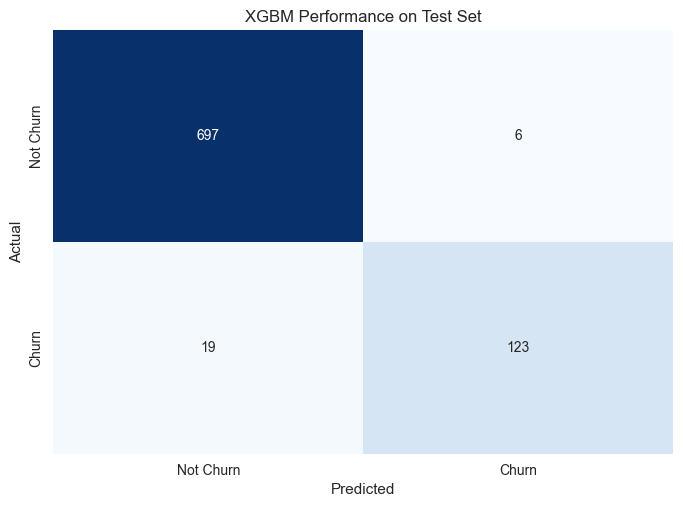

In [80]:
# get confusion matrix
y_pred_xgb = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)

# display confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBM Performance on Test Set')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

In [81]:
# simulate misclassification cost
FP_cost = 17.2
FN_cost = 86
FP_exp1 = 6
FN_exp1 = 19
total_cost_exp1 = (FP_exp1 * FP_cost) + (FN_exp1 * FN_cost)
total_cost_exp1

1737.2

From the confusion matrix, we can evaluate the performance of the best model from this experiment, namely XGBoost, in predicting customer churns. Just for recap, the business cost for each false positive (FP) is USD98.268 (Average Order Value) per user, and the financial cost faced per each false negative is USD1,620 (Average Revenue per User).
- False positive (actual 0, predicted 1): 6 errors $\times$ USD17.2 = USD103.19
- False negative (actual 1, predicted 0): 19 errors $\times$ USD86 = USD1,634

Based on these misclassifications made by the model, the total financial cost will be USD1,737.2

### **4.4 Experiment 2: Adaptive Synthetic Resampling (ADASYN)**
As we demonstrated earlier in Section 3, the distribution between churn class 1 and class 0 is uneven. This experiment attempts to investigate the effect of Adaptive Synthetic Sampling (ADASYN) on three models we obtained from the experiment 1. ADASYN in brief is an oversampling technique for addressing class imbalance classification problem by generating synthetic instances ([He et al, 2008](https://doi.org/10.1109/IJCNN.2008.4633969)). Unlike Synthetic Minority Over-sampling Technique (SMOTE), however, ADASYN focus more on instances where the model struggles to classify.

#### **4.4.1 Build Classifiers**
Here, we build three classifiers based on the top-three performing models in experiment 1 (Section 4.3.1), namely XGBoost, Decision Tree, and LightGBM. In the pipeline, we include ADASYN as a resampling technique. 

While these models are inherently robust to class imbalance due to their ensemble nature (they already have built-in mechanism to handle class imbalance), we still experiement using ADASYN. This oversampling technique increases the number of minority class samples, and hence, help to reduce bias towards the majority class. 
- XGBoost and LightGBM uses gradient boosting to gradually improve its performance on the minority class. 

In [82]:
# list models for comparison
XGBoost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
Decision_Tree = DecisionTreeClassifier()
LightGBM = LGBMClassifier(verbose=-1) 

# build pipelines
clf_XGBoost = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', XGBoost)
])
clf_Decision_Tree = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', Decision_Tree)
])
clf_LightGBM = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', LightGBM)
])

In [83]:
# fit each model on the training set
clf_XGBoost.fit(X_train, y_train)
clf_Decision_Tree.fit(X_train, y_train)
clf_LightGBM.fit(X_train, y_train)

# evaluate model on validation set
y_pred_XGBoost = clf_XGBoost.predict(X_val)
y_pred_Decision_Tree = clf_Decision_Tree.predict(X_val)
y_pred_LightGBM = clf_LightGBM.predict(X_val)

# compute f2 on validation set
f2_XGBoost_exp2 = fbeta_score(y_val, y_pred_XGBoost, beta=2)
f2_Decision_Tree_exp2 = fbeta_score(y_val, y_pred_Decision_Tree, beta=2)
f2_LightGBM_exp2 = fbeta_score(y_val, y_pred_LightGBM, beta=2)

In [84]:
# print f2 score for each model on val set
print('============================')
print("F2 score on validation set")
print(f'F2 Score XGBoost    : {f2_XGBoost_exp2:.4f}')
print(f'F2 Score DT         : {f2_Decision_Tree_exp2:.4f}')
print(f'F2 Score LightGBM   : {f2_LightGBM_exp2:.4f}')
print('============================')

F2 score on validation set
F2 Score XGBoost    : 0.8460
F2 Score DT         : 0.7851
F2 Score LightGBM   : 0.7908


**Note**
- The outputs above summarizes the performance of three classifiers on the validation set. In short, similar to the untuned versions of these three models in Experiment 1, XGbost <span style='color:red'>remains the best performing model.</span>
- On the other hand, the performance scores appear to be lower in comparison to those in Experiment 1 (see the scores below)
- Decision tree has a significant decrease in this experiment setup. Previously in Experiment 1, the F2 score of decision tree was 0.8548 but it is now 0.7977.

In [85]:
print('Experiment 1 result')
print('Model performance on validation set:')
pd.DataFrame({
    'Model': ['XGBoost', 'Decision Tree', 'LightGBM'],
    'F2Score': [f2_XGBoost_exp1, f2_Decision_Tree_exp1, f2_LightGBM_exp1] 
})

Experiment 1 result
Model performance on validation set:


Model   F2Score
0        XGBoost  0.857385
1  Decision Tree  0.860390
2       LightGBM  0.761246

#### **4.4.2 Hyperparameter Tuning**

In [86]:
# Initialize GridSearchCV for each model
grid_search_xgb = GridSearchCV(clf_XGBoost, param_grid_xgb, cv=5, scoring=scoring, refit='f2_score', n_jobs=-1, return_train_score=True)

# Fit the models and calculate time taken for each
fit_start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
fit_end_time = time.time()
time_xgb = fit_end_time - fit_start_time
print(f"Time taken for tuning XGBoost: {time_xgb:.2f} seconds")

Time taken for tuning XGBoost: 127.26 seconds


In [87]:
pd.options.display.max_colwidth = None

best_index = grid_search_xgb.best_index_
std_test_score = grid_search_xgb.cv_results_['std_test_f2_score'][best_index]

# Store tuned version result
exp2_tuned = pd.DataFrame({
    'Name': ['Exp2'],
    'Model': ['XGBoost'],
    'Best Parameters': [
        grid_search_xgb.best_params_,
    ],
    'Best F2 Score': [
        grid_search_xgb.best_score_,
    ],
    'SD': [
        std_test_score,
    ]
})

exp2_tuned

Name    Model  \
0  Exp2  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score        SD  
0       0.792151  0.037436

In [88]:
# Evaluate the best models on the validation set
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
f2_XGBoost_exp2_tuned = fbeta_score(y_val, y_pred_xgb, beta=2, average="weighted")

# Print F2 Score for Each Model on Validation Sets
print('========================')
print(f'F2 Score XGBoost: {f2_XGBoost_exp2:.4f}')
print('========================')

# Print Classification Report of Each Model on Validation Sets
print('XGBoost Classification Report')
print(classification_report(y_val, y_pred_xgb))

F2 Score XGBoost: 0.8460
XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       597
           1       0.94      0.84      0.89       121

    accuracy                           0.97       718
   macro avg       0.96      0.92      0.94       718
weighted avg       0.96      0.97      0.96       718



**Note**; The F2 score of XGBoost before hyperparameter tuning was 0.8460, and after tuning, the score remains the same at 0.8460, meaning that the hyperparameter tuning does not increase the model's performance against the validation set.

In [89]:
# display f2 score on validation set
pd.DataFrame({'Status':['Before Tuning', 'After Tuning'],
              'F2 Score': [f2_XGBoost_exp2, f2_XGBoost_exp2_tuned]}).round(4)

Status  F2 Score
0  Before Tuning    0.8460
1   After Tuning    0.9647

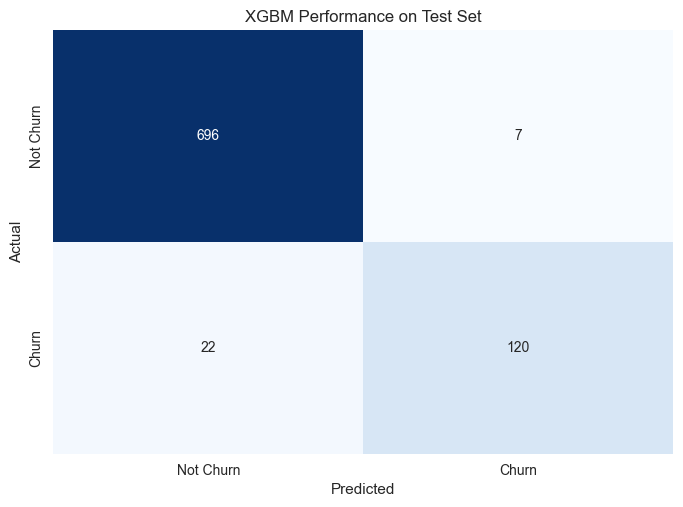

In [90]:
y_pred_xgb = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBM Performance on Test Set')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

In [91]:
# simulate misclassification cost
FP_cost = 17.2
FN_cost = 86
FP_exp2 = 7
FN_exp2 = 22
total_cost_exp2 = (FP_exp2 * FP_cost) + (FN_exp2 * FN_cost)
total_cost_exp2

2012.4

**Note**
- Given the cost of FP and FN mentioned in the Introduction (section 1.5), here is the breakdown of the financial cost of the model's misclassifications.
    - False Positive: 7 errors $\times$ USD17.2 = USD120.39
    - False Negative: 22 errors $\times$ USD86 = USD1,892
- In total, the cost the company needs to pay for the misclassifications is USD**Note**
- Given the cost of FP and FN mentioned in the Introduction (section 1.5), here is the breakdown of the financial cost of the model's misclassifications.
    - False Positive: 7 errors $\times$ USD17.2 = USD120.39
    - False Negative: 22 errors $\times$ USD86 = USD1,892
- In total, the cost the company needs to pay for the misclassifications is USD2012.4

### **4.5 Experiment 3: Synthetic Minority Oversampling Technique (SMOTE)**
Since the distribution of target variable is uneven, balancing the proportion of distribution is vital. Synthetic Minority Over-sampling Technique (SMOTE) is an oversampling technique to address an imbalance problem in dataset. In short, SMOTE generate synthetic samples from the minority class to balance its distribution by using *k*-Nearest Neighbor of samples from the minority class ([Chawla et al, 2002, p.328](https://doi.org/10.1613/jair.953)). 

Here we experiment using SMOTE to handle the imbalanced problem in our target variable. By exploiting this sampling technique, we expect that the model can perform better in identifying both classes (1 and 0). And as a result, the model can make better predictions for the class with lower frequency. 

#### **4.5.1 Build Classifiers**

In [92]:
# list of top 3 models to compare
XGBoost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
Decision_Tree = DecisionTreeClassifier()
LightGBM = LGBMClassifier(verbose=-1) 

# build classifiers
clf_XGBoost = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBoost)
])
clf_Decision_Tree = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', Decision_Tree)
])
clf_LightGBM = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LightGBM)
])

In [93]:
# fit each model on training set
clf_XGBoost.fit(X_train, y_train)
clf_Decision_Tree.fit(X_train, y_train)
clf_LightGBM.fit(X_train, y_train)

# evaluate each model on validation sets
y_pred_XGBoost = clf_XGBoost.predict(X_val)
y_pred_Decision_Tree = clf_Decision_Tree.predict(X_val)
y_pred_LightGBM = clf_LightGBM.predict(X_val)

# compute F2 score for each model on validation sets
f2_XGBoost_exp3 = fbeta_score(y_val, y_pred_XGBoost, beta=2)
f2_Decision_Tree_exp3 = fbeta_score(y_val, y_pred_Decision_Tree, beta=2)
f2_LightGBM_exp3 = fbeta_score(y_val, y_pred_LightGBM, beta=2)

In [94]:
# Print F2 Score fore Each Model on Validation Sets
print('============================')
print("F2 score on validation set")
print(f'F2 Score XGBoost    : {f2_XGBoost_exp3:.4f}')
print(f'F2 Score DT         : {f2_Decision_Tree_exp3:.4f}')
print(f'F2 Score LightGBM   : {f2_LightGBM_exp3:.4f}')
print('============================')

F2 score on validation set
F2 Score XGBoost    : 0.8062
F2 Score DT         : 0.7886
F2 Score LightGBM   : 0.7509


In [95]:
print('Experiment 1 result')
print('Model performance on validation set:')
pd.DataFrame({
    'Model': ['XGBoost', 'Decision Tree', 'LightGBM'],
    'F2Score': [f2_XGBoost_exp1, f2_Decision_Tree_exp1, f2_LightGBM_exp1] 
})

Experiment 1 result
Model performance on validation set:


Model   F2Score
0        XGBoost  0.857385
1  Decision Tree  0.860390
2       LightGBM  0.761246

**Note**
- Similar to Experiment 2, utilizing oversampling with ADASYN, XGBoost is the best performing model with F2 score of 0.8062.
- Another similarity between this experiment and Experiment 2 is that all three models do not indicate better F2 scores in comparison to Experiment 1. Instead, after adding SMOTE to handle imbalance data, the F2 scores in these three models dropped.
- Now let us see how the model perform in the unseen data (validation set) after performing hyperparameter tuning using GridSearchCV.

#### **4.5.2 Hyperparameter Tuning**

In [96]:
# dictionary for storing multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
    'f2_score': f2_scorer
}

# initialize GridSearchCV for each model
grid_search_xgb = GridSearchCV(clf_XGBoost, param_grid_xgb, cv=5, scoring=scoring, refit='f2_score', n_jobs=-1)

In [97]:
# fit the models 
fit_start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
fit_end_time = time.time()
time_xgb = fit_end_time - fit_start_time
print(f"Time taken for tuning XGBoost: {time_xgb:.2f} seconds")

Time taken for tuning XGBoost: 130.10 seconds


In [98]:
pd.options.display.max_colwidth = None

best_index = grid_search_xgb.best_index_
std_test_score = grid_search_xgb.cv_results_['std_test_f2_score'][best_index]

# Store tuned version result
exp3_tuned = pd.DataFrame({
    'Name': ['Exp3'],
    'Model': ['XGBoost'],
    'Best Parameters': [
        grid_search_xgb.best_params_,
    ],
    'Best F2 Score': [
        grid_search_xgb.best_score_,
    ],
    'Std': [
        std_test_score,
    ]
})

exp3_tuned

Name    Model  \
0  Exp3  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score       Std  
0       0.795829  0.041794

In [99]:
# Evaluate the best models on the validation set
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
f2_XGBoost_exp3_tuned = fbeta_score(y_val, y_pred_xgb, beta=2, average="weighted")

# Print F2 Score for Each Model on Validation Sets
print('========================')
print(f'F2 Score XGBoost: {f2_XGBoost_exp3_tuned:.4f}')
print('========================')

F2 Score XGBoost: 0.9691


In [100]:
pd.DataFrame({'Status':['Before Tuning', 'After Tuning'],
              'F2 Score': [f2_XGBoost_exp3, f2_XGBoost_exp3_tuned]}).round(4)

Status  F2 Score
0  Before Tuning    0.8062
1   After Tuning    0.9691

**Note**: There is a substantial increase in the F2 score after hyperparameter tuning on XGBoost. Before tuning, the F2 score was only 0.8062, and after tuning, the performance rose into 0.9691, indicating better performance.

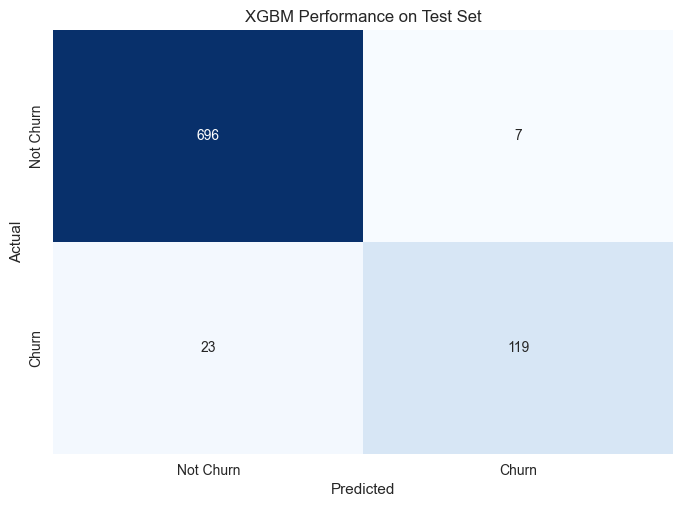

In [101]:
y_pred_xgb = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBM Performance on Test Set')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

In [102]:
# simulate misclassification cost
FP_cost = 17.2
FN_cost = 86
FP_exp3 = 7
FN_exp3 = 23
total_cost_exp3 = (FP_exp3 * FP_cost) + (FN_exp3 * FN_cost)
total_cost_exp3

2098.4

**Note**
- Considering the FP cost is USD98.268 and the FN cost is USD1,620, the business impact of the model is as follows.
- FP (actual 0, predicted 1): 7 errors $\times$ USD17.2 = USD120.39
- FN (actual 1, predicted 0): 23 errors $\times$ USD86 = USD1,978
- The total cost due to misclassifications is USD2,098.4

### **4.6 Experiment 4: NearMiss Version 3**
In this experiment, we exploit how NearMiss, particularly version 3, handles the imbalance class problem in the training set. NearMiss version 3 addresses imbalance class problem by under-sampling the size of the majority class. It uses kNN to find the closest instances from the majority class to each minority class instance ([Mani & Zhang, 2003](http://dx.doi.org/10.4236/jilsa.2015.74010)). After the identification, it keeps those majority class instances closest to the minority class instances. The process continues until the distribution of both classes find balance.

#### **4.6.1 Build Classifiers**

In [103]:
# list of top 3 models to compare
XGBoost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
Decision_Tree = DecisionTreeClassifier()
LightGBM = LGBMClassifier(verbose=-1) 

# build classifiers
clf_XGBoost = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('nearmiss', NearMiss(version=3)),
    ('classifier', XGBoost)
])
clf_Decision_Tree = ImbPipeline(steps=[
    ('preprocessor',preprocessor),
    ('nearmiss', NearMiss(version=3)),
    ('classifier', Decision_Tree)
])
clf_LightGBM = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('nearmiss', NearMiss(version=3)),
    ('classifier', LightGBM)
])

In [104]:
# fit each model on training set
clf_XGBoost.fit(X_train, y_train)
clf_Decision_Tree.fit(X_train, y_train)
clf_LightGBM.fit(X_train, y_train)

# evaluate each model on validation sets
y_pred_XGBoost = clf_XGBoost.predict(X_val)
y_pred_Decision_Tree = clf_Decision_Tree.predict(X_val)
y_pred_LightGBM = clf_LightGBM.predict(X_val)

# compute F2 score for each model on validation sets
f2_XGBoost_exp4 = fbeta_score(y_val, y_pred_XGBoost, beta=2)
f2_Decision_Tree_exp4 = fbeta_score(y_val, y_pred_Decision_Tree, beta=2)
f2_LightGBM_exp4 = fbeta_score(y_val, y_pred_LightGBM, beta=2)

In [105]:
# print F2 score for each model on val set
print('============================')
print("F2 score on validation set")
print(f'F2 Score XGBoost    : {f2_XGBoost_exp4:.4f}')
print(f'F2 Score DT         : {f2_Decision_Tree_exp4:.4f}')
print(f'F2 Score LightGBM   : {f2_LightGBM_exp4:.4f}')
print('============================')

F2 score on validation set
F2 Score XGBoost    : 0.8485
F2 Score DT         : 0.7444
F2 Score LightGBM   : 0.8221


**Note**
- Using validation set, similar to Experiment 1 and 2, XGBoost remains the top performing model with F2 score of 0.8485.
- However, the score of the best model here is lower than the baseline model's performance at 0.8574 (see below).
- From this result, then we can judge that adding the undersampling technique to balance the target classes does not make the models perform better. 

In [106]:
print('Experiment 1 result')
print('Model performance on validation set:')
pd.DataFrame({
    'Model': ['XGBoost', 'Decision Tree', 'LightGBM'],
    'F2Score': [f2_XGBoost_exp1, f2_Decision_Tree_exp1, f2_LightGBM_exp1] 
})

Experiment 1 result
Model performance on validation set:


Model   F2Score
0        XGBoost  0.857385
1  Decision Tree  0.860390
2       LightGBM  0.761246

#### **4.6.2 Hyperparameter Tuning**

In [107]:
# Initialize GridSearchCV for each model
grid_search_xgb = GridSearchCV(clf_XGBoost, param_grid_xgb, cv=5, scoring=scoring, refit='f2_score', n_jobs=-1)

# fit the models 
fit_start_time = time.time()
grid_search_xgb.fit(X_train, y_train)
fit_end_time = time.time()
time_xgb = fit_end_time - fit_start_time
print(f"Time taken for tuning XGBoost: {time_xgb:.2f} seconds")

Time taken for tuning XGBoost: 49.89 seconds


In [108]:
pd.options.display.max_colwidth = None

best_index = grid_search_xgb.best_index_
std_test_score = grid_search_xgb.cv_results_['std_test_f2_score'][best_index]

# Store tuned version result
exp4_tuned = pd.DataFrame({
    'Name': ['Exp 4'],
    'Model': ['XGBoost'],
    'Best Parameters': [
        grid_search_xgb.best_params_,
    ],
    'Best F2 Score': [
        grid_search_xgb.best_score_,
    ],
    'Std': [
        std_test_score,
    ]
})

exp4_tuned

Name    Model  \
0  Exp 4  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score       Std  
0       0.785178  0.040837

In [109]:
# Evaluate the best models on the validation set
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
f2_XGBoost_exp4_tuned = fbeta_score(y_val, y_pred_xgb, beta=2, average="weighted")
# Print F2 Score for Each Model on Validation Sets
print('========================')
print(f'F2 Score XGBoost: {f2_XGBoost_exp4_tuned:.4f}')
print('========================')

# # Print Classification Report of Each Model on Validation Sets
# print('XGBoost Classification Report')
# print(classification_report(y_val, y_pred_xgb))

F2 Score XGBoost: 0.8978


In [110]:
pd.DataFrame({'Status':['Before Tuning', 'After Tuning'],
              'F2 Score': [f2_XGBoost_exp4, f2_XGBoost_exp4_tuned]}).round(4)

Status  F2 Score
0  Before Tuning    0.8485
1   After Tuning    0.8978

**Note**: After tuning, the XGBoost model shows a significant increase in F2 score, especially in the validation set. The F2 score rises from 0.8485 to 0.8978, indicating a good impact of hyperparameter tuning on the model's performance.

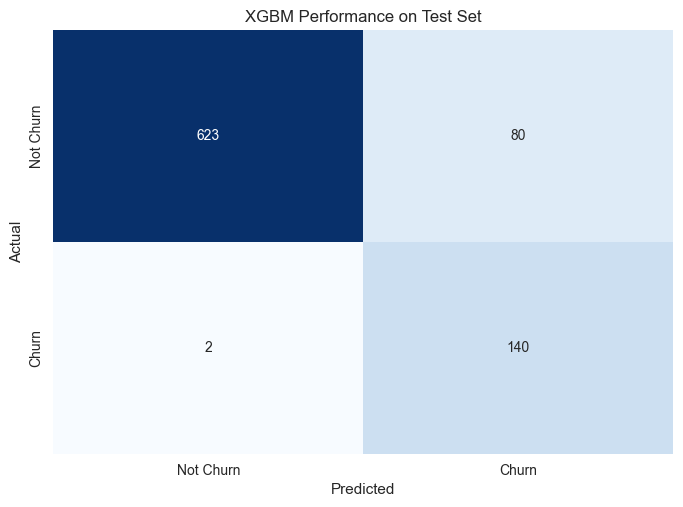

In [111]:
y_pred_xgb = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBM Performance on Test Set')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

In [112]:
# simulate misclassification cost
FP_cost = 17.2
FN_cost = 86
FP_exp4 = 80
FN_exp4 = 2
total_cost_exp4 = (FP_exp4 * FP_cost) + (FN_exp4 * FN_cost)
total_cost_exp4

1548.0

- Just to recap, the cost per false positive is USD17.2, and the financial cost for each false positive is USD80.
- False positive (actual 0, predicted 1): 80 errors $\times$ USD17.2 = USD1,376
- False negative (actual 1, predicted 0): 2 errors $\times$ USD86 = USD172
- In total, the financial cost faced by the e-commerce company due to the model's misclassification is USD1,548.

## **5 Best Model Selection and Explanation**

### **5.1 Best Model Selection**
In this section, we evaluate the results of our experiments based on the model's performance and the misclassification costs on the testing data. Beforehand, let us recap the experiment setups done earlier.
- **Experiment 1**: Baseline models. We compared different models using basic setups. Here we focused on models' performance without addressing data imbalance. The top-three models were tuned and being compared (tuned vs untuned).
- **Experiment 2**: Adaptive Synthetic Sampling (ADASYN). This experiment used ADASYN for the data imbalance problem on the top-three models we got from Experiment 1. The F2 scores of the three models were not only used to compare between models but also between tuned and untuned versions.
- **Experiment 3**: Synthetic Minority Over-sampling Technique (SMOTE). The setup for Experiment 3 is similar to the Experiment 2, except the data imbalance treatment. Here, we utilized how the model performed when the data imbalanced was handled using SMOTE.
- **Experiment 4**: NearMiss Version 3. In this experiment, we used undersampling technique to address the problem of data imbalance. 

#### **5.1.1 Model Performance on the Data Training**

In [113]:
# display best param in exp3
display(exp1_tuned.round(4), exp2_tuned.round(4), exp3_tuned.round(4), exp4_tuned.round(4))

Name    Model  \
0  Exp1  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}   

   Best F2 Score     Std  
0         0.7926  0.0219

Name    Model  \
0  Exp2  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score      SD  
0         0.7922  0.0374

Name    Model  \
0  Exp3  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score     Std  
0         0.7958  0.0418

Name    Model  \
0  Exp 4  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score     Std  
0         0.7852  0.0408

In [114]:
print(f"F2 score in Experiment 1: {0.7926-0.0219:.4f} and {0.7926+0.0219:.4f}")
print(f"F2 score in Experiment 2: {0.7922-0.0374:.4f} and {0.7922+0.0374:.4f}")
print(f"F2 score in Experiment 3: {0.7958-0.0418:.4f} and {0.7958+0.0418:.4f}")
print(f"F2 score in Experiment 4: {0.7852-0.0408:.4f} and {0.7852+0.0408:.4f}")

F2 score in Experiment 1: 0.7707 and 0.8145
F2 score in Experiment 2: 0.7548 and 0.8296
F2 score in Experiment 3: 0.7540 and 0.8376
F2 score in Experiment 4: 0.7444 and 0.8260


**Note**: Based on the F2 scores, the performance of the best model, i.e., XGBoost, from Experiment 3 indicates the highest score (0.7958 $\pm$ 0.0418) with the specified params above. But since it is only a comparison between experiments based on the training data, we also need to consider the models' performance on validation data.

#### **5.1.2 Model Performance on the Validation Data**

In [115]:
print('Comparison between experiments validation set:')
pd.DataFrame({'Status':['Before Tuning', 'After Tuning'],
              'F2 Score Exp 1': [f2_XGBoost_exp1, f2_XGBoost_exp1_tuned],
              'F2 Score Exp 2': [f2_XGBoost_exp2, f2_XGBoost_exp2_tuned],
              'F2 Score Exp 3': [f2_XGBoost_exp3, f2_XGBoost_exp3_tuned],
              'F2 Score Exp 4': [f2_XGBoost_exp4, f2_XGBoost_exp4_tuned]
              }).round(4)

Comparison between experiments validation set:


Status  F2 Score Exp 1  F2 Score Exp 2  F2 Score Exp 3  \
0  Before Tuning          0.8574          0.8460          0.8062   
1   After Tuning          0.9704          0.9647          0.9691   

   F2 Score Exp 4  
0          0.8485  
1          0.8978

**Note**: As can be seen, all models improved significantly after hyperparameter tuning on the validation data (separate data from the training set). Based on the models' F2 scores, XGBoost from Experiment 1 showed the highest score, making it a good candidate for the final model. However, the highest F2 score on the unseen data (validation set) does not always mean that the model is the most cost-saving option for the business. For this reason, taking cost-saving analysis into consideration is pivotal.

#### **5.1.3 Model Performance on the Data Test**

In [116]:
pd.DataFrame({
    'Name': ['Experiment 1', 'Experiment 2', 
             'Experiment 3', 'Experiment 4'],
    'TotalFP': [FP_exp1, FP_exp2, FP_exp3, FP_exp4],
    'TotalFN':[FN_exp1, FN_exp2, FN_exp3, FN_exp4],
    'MisclassificationCost': [total_cost_exp1, total_cost_exp2, 
                              total_cost_exp3, total_cost_exp4]
})

Name  TotalFP  TotalFN  MisclassificationCost
0  Experiment 1        6       19                 1737.2
1  Experiment 2        7       22                 2012.4
2  Experiment 3        7       23                 2098.4
3  Experiment 4       80        2                 1548.0

**Note**: 
- To recap, the table above summarizes the misclassification analysis which was done in each experiment. For more details, the numbers of false positives and false negatives can be seen in each experiments. 
- As shown on the table, XGboost model from Experiment 4 indicates the most cost-saving option for the business regardless of the lowest F2 score. The model effectively decreased misclassification, particularly false negatives.

#### **5.1.4 Decision**
In brief, we evaluated the outputs of four experiments based on different criteria: model performance on the training data, validation data, and test data. In each experiment, the best model was XGBoost. The highest F2 score on the training data was achieved by XGBoost from Experiment 3 using SMOTE. However, this model's performance was not as good as XGBoost from Experiment 1 when tested on the validation data. Although the baseline model from Experiment 1 outperformed others across experiments, XGBoost from Experiment 4 using NearMiss version 3 proved more effective in reducing misclassification costs. Therefore, we have selected XGBoost using NearMiss as our final model.

### **5.2 Best Model Evaluation**

#### **5.2.1 Classification Report**
A classification report is a summary showing how well a classification model performs. It provides key metrics such as precision (how many predicted positives are actually correct), recall (how many actual positives were correctly predicted), and F1 score (a balance between precision and recall). It also includes accuracy, which measures the overall correctness of the model. The report below breaks these metrics down for each class in the dataset, giving us a clear view of the model's strengths and weaknesses in making predictions.

In [198]:
# get best param of exp4
exp4_tuned.round(4)

Name    Model  \
0  Exp 4  XGBoost   

                                                                                                                                                      Best Parameters  \
0  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}   

   Best F2 Score     Std  
0         0.7852  0.0408

In [199]:
# define the final model with the tuned parameters
final_model = XGBClassifier(colsample_bytree = 0.8, 
                            learning_rate = 0.1, 
                            max_depth = 7, 
                            n_estimators = 300, 
                            subsample = 1.0,
                            use_label_encoder=False, 
                            eval_metric='logloss')

# build the pipeline
clf_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smote', SMOTE(random_state=42)),
    # ('adasyn', ADASYN(random_state=42)),
    ('nearmiss', NearMiss(version=3)),
    ('classifier', final_model)
])

# fit the pipeline on the training data
clf_final.fit(X_train, y_train)

# Predict on the test set
y_pred_test = clf_final.predict(X_test)

# Evaluate the performance on the test set
f2_score_test = fbeta_score(y_test, y_pred_test, beta=2)

# Print the F2 score
print(f'F2 Score on Test Set: {f2_score_test:.4f}')
print(classification_report(y_test, y_pred_test))

F2 Score on Test Set: 0.8883
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       703
           1       0.64      0.99      0.77       142

    accuracy                           0.90       845
   macro avg       0.82      0.94      0.86       845
weighted avg       0.94      0.90      0.91       845



**Note**: The F2 score on the test set is 0.8883, indicating that the model is well-optimized for minimizing the financial cost of type II errors, which is crucial for our business context. The precision for predicting churn (class 1) is 0.64, meaning that 64% of the predicted churn instances were correct. The recall for churn is very high at 0.99, showing that the model captures almost all actual churn cases. Despite a lower precision for churn, the overall accuracy is 0.90, with a strong F1 score for both classes. This suggests that while the model is excellent at identifying nearly all churn cases, it has a moderate number of false positives, which is acceptable given the high recall and the business cost of missing churn predictions.

#### **5.2.2 ROC-AUC Curve**
The ROC-AUC curve evaluates how well a classification model distinguishes between two classes (`1` for Churn and `0` for Not Churn). The ROC curve plots the true positive rate (how many actual positives or churns are correctly identified) against the false positive rate (how many actual negatives or not churn are incorrectly identified as positives (churns)) at various threshold settings. The AUC, or Area Under the Curve, measures the overall performance: a higher AUC value (closer to 1) means the model is better at distinguishing between classes.

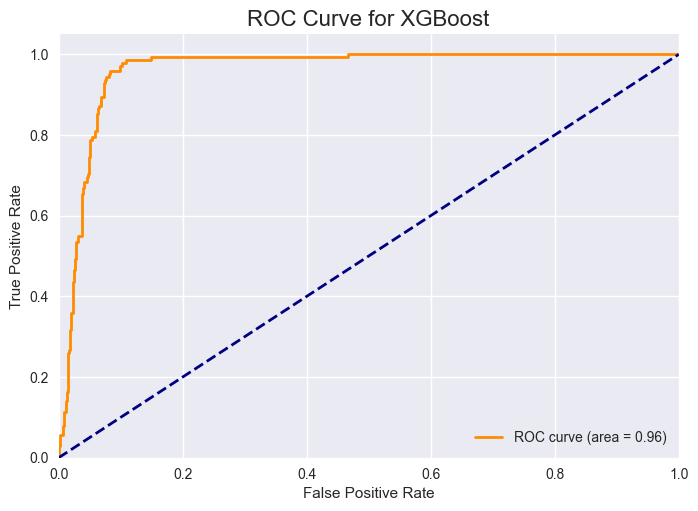

In [200]:
# Plot ROC AUC curve
y_pred_proba = clf_final.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost', fontsize=16)
plt.legend(loc="lower right")
plt.show()

**Note**: The ROC curve for the XGBoost model shows an area under the curve (AUC) of 0.96, indicating very good performance in distinguishing between churned and non-churned customers. The curve closely follows the top left corner, which signifies a high true positive rate and a low false positive rate. This suggests the model is effective at correctly identifying customers who are likely to churn while minimizing false alarms. The noticeable gap between the ROC curve and the diagonal line (representing random chance) highlights the model’s strong discriminative power. Overall, this ROC-AUC curve suggests that the XGBoost model is a useful tool for predicting customer churn.

#### **5.2.3 Precision-Recall Curve**
A precision-recall shows the trade-off between precision (how many of the predicted positive cases are actually positive) and recall (how many of the actual positive cases were correctly predicted). The curve plots precision on the *y*-axis and recall on the *x*-axis across different thresholds of the model. A good model generally will have a curve that is close to the top-right corner, indicating high precision and high recall. This curve is especially useful when you care more about correctly identifying positives and are less concerned about negatives.

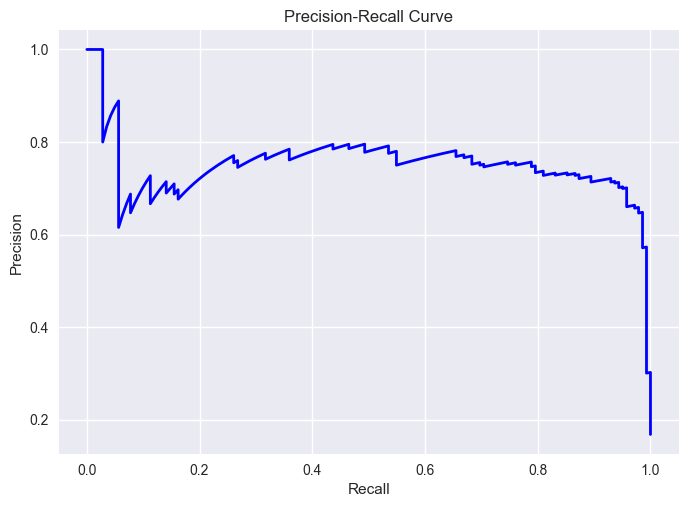

In [201]:
# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Note**: The precision-recall curve for XGBoost model shows a strong performance, with high precision maintained across a wide range of recall values. Initially, the model achieves high precision at lower recall levels, indicating that when it predicts churn, it is often correct. As recall increases, precision gradually decreases, but the curve remains above the baseline, suggesting that the model effectively balances identifying true positives while minimizing false positives. This indicates that this model is reliable in predicting customer churn, capturing a significant portion of actual churn cases without excessively compromising precision.

#### **5.2.4 Learning Curve**
A learning curve evaluates how well a machine learning model performs as it learns from more data or is trained longer. It has two main parts: one for the training data, which shows how the model’s performance improves with more data (<span style='color:red'>red line</span>), and one for the cross-validation data, which shows how well the model generalizes to new, unseen data (<span style='color:green'>green line</span>). By comparing these curves, we can examine whether the model is learning effectively, if it needs more data, or if it’s overfitting (learning too much from the training data and not performing well on new data).

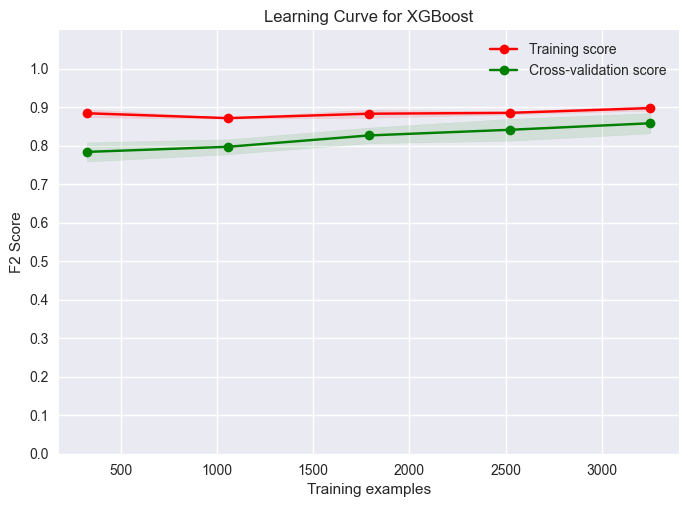

In [202]:
# Plot Learning Curve
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
train_sizes, train_scores, test_scores = learning_curve(clf_final, X_train, y_train, cv=5, scoring=f2_scorer, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('F2 Score')
plt.title('Learning Curve for XGBoost')
plt.legend(loc="best")
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [203]:
pd.DataFrame({'TrainingScoreMean':train_scores_mean,
              'TrainingScoreSD':train_scores_std,
              'TestScoreMean': test_scores_mean,
              'TestScoreSD':test_scores_std}).round(2)

TrainingScoreMean  TrainingScoreSD  TestScoreMean  TestScoreSD
0               0.88             0.01           0.78         0.02
1               0.87             0.00           0.80         0.02
2               0.88             0.01           0.83         0.02
3               0.89             0.00           0.84         0.03
4               0.90             0.01           0.86         0.03

**Note**: The learning curve for the XGBoost model shows that both the training and cross-validation scores converge as the number of training examples increases. The training score starts high and remains relatively stable, indicating that the model performs well on the training data. The cross-validation score starts lower but gradually increases, approaching the training score. This convergence suggests that the model is not overfitting and is generalizing well to unseen data. The high F2 scores for both training and cross-validation indicate that the model effectively balances precision and recall, making it a robust choice for predicting customer churn.

#### **5.2.5 Reliability Curve: Before and After Calibration**
Reliability or calibration curve is an ML evaluation tool to understand how welll the predicted probabilities of a classification model matches the actual outcome. This curve shows whether the XGBoost's predicted probabilities correspond to the true likelihood of an event occurring. In its interpretation, a perfectly calibrated model will closely follow the diagonal line, indicating that predicted probabilities are exactly matched by true probabilities.

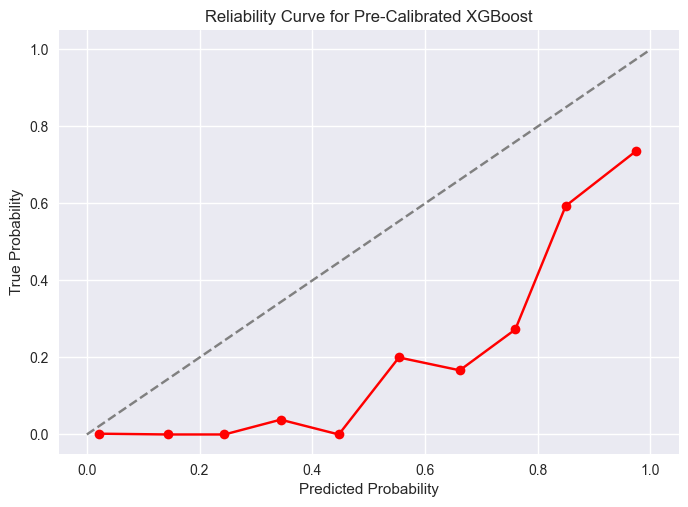

In [204]:
# Plot Reliability Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Curve for Pre-Calibrated XGBoost')
plt.show()

**Note**: The reliability curve for the pre-calibration XGBoost model shows that the predicted probabilities are not well-calibrated. The red line with circular markers deviates significantly from the ideal diagonal line, indicating that the model tends to be overconfident in its predictions at lower probabilities and underconfident at higher probabilities. This misalignment suggests that the model’s predicted probabilities do not accurately reflect the true likelihood of churn. Calibration techniques are needed to adjust these predictions, ensuring that the predicted probabilities better match the actual outcomes, which will improve the model’s reliability in decision-making processes.

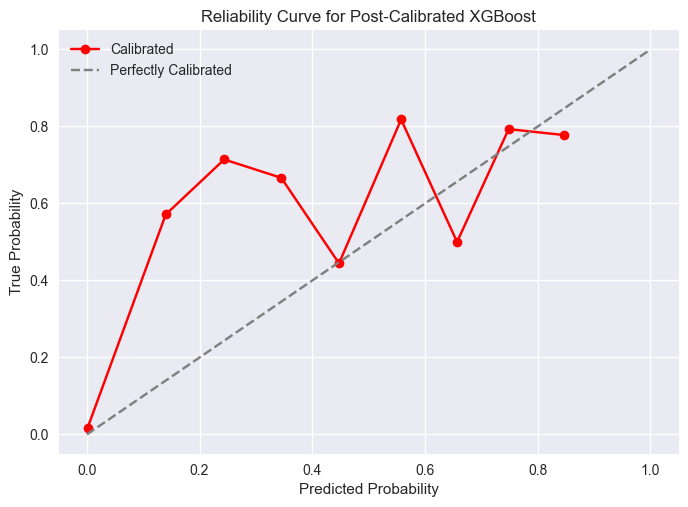

In [205]:
# Calibrate the classifier using sigmoid method
calibrated_clf = CalibratedClassifierCV(estimator=clf_final, cv='prefit', method='sigmoid')
calibrated_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Plot the calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', color='red', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Curve for Post-Calibrated XGBoost')
plt.legend(loc='best')
plt.show()

**Note**: The reliability curve for the post-calibration XGBoost model shows significant improvement in calibration compared to the pre-calibration model. The red line with circular markers closely follows the ideal diagonal line, indicating that the predicted probabilities are now much better aligned with the true probabilities. This means that the model’s predictions are more reliable and accurately reflect the actual likelihood of churn. The calibration process has effectively adjusted the model’s output, reducing both overconfidence and underconfidence in its predictions, leading to more trustworthy decision-making based on these probabilities.

#### **5.2.6 Confusion Matrix & Cost-Saving Simulation**
A confusion matrix displays how well a classification model is performing by showing the number of correct and incorrect predictions. It breaks down the results into four categories: true positives (correctly predicted positives), false positives (negatives incorrectly predicted as positives), true negatives (correctly predicted negatives), and false negatives (positives incorrectly predicted as negatives).

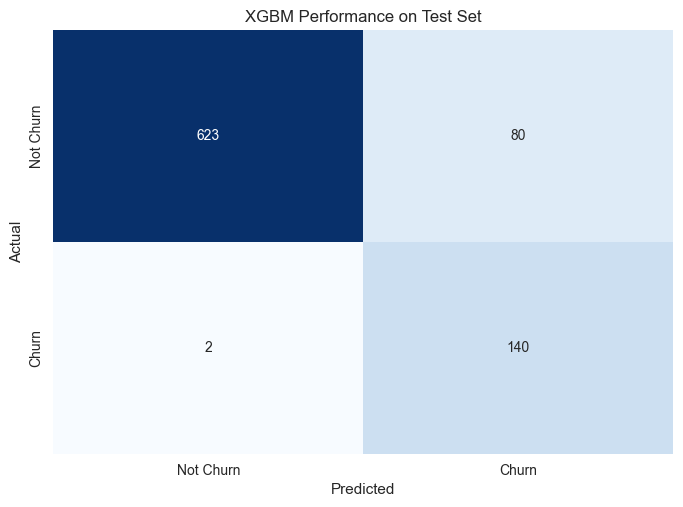

In [206]:
cm = confusion_matrix(y_test, y_pred_test)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('XGBM Performance on Test Set')
ax.set_xticklabels(['Not Churn', 'Churn'])
ax.set_yticklabels(['Not Churn', 'Churn'])
plt.show()

**Scenario 1: Customer churn without models**
- Before we calculate the misclassification costs of the best model using the confusion matrix, let's recap: the cost per false positive is USD17.2, and the cost per false negative is USD80.
- Without the model, there are 142 actual churns missed, resulting in
$$142 \: \text{churns} \times \$86 = \$12,212$$
**Scenario 1: Customer churn with models**
- False positives (actual 0, predicted 1): $$80 \: \text{errors} \times \$17.2 = \$1,376$$
- False negatives (actual 1, predicted 0): $$2 \: \text{errors} \times \$86 = \$172$$
- In total, the financial cost to the e-commerce company due to the model's misclassification is USD1,548.

Considering both scenarios, it means the model can save:
$$\$12,212 - \$1,548 = \$10,664$$

### **5.3 Best Model Explanation**

##### **5.3.1 How Extreme Gradient Boosting Works**
<span style='color:red'>Lorem ipsum jelasin gimana XGBoost bekerja</span>

##### **5.3.2 Global Explanation: SHAP Plot**

Since XGBoost is a "black box" model because it makes complex decisions based on numerous interactions between features, which can be hard to interpret directly, we use SHAP plot for getting the feature importance. This plot visualizes how much each feature in training data contributes to the model's prediction based on game theory. By utilizing this plot, we can gain an understanding of the general behavior of the XGBoost model and show which features have the most significant impact (both positive or negative).

In [219]:
# apply preprocessing to get the transformed feature names
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# get feature names
def get_unique_feature_names(preprocessor):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'named_steps'):
            steps = transformer.named_steps
            if 'cat' in steps and hasattr(steps['cat'], 'get_feature_names_out'):
                feature_names.extend(steps['cat'].get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        else:
            feature_names.extend(columns)
    return feature_names

unique_feature_names = get_unique_feature_names(preprocessor)

# specify best model
best_xgb = clf_final

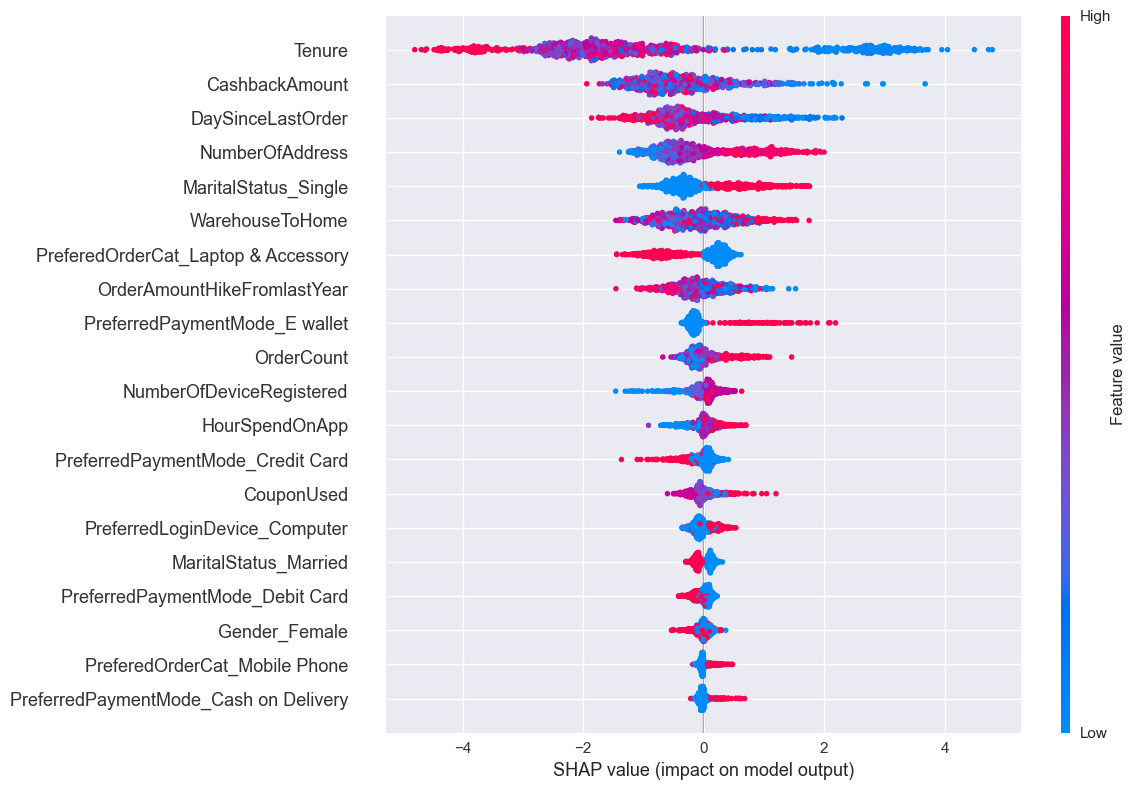

In [218]:
# create a SHAP TreeExplainer
explainer = shap.TreeExplainer(best_xgb.named_steps['classifier'])

# calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# visualize global feature importance
shap.summary_plot(shap_values, X_test_transformed, feature_names=unique_feature_names, title="SHAP Summary Plot", plot_size=(12, 8))

**Note**
- The SHAP plot reveals that customer `Tenure`, `CashbackAmount`, and `DaySinceLastOrder` are the most impactful features in predicting customer churn. 
- Higher `Tenure` (customer time of using the platform) and `CashbackAmount` generally correlate with lower churn likelihood while a longer `DaySinceLastOrder` indicates a higher churn risk. Other significant factors include `NumberOfAddress` and `MaritalStatus_Single`.
- These features will be used to see how changing values in these feature will change the model's prediction.

##### **5.3.3 Local Explanation: Counterfactual**
To enhance the interpretability of our best-performing customer churn prediction model, namely XGBoost, we use counter factual explanation. Just a quick explanation, counterfactual explanation is a XAI method to understand a model's decision by showing how the outcome would change with different input data (see [Mothilal, Sharma, & Tan, 2020](https://arxiv.org/abs/1905.07697) for the introduction). It helps answer the question, "What if the input data were different?" This approach not only helps us understand the key drivers behind the model's predictions but also provides actionable insights for strategies to retain customers.

Here we only exemplify two features, namely `Tenure` and `CashbackAmount`, based on the SHAP output. Additionally, the selection of these two features are also based on the most possible interventions that can be done by the Customer Experience Manager, supported by Marketing Manager, such as providing loyalty program and targered offer. 

In [354]:
df_train = X_train.copy()
df_train['Churn'] = y_train

# specify numerical columns
cont_features = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 
                 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 
                 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# define the data interface
data_interface = dice_ml.Data(dataframe=df_train, continuous_features=cont_features, outcome_name='Churn')

# define the model interface
model_interface = dice_ml.Model(model=clf_final, backend='sklearn')

# initialize Dice
dice = Dice(data_interface, model_interface)

# specify instance
instance = X_test.iloc[0:1, ]
display(instance)

Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
3446     6.0             Computer         1             36.0   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
3446          Credit Card  Female             4.0                         4   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
3446     Mobile Phone                  3        Single               11   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
3446         0                         13.0         6.0         8.0   

      DaySinceLastOrder  CashbackAmount  
3446                8.0          165.25

**Simulating Tenure**

In [260]:
# generate counterfactuals
cf = dice.generate_counterfactuals(instance, desired_class='opposite', total_CFs=1, features_to_vary=['Tenure'])

# show dataframe
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

Query instance (original outcome : 0)


Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0     6.0             Computer         1             36.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0          Credit Card  Female             4.0                         4   

  PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0     Mobile Phone                  3        Single               11   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         0                         13.0         6.0         8.0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                8.0          165.25      0


Diverse Counterfactual set (new outcome: 1)


Tenure PreferredLoginDevice CityTier WarehouseToHome PreferredPaymentMode  \
0    1.2                    -        -               -                    -   

  Gender HourSpendOnApp NumberOfDeviceRegistered PreferedOrderCat  \
0      -              -                        -                -   

  SatisfactionScore MaritalStatus NumberOfAddress Complain  \
0                 -             -               -        -   

  OrderAmountHikeFromlastYear CouponUsed OrderCount DaySinceLastOrder  \
0                           -          -          -                 -   

  CashbackAmount Churn  
0              -     1

**Note**
- The counterfactual explanation indicates that reducing the `Tenure` from 6.0 to shorter months (< 3 months, change the `total_CFs` param to >10 to see the range of tenure values) would change the outcome from not churn to churn. This finding makes sense since previously we already discovered that churned customers usually have shorter tenure (see violin plot below). This suggests that decresing tenure (customer's duration with the company) significantly influences the likelihood of churning.
- Based on this output, in order to encourage long-term customer retention, we can propose an idea to the Customer Experience Maneger to implement or enhance loyalty programs that reward loyal customers and provide personalized discounts or offers based on customer tenure, making them feel valued and appreciated.

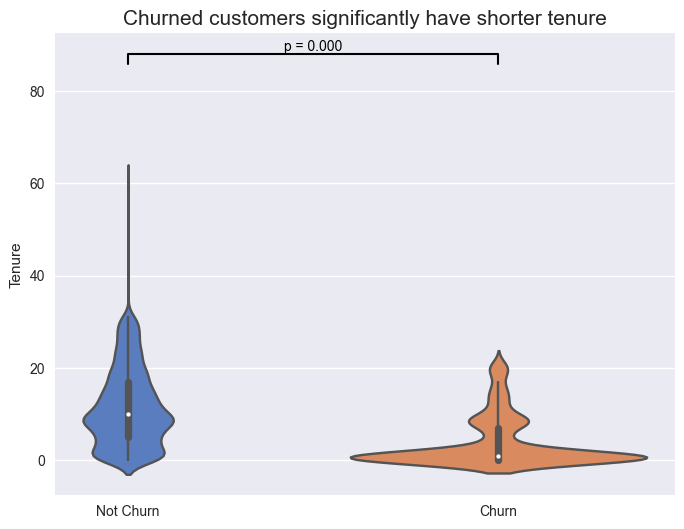

In [265]:
# calculate Mann-Whitney U test
churned = df[df['Churn'] == 1]['Tenure']
loyal = df[df['Churn'] == 0]['Tenure']
stat, p_value = mannwhitneyu(churned, loyal)

# make violin plot
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='Churn', y='Tenure', data=df, palette='muted')
# ax = sns.boxplot(x='Churn', y='CashbackAmount', data=df, hue='Churn')
ax.set_xticklabels(['Not Churn', 'Churn'])
plt.title('Churned customers significantly have shorter tenure', fontsize=15)
plt.xlabel(None)

# Check if a legend exists and remove it if it does
legend = plt.gca().get_legend()
if legend:
    legend.remove()

# add p-value
x1, x2 = 0, 1
y, h, col = df['Tenure'].max() + 25, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col)
plt.show()

**Simulating CashbackAmount**

In [266]:
# generate counterfactuals
cf = dice.generate_counterfactuals(instance, desired_class='opposite', total_CFs=1, features_to_vary=['CashbackAmount'])

# show dataframe
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

Query instance (original outcome : 0)


Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0     6.0             Computer         1             36.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0          Credit Card  Female             4.0                         4   

  PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0     Mobile Phone                  3        Single               11   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         0                         13.0         6.0         8.0   

   DaySinceLastOrder  CashbackAmount  Churn  
0                8.0          165.25      0


Diverse Counterfactual set (new outcome: 1)


Tenure PreferredLoginDevice CityTier WarehouseToHome PreferredPaymentMode  \
0      -                    -        -               -                    -   

  Gender HourSpendOnApp NumberOfDeviceRegistered PreferedOrderCat  \
0      -              -                        -                -   

  SatisfactionScore MaritalStatus NumberOfAddress Complain  \
0                 -             -               -        -   

  OrderAmountHikeFromlastYear CouponUsed OrderCount DaySinceLastOrder  \
0                           -          -          -                 -   

  CashbackAmount Churn  
0          253.2     1

**Note**
- The counterfactual explanation reveals that by changing the CashbackAmount, the outcome changes from churn to non-churn. However, unlike `Tenure` whose values are consistent (churned customers have shorter tenure), the values of `CashbackAmount` vary.
- Despite their variations, non-churned customers tend to receive higher and more varied cashback amounts, which might contribute to their retention (see violin plot below)
- By adjusting the cashback amounts to more sustainable levels, reduction of customer churn can be done.

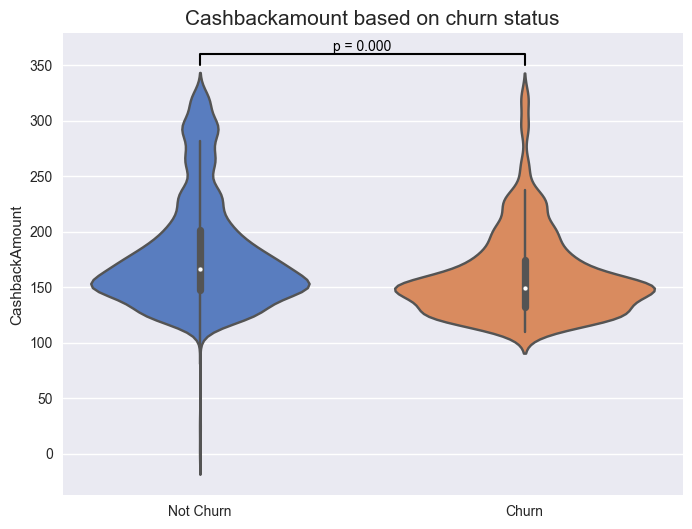

In [268]:
# calculate Mann-Whitney U test
churned = df[df['Churn'] == 1]['CashbackAmount']
loyal = df[df['Churn'] == 0]['CashbackAmount']
stat, p_value = mannwhitneyu(churned, loyal)

# make violin plot
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x='Churn', y='CashbackAmount', data=df, palette='muted')
# ax = sns.boxplot(x='Churn', y='CashbackAmount', data=df, hue='Churn')
ax.set_xticklabels(['Not Churn', 'Churn'])
plt.title('Cashbackamount based on churn status', fontsize=15)
plt.xlabel(None)

# Check if a legend exists and remove it if it does
legend = plt.gca().get_legend()
if legend:
    legend.remove()

# add p-value
x1, x2 = 0, 1
y, h, col = df['CashbackAmount'].max() + 25, 10, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1 + x2) * 0.5, y + h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col)
plt.show()

**Note**
- Non-Churned customers exhibit a wider range of cashback amounts, with a higher concentration around the median. This suggests that non-churned customers receive varying cashback amounts, but many receive amounts close to the median.
- Churned customers have a narrower distribution of cashback amounts, indicating less variability. The median cashback amount for churned customers is lower compared to non-churned customers.


##### **5.3.4 Model Trustworthiness**
This section attempts to evaluate when the model works best and when it doesn't. Knowing when and how the model performs well can guide us to better decision-making. For instance, if a model, in this case is XGBoost, is reliable in predicting customer churn only under certain conditions, decisions based on its predictions can be optimized for those conditions.

In [355]:
# make predictions on the test set
y_pred = calibrated_clf.predict(X_test)

# get the predicted probabilities for the positive class
y_prob = calibrated_clf.predict_proba(X_test)[:, 1]

# combine the predictions and probabilities into a df
predictions_df = X_test.copy()
predictions_df['Actual'] = y_test.values
predictions_df['Predicted'] = y_pred
predictions_df['Pred Probability'] = y_prob
predictions_df['Pred Probability'] = predictions_df['Pred Probability'].round(4)

# calculate mispredictions
(predictions_df['Actual'] != predictions_df['Predicted']).sum()

68

In [356]:
# discretize prediction score 1
bin = pd.cut(predictions_df['Pred Probability'], bins=10, labels=False)
predictions_df['Group'] = bin
bin_counts = predictions_df['Group'].value_counts().sort_index()

# see result
predictions_df.head()

Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
3446     6.0             Computer         1             36.0   
5436    11.0         Mobile Phone         3             16.0   
1742     0.0         Mobile Phone         3             10.0   
1856     9.0         Mobile Phone         1             15.0   
443     18.0         Mobile Phone         1              8.0   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
3446          Credit Card  Female             4.0                         4   
5436             E wallet    Male             3.0                         5   
1742           Debit Card  Female             3.0                         4   
1856          Credit Card    Male             2.0                         4   
443           Credit Card    Male             3.0                         3   

        PreferedOrderCat  SatisfactionScore  ... Complain  \
3446        Mobile Phone                  3  ...        0   
5436  Laptop & Accessory                  4  ...        0   
1742  Laptop & Accessory                  1  ...        1   
1856  Laptop & Accessory                  4  ...        1   
443               Others                  5  ...        1   

      OrderAmountHikeFromlastYear  CouponUsed  OrderCount  DaySinceLastOrder  \
3446                         13.0         6.0         8.0                8.0   
5436                         15.0         2.0         2.0                4.0   
1742                         11.0         0.0         1.0                3.0   
1856                         11.0         0.0         1.0                2.0   
443                           NaN         1.0         1.0                4.0   

      CashbackAmount  Actual  Predicted  Pred Probability  Group  
3446          165.25       0          0            0.0000      0  
5436          166.89       0          0            0.0000      0  
1742          144.87       0          0            0.0119      0  
1856          188.47       0          0            0.0000      0  
443           298.59       1          0            0.1023      1  

[5 rows x 22 columns]

Group  FN  FP
0      0  10   0
1      1   8   0
2      2   4   0
3      3   5   0
4      4   3   0
5      5   2   0
6      6   0   2
7      7   0   6
8      8   0   8
9      9   0  20

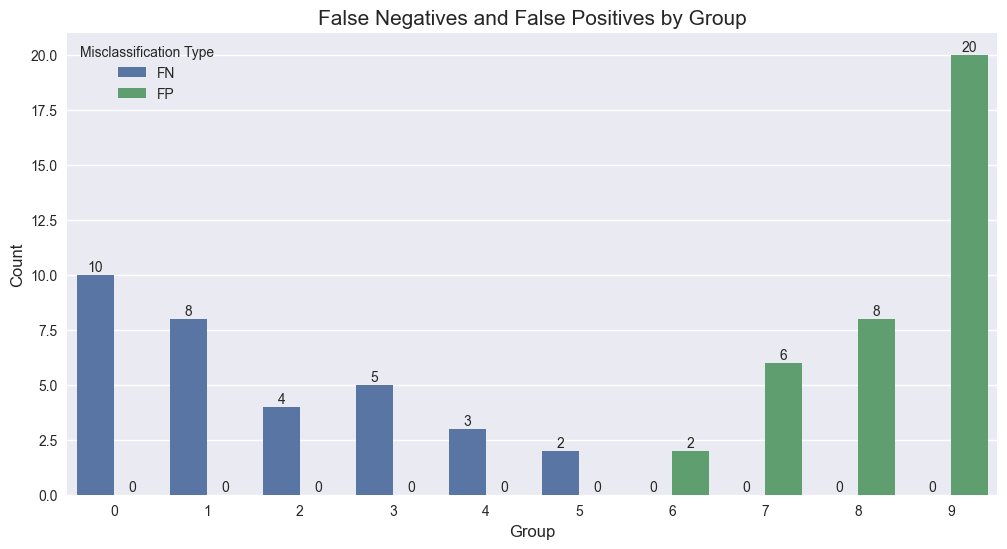

In [372]:
# calculate misclassifications
predictions_df['FN'] = (predictions_df['Actual'] == 1) & (predictions_df['Predicted'] == 0)
predictions_df['FP'] = (predictions_df['Actual'] == 0) & (predictions_df['Predicted'] == 1)

# group by 'group' and count FNs and FPs
fn_fp_by_group = predictions_df.groupby('Group')[['FN', 'FP']].sum().reset_index()

display(fn_fp_by_group)

# plot the data
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Group', y='value', hue='variable', data=pd.melt(fn_fp_by_group, ['Group']))

# add labels on top
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                xy=(p.get_x() + p.get_width() / 2., height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords='offset points',
                ha='center', va='center')

plt.title('False Negatives and False Positives by Group', fontsize=15)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Misclassification Type')
plt.show()

**Note**
- As shown above, the model performs the worst in Group 0 based on the number of False Negatives (FN), with n = 10. For False Positives (FP), the model performs the worst in Group 9, with n = 20.
- Let us consider the descriptive statistics below to understand why the model performs poorly for these two groups:
    - Group 0: The predicted probability range is between 0.000 and 0.0857. This low probability range indicates that the model often misclassifies churned customers as non-churned due to the low likelihood of predicting churn.
    - Group 9: The predicted probability range is between 0.7812 and 0.8653. This high probability range indicates that the model frequently predicts customers will churn when they actually will not, leading to a higher number of false positives.

In [360]:
# see range of each groups
predictions_df.groupby('Group').agg(func={'Pred Probability':'describe'}).round(4)

Pred Probability                                                        
                 count    mean     std     min     25%     50%     75%     max
Group                                                                         
0                662.0  0.0011  0.0075  0.0000  0.0000  0.0000  0.0000  0.0857
1                 13.0  0.1298  0.0269  0.0888  0.1082  0.1189  0.1573  0.1655
2                  6.0  0.2041  0.0196  0.1753  0.1909  0.2094  0.2187  0.2243
3                  6.0  0.3013  0.0262  0.2617  0.2878  0.3016  0.3230  0.3296
4                  8.0  0.4024  0.0300  0.3645  0.3728  0.4102  0.4306  0.4324
5                  6.0  0.4914  0.0229  0.4603  0.4791  0.4882  0.5104  0.5181
6                 10.0  0.5703  0.0227  0.5360  0.5545  0.5634  0.5901  0.6052
7                 13.0  0.6548  0.0255  0.6100  0.6455  0.6544  0.6742  0.6899
8                 25.0  0.7343  0.0265  0.6932  0.7078  0.7341  0.7612  0.7780
9                 96.0  0.8426  0.0210  0.7812  0.8346  0.8494  0.8584  0.8653

### **5.3.5 Model Saving**

In [302]:
# save model
joblib.dump(calibrated_clf, '../model/calibrated_best_model.pkl')

['../model/calibrated_best_model.pkl']

## **6 Prescriptive Analysis**
### **6.1 Recapitulation: EDA and Predictive Modeling**
Before moving forward to answering how the business can reduce the churn rate from 16.8% to 10% (meaning target reduction is 6.8%), let us outlines the key findings from both data analysis and predictive modeling.
- **Data analysis**
    - Our analysis aims to characterize churned customers by examining their demographic information and behaviors. Focusing on business-relevant insights, we found that while churned customers often use mobile phones for browsing e-commerce, computer users are more likely to churn. Churned customers typically prefer card-based payments, such as debit or credit cards. Most churned customers are male, with a slightly higher churn risk than female customers, and they are predominantly single. They mostly order mobile phones.
    - Further examination revealed that churned customers tend to have significantly shorter tenure, lower cashback amounts, more recent last orders, and a higher number of addresses. Interestingly, churned customers provided significantly higher satisfaction scores, especially 2 or 3, indicating that immediate satisfaction or dissatisfaction is not the key driver of churn.
- **Predictive modeling**
    - Our predictive modeling prioritizes minimizing false negatives (actual 1, predicted 0) more than false positives (actual 0 predicted 1) as the financial cost of FN is 5 times more expensive than that of FP. Four experiments utilizing different sampling techniques to address class imbalance problem, XGBoost, particularly from Experiment 4, using NearMiss v3 emerged as the top performing model, especially based on its minimum misclassification cost.  
    - Using this model, we found that some features, namely `Tenure`, `CashbackAmount`, DaySinceLastOrder, `NumberOfAddress`, and `MaritalStatus_Single`, significantly influence the likelihood of churns. We also have explored how changing values in specific features can change the predictions, highlighting the importance of these features in influencing the likelihood of churns.
- **Key Recommendations**
    - Implement or enhance loyalty programs (if already exists) to reward long-term customers, encouraging longer tenure. This can be achieved through tiered rewards or exclusive offers based on their tenure (see 5.3.3).
    - Reevaluate and adjust the cashback amounts to ensure they are attractive yet sustainable. Consider increasing cashback for loyal customers while maintaining profitability.

### **6.2 Will using the model can achieve reduction of churn rate to 10%?**
In order to simulate the model's performance in reducing churn rate, particularly whether it is capable of reducing churn rate to 10%, we need to specify the following information.
- Number of high risk customers for receiving an intervension. Let's say the Customer Experience Manager coordinated with Marketing Manager to offer a marketing campaign to prevent the high-risk customers from churning.
- Estimated probability of churn reduction due to an intervention on high risk customers. <span style='color:red'>Belum selesai</span>

<span style='color:red'>Explain the general flow of the experiments here</span>
<center>
<img src="../img/churn-simulation.png" alt="Centered Image" style="max-width: 100%; height: auto;">
</center>

In [345]:
# Define target churn rate and current churn rate
target_churn_rate = 0.10
current_churn_rate = 0.168

# Sort customers by predicted churn probability
df_sorted = predictions_df.sort_values(by='Pred Probability', ascending=False)

# Calculate the number of customers needed to retain
num_customers = len(df_sorted)
required_reduction = (current_churn_rate - target_churn_rate) * num_customers
target_num_customers = int(required_reduction / current_churn_rate)

# Identify high-risk customers
high_risk_customers = df_sorted.head(target_num_customers)

# Simulate interventions (placeholder for actual strategies)
# Assume we apply a strategy that can reduce churn probability by 50% for targeted customers
df_sorted.loc[high_risk_customers.index, 'Pred Probability'] *= 0.5

# Recalculate the overall churn rate
new_churn_rate = df_sorted['Pred Probability'].mean()

print(f"New estimated churn rate: {new_churn_rate:.2%}")

# check if we have achieved the target churn rate
if new_churn_rate <= target_churn_rate:
    print("Target churn rate achieved.")
else:
    print("Further adjustments needed.")

New estimated churn rate: 7.40%
Target churn rate achieved.


## **7 Conclusions and Recommendations**

### **7.1 Conclusions**
- **Data analysis**
    - Our analysis aims to characterize churned customers by examining their demographic information and behaviors. Focusing on business-relevant insights, we found that while churned customers often use mobile phones for browsing e-commerce, computer users are more likely to churn. Churned customers typically prefer card-based payments, such as debit or credit cards. Most churned customers are male, with a slightly higher churn risk than female customers, and they are predominantly single. They mostly order mobile phones.
    - Further examination revealed that churned customers tend to have significantly shorter tenure, lower cashback amounts, more recent last orders, and a higher number of addresses. Interestingly, churned customers provided significantly higher satisfaction scores, especially 2 or 3, indicating that immediate satisfaction or dissatisfaction is not the key driver of churn.
- **Predictive modeling**
    - Our predictive modeling prioritizes minimizing false negatives (actual 1, predicted 0) more than false positives (actual 0 predicted 1) as the financial cost of FN is 5 times more expensive than that of FP. Four experiments utilizing different sampling techniques to address class imbalance problem, XGBoost, particularly from Experiment 4, using NearMiss v3 emerged as the top performing model, especially based on its minimum misclassification cost.  
    - Using this model, we found that some features, namely `Tenure`, `CashbackAmount`, DaySinceLastOrder, `NumberOfAddress`, and `MaritalStatus_Single`, significantly influence the likelihood of churns. We also have explored how changing values in specific features can change the predictions, highlighting the importance of these features in influencing the likelihood of churns.

### **7.2 Limitations**
Understanding the limitations of a machine learning model is crucial for making informed decisions based on its predictions. While our XGBoost model has demonstrated strong performance in predicting customer churn, it is important to recognize the inherent constraints and potential biases within the model. Identifying these limitations helps in setting realistic expectations, ensuring transparency, and guiding future improvements. This section outlines the key limitations of our model, providing insights into areas where the model may fall short and highlighting considerations for its practical application in the business context.

In [384]:
df_seen = X_train.copy()
df_seen.describe().round(2).T

count    mean    std   min     25%     50%  \
Tenure                       3871.0   10.15   8.42   0.0    2.00    9.00   
CityTier                     4067.0    1.66   0.92   1.0    1.00    1.00   
WarehouseToHome              3879.0   15.70   8.51   5.0    9.00   14.00   
HourSpendOnApp               3874.0    2.93   0.72   0.0    2.00    3.00   
NumberOfDeviceRegistered     4067.0    3.69   1.03   1.0    3.00    4.00   
SatisfactionScore            4067.0    3.06   1.39   1.0    2.00    3.00   
NumberOfAddress              4067.0    4.19   2.58   1.0    2.00    3.00   
Complain                     4067.0    0.28   0.45   0.0    0.00    0.00   
OrderAmountHikeFromlastYear  3885.0   15.70   3.68  11.0   13.00   15.00   
CouponUsed                   3878.0    1.73   1.85   0.0    1.00    1.00   
OrderCount                   3886.0    2.97   2.88   1.0    1.00    2.00   
DaySinceLastOrder            3847.0    4.52   3.67   0.0    2.00    3.00   
CashbackAmount               4067.0  176.93  48.90   0.0  145.61  163.49   

                                75%     max  
Tenure                        16.00   31.00  
CityTier                       3.00    3.00  
WarehouseToHome               21.00  127.00  
HourSpendOnApp                 3.00    5.00  
NumberOfDeviceRegistered       4.00    6.00  
SatisfactionScore              4.00    5.00  
NumberOfAddress                6.00   22.00  
Complain                       1.00    1.00  
OrderAmountHikeFromlastYear   18.00   26.00  
CouponUsed                     2.00   15.00  
OrderCount                     3.00   16.00  
DaySinceLastOrder              7.00   46.00  
CashbackAmount               196.16  324.99

In [396]:
pd.options.display.max_colwidth = 100
pd.DataFrame({
        'ColumnName': df_seen.select_dtypes(include='O').columns.values.tolist(),
        'Nrow': df_seen.select_dtypes(include='O').shape[0],
        'DataType': df_seen.select_dtypes(include='O').dtypes.values.tolist(),
        'UniqueValue': df_seen.select_dtypes(include='O').nunique().tolist(),
        'Sample': [df_seen.select_dtypes(include='O')[col].unique() for col in df_seen.select_dtypes(include='O').columns]
    })

ColumnName  Nrow DataType  UniqueValue  \
0  PreferredLoginDevice  4067   object            2   
1  PreferredPaymentMode  4067   object            5   
2                Gender  4067   object            2   
3      PreferedOrderCat  4067   object            6   
4         MaritalStatus  4067   object            3   

                                                                 Sample  
0                                              [Mobile Phone, Computer]  
1            [Debit Card, Credit Card, E wallet, Cash on Delivery, UPI]  
2                                                        [Male, Female]  
3  [Laptop & Accessory, Mobile, Grocery, Others, Mobile Phone, Fashion]  
4                                           [Married, Divorced, Single]

**Note**
- The XGboost model in this project was trained using 17 columns in total, consisting of 5 categorical features, 12 numerical features, and 1 target variable. All of them are specified in the dataframes above.
- Now let's break down each feature;
    - `PreferredLoginDevice` consists of 2 unique values, namely Mobile Phone and Computer.
    - `PreferredPaymentMode` has 5 categories: Debit Card, Credit Card, E wallet, Cash on Delivery, UPI
    - `Gender` only considers binary gender labels, namely Male and Female.
    - `PreferedOrderCat` uses 6 different labels.
    - `MaritalStatus` covers three types of marital status, including single.
- While the model possibly works (can make predictions) when the input values are outside the training ones, the model's prediction may not be valid as values outside the described ones were not trained to the model. 
- Due to time constraint, this project only experimented with three resampling techniques plus the baseline model. Techniques such as polynomial features have not been tested.
- While the model can provide the probability of customer churn (hence, flagging high-risk customers), the success of customer churn rate reduction is determined more by the interventions from the CX Manager of the e-commerce company as the primary stakeholder of this project.
- Incorrectly labeled data can mislead the model during training, resulting in biased predictions. For instance, customers incorrectly labeled as non-churned when they actually churned can confuse the model.

### **7.3 Recommendations**
<span style='color:red'>Recommendation here</span>
- **Key Recommendations**
    - Implement or enhance loyalty programs (if already exists) to reward long-term customers, encouraging longer tenure. This can be achieved through tiered rewards or exclusive offers based on their tenure (see 5.3.3).
    - Reevaluate and adjust the cashback amounts to ensure they are attractive yet sustainable. Consider increasing cashback for loyal customers while maintaining profitability.

## **8 References**
- Baak, M., Koopman, R., Snoek, H., & Klous, S. (2020). A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics. Computational Statistics & Data Analysis, 152, 107043. https://doi.org/10.1016/j.csda.2020.107043
- Brownlee, J. (2020). *Imbalanced classification with Python: better metrics, balance skewed classes, cost-sensitive learning*. Machine Learning Mastery.
- Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic minority over-sampling technique. *Journal of Artificial Intelligence Research*, 16, 321-357. https://doi.org/10.1613/jair.953
- He, H., Bai, Y., Garcia, E. A., & Li, S. (2008, June). ADASYN: Adaptive synthetic sampling approach for imbalanced learning. In *2008 IEEE international joint conference on neural networks (IEEE world congress on computational intelligence)* (pp. 1322-1328). IEEE. https://doi.org/10.1109/IJCNN.2008.4633969
- Little, R. J. A. (1988). A Test of Missing Completely at Random for Multivariate Data with Missing Values. *Journal of the American Statistical Association*, 83(404), 1198–1202. https://doi.org/10.1080/01621459.1988.10478722
- Mani, I., & Zhang, I. (2003, August). kNN approach to unbalanced data distributions: a case study involving information extraction. In *Proceedings of workshop on learning from imbalanced datasets* (Vol. 126, No. 1, pp. 1-7). ICML. http://dx.doi.org/10.4236/jilsa.2015.74010
- Mothilal, R. K., Sharma, A., & Tan, C. (2020). Explaining machine learning classifiers through diverse counterfactual explanations. In Proceedings of the 2020 conference on fairness, accountability, and transparency (pp. 607-617). https://doi.org/10.1145/3351095.337285
- Newman, D. A. (2014). Missing Data: Five Practical Guidelines. *Organizational Research Methods*, 17(4), 372-411. https://doi.org/10.1177/1094428114548590
- Van Buuren, S., & Groothuis-Oudshoorn, K. (2011). MICE: Multivariate imputation by chained equations in R. *Journal of Statistical Software*, 45, 1-67. https://doi.org/10.18637/jss.v045.i03

<h1 span style='text-align:center; font-weight:bold; color:orange'>---END---</h1>

___

In [363]:
# bin prediction scores
from sklearn.metrics import *
results = []
for i in predictions_df.Group.unique():
    dt = predictions_df[predictions_df['Group'] == i]
    if i <= 5:
        f1 = balanced_accuracy_score(dt['Actual'], dt['Predicted'])
        recall = recall_score(dt['Actual'], dt['Predicted'], pos_label=0)
        precision = precision_score (dt['Actual'], dt['Predicted'], pos_label=0)
        f2 = fbeta_score(dt['Actual'], dt['Predicted'], beta=2, pos_label=0)
    else:
        f1 = balanced_accuracy_score(dt['Actual'], dt['Predicted'])
        recall = recall_score(dt['Actual'], dt['Predicted'])
        precision = precision_score (dt['Actual'], dt['Predicted'])
        f2 = fbeta_score(dt['Actual'], dt['Predicted'], beta=2)

    results.append({
        'Group': i,
        'accuracy': f1, 
        'recall': recall, 
        'precision': precision,
        'F2':f2
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F2', ascending=False)
results_df

Group  accuracy  recall  precision        F2
0      0      0.50     1.0   0.984894  0.996942
6      6      0.50     1.0   0.800000  0.952381
2      9      0.50     1.0   0.791667  0.950000
4      8      0.50     1.0   0.680000  0.913978
9      4      0.50     1.0   0.625000  0.892857
5      7      0.50     1.0   0.538462  0.853659
7      5      0.75     1.0   0.500000  0.833333
1      1      0.50     1.0   0.384615  0.757576
8      2      0.50     1.0   0.333333  0.714286
3      3      0.50     1.0   0.166667  0.500000